# Project - Deep Learning - DETR algorithm

This notebook contains the part of the project related to the implementation of DETR algorithm to deal with the object detection task on TrashCan dataset.

After a first part to load the dataset, preprocess the images and construct a DataLoader object from it, a second part is dedicated to the re-implmentation of the DETR algorithm. We re implemented the architecture of the model and all the functions needed to train it by ourself on TrashCan dataset. A third part test if we can achieve better performance by starting from a pre-trained DETR model, which is re trained on TrashCan dataset. The last part aims at implementing the computation of the mAP metric, and to compute this metric on our DETR models to be able to compare their performance to the one of other models. 

In [1]:
#J'installe une version plus récente parce que je crois qu'on a des soucis de compatibilité plus bas
#https://discuss.pytorch.org/t/runtimeerror-each-element-in-list-of-batch-should-be-of-equal-size/91737
!pip install torch==1.5.0
!pip install torchvision==0.6.0 
!pip install fiftyone 

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install pycocotools

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches #In order to draw the box ! 

import numpy as np

In [4]:
!pip install pytorch_pretrained_vit
from pytorch_pretrained_vit import ViT

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

CUDA_LAUNCH_BLOCKING=1.

In [39]:
from torchvision import models

In [40]:
device

'cuda'

## TrashCan Dataset

The Trashcan dataset can directly be downloaded from their website. We will focus on the "instances" version of the dataset, which already contains predefined train and test sets. For the train set for instance, the annotations for the images are in the files `instances_train_trashcan.json` and the images are in a folder  `train`.

All the annotations follow the COCO format, which is detailed here :  https://cocodataset.org/#format-data


### Load dataset 


In [7]:
!wget "https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y"
!unzip "dataset.zip?sequence=12&isAllowed=y"

--2022-02-02 09:38:19--  https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y
Resolving conservancy.umn.edu (conservancy.umn.edu)... 128.101.122.105
Connecting to conservancy.umn.edu (conservancy.umn.edu)|128.101.122.105|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 553029970 (527M) [application/zip]
Saving to: ‘dataset.zip?sequence=12&isAllowed=y.1’

llowed=y.1            1%[                    ]   9.08M  64.7KB/s    eta 2h 15m ^C
Archive:  dataset.zip?sequence=12&isAllowed=y
replace dataset/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [17]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [19]:
# The directory containing the source images
data_path = "dataset/instance_version/train"

# The path to the COCO format labels JSON file
labels_path = "dataset/instance_version/instances_train_trashcan.json"

In [20]:
import torch.utils.data as data
from PIL import Image
import os
import os.path

### Creation of a dataloader & pre-processing

We wanted to use COCO's API via `torchvision.datasets.CocoDetection` (https://pytorch.org/vision/stable/datasets.html), and we had to custom some functions to obtain the format of dataloader we wanted.

We resized images, kept only the boxes and category ids of our targets, and stored them in an array of dictionnaries.

The idea of the above custom functions is to be able to manage the fact that for each image the number of targets is different, and we didn't wanted a single tensor with a lot of empty objects to avoid useless time consumption.

In [21]:
class CocoDetection_diy_bis(data.Dataset) :
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        resize : (int,int) size of the images wanted 
    """

    def __init__(self, root, annFile, size):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.size = size
        
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        # Resize des images :
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        original_size = img.size
        img = self.transform(img)

        # Targets dict :
        targets = {'labels':[],'boxes':[]}

        for elem in target :  
          box = np.copy(elem['bbox'])
          box[0] /= original_size[0] #* self.size[0] 
          box[1] /= original_size[1] #* self.size[1] 
          box[2] /= original_size[0] #* self.size[0] 
          box[3] /= original_size[1] #* self.size[1] 
          targets['boxes'].append(box)
          targets['labels'].append(elem['category_id']-1) # -1 because in this dataset the category ids start to 1

        return img, targets
        


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [22]:
instances_train_4 = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224))

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


In [23]:
def collate_fn_diy (batch) : 
    """
    Parameters : 
    -----------
    batch : list of tuples (img,targets)

    Return : 
    -------
    images : tensor of dim batch_size x 3 x 224 x 224
    targets : list of dict containing : 
        - "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth objects in the target) containing the class labels
        - "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
    """
    imgs, trgts = list(zip(*batch)) # imgs et trgts sont désormais des batch_size-tuples 

    imgs = [img.unsqueeze(0) for img in list(imgs)] #ajout d'une dimension supplémentaire à tous les tenseurs
    images = torch.cat(imgs) # concaténation en un seul tenseur

    targets = []
    for t in list(trgts) : 
      targets.append({'labels' : torch.from_numpy(np.array(t["labels"])), 
                      'boxes' : torch.from_numpy(np.array(t["boxes"]))})
    
    return images, targets

In [24]:
# Format DataLoader :
instances_train_dataloader_4 = DataLoader(instances_train_4, batch_size=5, shuffle=True, collate_fn = collate_fn_diy)

### Visualization functions :

In [113]:
INSTANCES_CLASSES = ['rov','plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab', 'animal_eel', 'animal_etc',
                      'trash_clothing', 'trash_pipe', 'trash_bottle', 'trash_bag', 'trash_snack_wrapper','trash_can', 'trash_cup',
                      'trash_container','trash_unknown_instance', 'trash_branch', 'trash_wreckage', 'trash_tarp', 'trash_rope','trash_net']

* Visualization function for the targets :

In [53]:
import matplotlib.patches as patches

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


def plot_bounding_boxes(train_images, train_labels, idx_image, category_labels = INSTANCES_CLASSES, size = (224,224)) :
    # Visualization of the bounding boxes of image idx_image in a set of images
    
    fig,ax = plt.subplots(1) 

    # Display the image : 
    img = train_images[idx_image].squeeze()
    img_unnormalized = inv_normalize(img)
    ax.imshow(transforms.functional.to_pil_image(img_unnormalized))

    _,l,L = img.shape

    # Plot bounding boxes & category_id : 
    labels, boxes = train_labels[idx_image]['labels'].numpy(), train_labels[idx_image]['boxes'].numpy()
    print()
    for k, category_id in enumerate(labels) : 
          box = boxes[k] 
          xy = (box[0]*l , box[1]*L)
          rect = patches.Rectangle(xy , box[2]*l ,box[3]*L, linewidth=1, edgecolor='r', facecolor='none')
          ax.add_patch(rect)

          ax.text(xy[0], xy[1], category_labels[category_id], fontsize=8, bbox=dict(facecolor='r', alpha=0.5))

    plt.show()

* Visualization function for the predictions :

**Rq :** 
In the FB demos, I realized that in practice, outside of the training procedure, the predictions are kept only if their probability/score is superior to a certain proba (0.7 in their examples), so I added a parameter `keep_pred` for that purpose.

In [54]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def plot_bounding_boxes_predictions (images, predictions, idx_image, category_labels = INSTANCES_CLASSES, keep_pred = 0.7) :
    
    fig,ax = plt.subplots(1) 

    # Display the image : 
    img = images[idx_image].squeeze()
    img_unnormalized = inv_normalize(img)
    ax.imshow(transforms.functional.to_pil_image(img_unnormalized))

    _,l,L = img.shape

    # Plot bounding boxes & category_id : 
  
    labels_probas, boxes = predictions['pred_logits'][idx_image].cpu().softmax(-1).numpy(), predictions['pred_boxes'][idx_image].cpu().numpy()
    labels = labels_probas.argmax(-1)
    labels_prob = labels_probas.max(-1)

    for k, category_id in enumerate(labels) : 
          if category_id != 22 and labels_prob[k] > keep_pred :
              box = boxes[k] 
              xy = (box[0]*l , box[1]*L)
              rect = patches.Rectangle(xy , box[2]*l ,box[3]*L, linewidth=1, edgecolor='r', facecolor='none')
              ax.add_patch(rect)

              ax.text(xy[0], xy[1], category_labels[category_id], fontsize=8, bbox=dict(facecolor='r', alpha=0.5))

    plt.show()

* Quick exploration of the train and validation sets :

In [110]:
import pandas as pd

In [124]:
def description(instances, category_labels = INSTANCES_CLASSES) : 

    #Dataloader for train images with only one image per batch (for simplicity) :
    instances_dataloader_1 = DataLoader(instances, batch_size=1, shuffle=True, collate_fn = collate_fn_diy)

    # We will plot the number of objects of each category, and the boxplot of their sizes :
    nb_classes = len(category_labels)
    
    objects = []
    objects_image = []
    objects_shape = []

    for batch_id, (images, labels) in enumerate(instances_dataloader_1):

        boxes_gt, labels_gt = labels[0]['boxes'].numpy(), labels[0]['labels'].numpy() # arrays of shape : num_objects x 4 and num_objects

        for k, label in enumerate(labels_gt) :
            objects.append(label)
            objects_shape.append(boxes_gt[k][-1] * boxes_gt[k][-2])
            objects_image.append(batch_id)

    desc = pd.DataFrame({'category_id' : objects, 'area' : objects_shape, 'image_idx' : objects_image})

    # Adding the labels :
    df_labels = pd.DataFrame({'category_id' : [i for i in range(nb_classes)], 'category' : category_labels})
    desc = desc.join(df_labels.set_index('category_id'), on='category_id')

    # Plots :
    
        # Proportion of each objects in the dataset :
    fig,ax = plt.subplots(1,2, figsize=(14,5))
    desc_count = desc[['category','category_id','area']].groupby('category').agg({'category_id':'min', 'area' :'count'}).reset_index()
    desc_count['area'] *= 100 / desc_count['area'].sum()
        # desc_count = desc_count.sort_values('category_id', ascending=False)
    desc_count.plot(x='category',y='area', ylabel='count', kind='barh', legend=False, ax =ax[0])
    ax[0].set_xlabel('proportion of objects (%)')

        # Shape of objects : 
    desc.boxplot('area', by='category', vert=False, grid=False, showfliers=False, ax=ax[1])
    ax[1].set_xlabel('area (normalized)')

    plt.show()

        # Number of objects per image :
    fig2,ax2 = plt.subplots()
    desc_sum = desc[['image_idx','area']].groupby('image_idx').count().reset_index()
    desc_sum.boxplot('area', vert=False, grid=False, ax=ax2)
    ax2.set_xlabel('number of objects per image')
    plt.show()
    print('Mean number of objects per image :',desc_sum['area'].mean())

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Description of the train set :


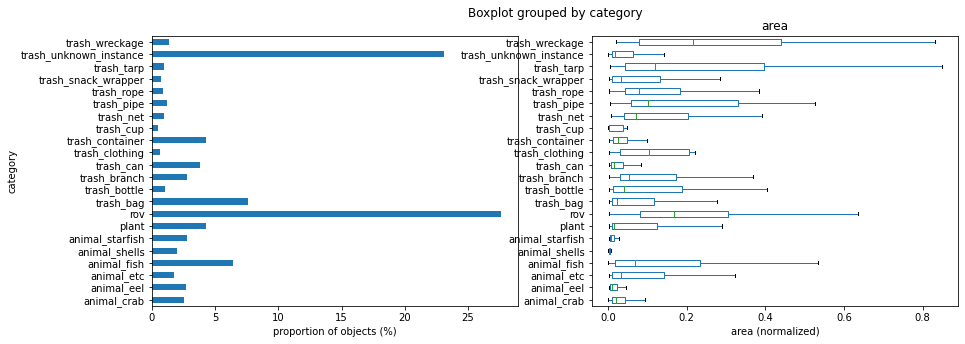

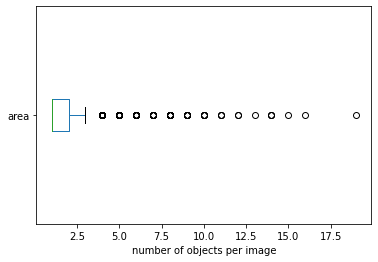

Mean number of objects per image : 1.6071428571428572


In [126]:
instances_train_1 = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224))
print('Description of the train set :')
description(instances_train_1)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Description of the validation set :


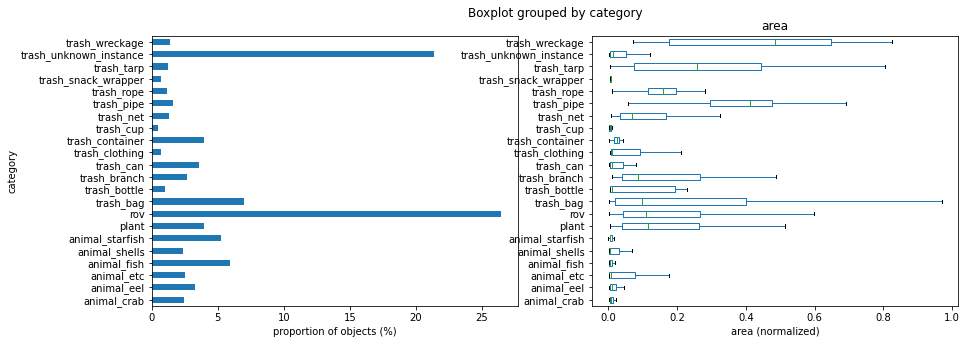

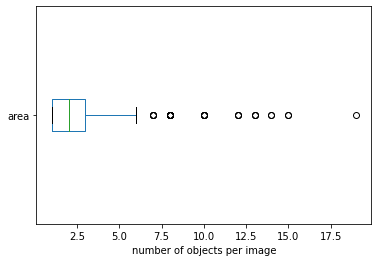

Mean number of objects per image : 2.2563208369659984


In [125]:
data_path_val = "dataset/instance_version/val"
labels_path_val = "dataset/instance_version/instances_val_trashcan.json"

instances_val_1 = CocoDetection_diy_bis(root = data_path_val, annFile = labels_path_val, size=(224,224))
print('Description of the validation set :')
description(instances_val_1)

## DETR - algorithm implementation

Our goal was to re implement the DETR architecture and the functions needed to train it by ourself on TrashCan dataset. 

Note that, to help us, we read and got inspiration from some notebooks with tutorials available on the [github corresponding to the article](https://github.com/facebookresearch/detr), including a Notebook with a minimal version of DETR for beginners, and [some other implementation inspired from the FB one ]( https://www.geeksforgeeks.org/object-detection-with-detection-transformer-dert-by-facebook/).

### DETR's architecture

* **Backbone :** We take a pre trained Resnet50, which has an output of size $2048$. In practice, from the implementations I got inspired from, this size is reduced to a smaller dimansion `hidden_dim` ($256$ per default) by default by a CNN.

* **Position encoding :** In the FB last version of the DETR, the Positional Encoding is learned. Here, we will just focus on a simpler encoding, using the Sine encoding seen in course : if we want to encode in $d$ dimensions (tq $d \equiv_2 0$) a position $t \in \mathbb{N}$, we have : 
$$(f(t))_i = \left\{
    \begin{array}{ll}
        \sin(w_k t) & \mbox{si } i = 2k \\
        \cos(w_k t) & \mbox{si } i=2k+1
    \end{array}
\right., \mbox{avec } w_k = \frac{1}{10000^{2k/d}} $$

* **Transformer :** To simplify, a transformer's architecture already implemented in `pytorch` was used via : `nn.Transformer`

* **Prediction head :** predictions heads for the class and the bbox are two (independent) linear networks.


In [25]:
import math

class DETR (torch.nn.Module) : 

  def __init__ (self, num_classes, retrain_resnet = False, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6, N = 100, device='cpu') :
    '''
    Parameters : 
    -----------
    num_classes : int
        nombre de catégories dans le jeu de données (sans compter la classe vide, qui sera rajoutée dans l'algo)
    retrain_reset : bool (default False) 
        si False, les paramètres de l'extracteur de features resnet seront fixés, et il ne sera pas updaté pendant le training (peut permettre de gagner du temps)
    hidden_dim : int (default 256)
        dimension souhaitée pour la taille des features de l'image (sortie du backbone)
    nheads, num_encoder_layers, num_decoder_layers : int (default 8,6,6)
        paramètres du transformer
    N : int (default 100)
        size of the set that will be predicted by the transformer (before bipartite matching loss)
    '''
    super(DETR, self).__init__()

    self.device = device
    self.num_classes = num_classes

    resnet50 = models.resnet50(pretrained=True)
    # Backbone : CNN du resnet (batch_size x 3 x H_0 x W_0 -> batch_size x 2048 x H x W) + Conv2D (batch_size x 2048 x H x W ->  batch_size x hidden_dim x H x W)
    self.resnet50_features = nn.Sequential(*(list(resnet50.children())[:-2]))
    if not retrain_resnet : 
      for param in self.resnet50_features.parameters(): 
          param.requires_grad = False # Fixe les paramètres du resnet50 dans le cas où retrain_resnet==False
    self.conv = nn.Conv2d(2048, hidden_dim, 1)

    # Positionnal encoding for the features : (batch_size x hidden_dim x H x W -> H*W x batch_size x hidden_dim)
        # Positional encoding sine 2D :
    d_model, length = hidden_dim // 2, N // 2
    self.row_embed = torch.zeros(length, d_model)
    self.col_embed = torch.zeros(length, d_model)

    position_row = torch.arange(0, length).unsqueeze(1)
    position_col = torch.arange(0, length).unsqueeze(1)
    w = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

    self.row_embed[:, 0::2] = torch.sin(position_row.float() * w)
    self.row_embed[:, 1::2] = torch.cos(position_row.float() * w)
    self.col_embed[:, 0::2] = torch.sin(position_col.float() * w)
    self.col_embed[:, 1::2] = torch.cos(position_col.float() * w)

        # For the queries of the transformer :
    self.query_pos = nn.Parameter(torch.rand(N, hidden_dim)) # 1 x N x hidden_dim

    # Transformer : 
    self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

    # Prediction head to put after the transformer : 
    self.linear_class = nn.Linear(hidden_dim, num_classes + 1)  # num_classes + 1 to add the "No object" fictive class
    self.linear_bbox = nn.Linear(hidden_dim, 4)


  def forward (self, inputs) : 
    # inputs shape : 3 x 224 x 224 ou batch_size x 3 x 224 x 224
    if len(inputs.shape) == 3 : #rajoute une dimension dans le cas où x ne contient qu'une seule image 
      inputs = inputs.unsqueeze(0) # x shape : 1 x 3 x 224 x 224

    # Features extraction : backbone + conv2d to have the features of the inputs 
    x = self.resnet50_features(inputs) # x shape : batch_size x 2048 x H x W où H=W=7 ici
    h = self.conv(x) #h shape : batch_size x hidden_dim x H x W

    # Positionnal encoding :
    H, W = h.shape[-2:]
    pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1) # pos shape : H*W x 1 x hidden_dim

    queries = self.query_pos.unsqueeze(1)
    batch_size = inputs.shape[0]
    if batch_size != 1 :
      queries = torch.repeat_interleave(queries, batch_size, dim=1) # shape N x batch_size x hidden_dim
    # Transformer :
    queries = queries.to(self.device)
    keys = (pos.to(self.device) + 0.1 * h.to(self.device).flatten(2).permute(2, 0, 1))
    keys = keys.to(self.device)
    h = self.transformer(keys, queries).transpose(0,1) # batch_size x N x hidden_dim
        
    # Predictions heads pour obtenir une bbox et une prédiction de classe : 
    pred_logits = self.linear_class(h) # batch_size x N x (num_classes + 1)
    pred_boxes = self.linear_bbox(h).sigmoid() # batch_size x N x 4
    return {'pred_logits': pred_logits, 
            'pred_boxes': pred_boxes}


### DETR's Training functions

To train the DETR, we need to define some functions to be able to compare predictions to targets. We will need :

1.   To compute a loss from a matching between two couples (category,bbox)
2.   To do a bipartite matching, that is to say to assign one prediction to each ground truth without redundancy.

#### **Loss** $\mathcal{L}_{bbox}$ :

$$\mathcal{L}_{bbox}(b_1, b_2) = \lambda_{iou} \mathcal{L}_{iou}(b_1, b_2) + \lambda_{L1} \|b_1-b_2\|_1 $$

with : $\lambda_{iou}, \lambda_{L1} \in \mathbb{R}$ hyperparameters, and $\mathcal{L}_{iou}(b_1, b_2) = 1 - \left( \frac{|b_1 \cap b_2 |}{|b_1 \cup b_2 |} - \frac{B(b_1,b_2) \setminus
 b_1 \cup b_2}{B(b_1,b_2)} \right)$, with $B(b_1,b_2)$ corresponding to the smaller box that would contains both $b_1$ and $b_2$.

In [26]:
def bbox_cxcywh_to_xyxy(x): 
    # Fonction reprise du git FB : renvoie la bbox sous forme de deux points, 
    # qui correspondent au coin inférieur gauche et supérieur droit
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


def loss_iou (b1, b2) : 
    """
    Parameters : 
    -----------
    b1, b2 : tensor qui contient des bounding boxes au format [c_x, c_y, w, h] (size : batch_size x num_queries (N) x 4)
      b1 correspond aux ground truth et b2 aux prédictions associées

    Output : 
    -------
    Matrice de taille len(b1) x len(b2), qui contient dans la case i,j la loss_iou entre b1_i, b2_j
    """
#     b1,b2 = b1.cuda(), b2.cuda()
    area1, area2 = b1[:,2]*b1[:,3], b2[:,2]*b2[:,3]

    b1_xyxy, b2_xyxy = bbox_cxcywh_to_xyxy(b1), bbox_cxcywh_to_xyxy(b2)
    
    # On garde le plus grand coin inf gauche, et le plus petit coin sur droit :
    max_inf_gauche = torch.max(b1_xyxy[:, None, :2], b2_xyxy[:, :2])
    min_inf_gauche = torch.min(b1_xyxy[:, None, :2], b2_xyxy[:, :2])
    max_sup_droit = torch.max(b1_xyxy[:, None, 2:], b2_xyxy[:, 2:])
    min_sup_droit = torch.min(b1_xyxy[:, None, 2:], b2_xyxy[:, 2:])

    # intersection area : 
    # correspond à l'aire de la boite [max_inf_gauche,min_sup_droit] = [(0,0) , max(min_sup_droit - max_inf_gauche ; (0,0))]
    inter_sup_droit_normalise = (min_sup_droit - max_inf_gauche).clamp(min=0)  # si b1 et b2 ont une intersection vide, on aura min_sup_droit - max_inf_gauche < 0, et le clamp permet de fixer l'intersection à 0
    inter_area = inter_sup_droit_normalise[:, :, 0] * inter_sup_droit_normalise[:, :, 1]

    # union : 
    # on utilise la formule aire_union = aire_1 + aire_2 - aire_inter
    union_area = area1[:,None] + area2 - inter_area

    # La plus petite boite qui couvrirait b1 et b2 correspond à : 
    # [min_inf_gauche,max_sup_droit] = [(0,0) , max(max_sup_droit - min_inf_gauche ; (0,0))]
    B_sup_droit_normalise = (max_sup_droit - min_inf_gauche).clamp(min=0)
    B_area = B_sup_droit_normalise[:, :, 0] * B_sup_droit_normalise[:, :, 1]

    # On a désormais tous les ingrédients pour calculer L_iou : 
    L_iou = 1 - (inter_area/union_area) + ((B_area - union_area)/B_area)
    return L_iou


def loss_bbox (b1,b2, lambda_iou, lambda_1) :
    """
    Parameters : 
    -----------
    b1, b2 : tensor qui contient des bounding boxes au format [c_x, c_y, w, h] (example size : batch_size x num_queries (N) x 4)
      b1 correspond aux ground truth et b2 aux prédictions associées 

    Output : 
    -------
    Matrice de taille len(b1) x len(b2), qui contient dans la case i,j la loss_bbox entre b1_i, b2_j
    """
    L_iou = loss_iou(b1,b2)
    L_1 = torch.cdist(b1, b2, p=1)

    return lambda_iou * L_iou + lambda_1 * L_1


#### **Bipartite matching :**

The bipartite matching was coded in a class. The idea is to compute cost matrices between predictions and ground truths. We then try to assigne one prediction to each ground truth without repetitions. It is similar to a hungarian assignment problem. 

The idea is to start by computint a matrice that would represent the "costs" between each prediction i and ground truth j. We then use an already existing matching function, implemented in `scipy.optimize.linear_sum_assignment`, which resolves the affectation problem for linear sums, that is to say to try to minimise the sum of the costs of all affectations.

In [27]:
from scipy.optimize import linear_sum_assignment 
# linear_sum_assignment : prend en argument une cost_matrix (array), et renvoie row_ind, col_ind (arrays), qui correspondent à la meilleure affectation de somme linéaire

class Bipartite_Matching (nn.Module) :

  def __init__ (self, lambda_category, lambda_iou, lambda_1, device='cpu') : 
      """
      Parameters : 
      -----------
      lambda_category, lambda_iou, lambda_1 : float
        correspondent aux hypermaramètres utilisés pour "pondérer" les 3 différentes loss dans la combinaison linéaire permettant d'obtenir la loss finale
      """
      super().__init__()
    
      self.device = device

      self.lambda_category = lambda_category
      self.lambda_iou = lambda_iou
      self.lambda_1 = lambda_1

  @torch.no_grad()
  def forward(self, predictions, ground_truth) :
      """
      Parameters :
      ------------
      predictions : dict
        contient : "pred_logits": Tensor of dim [batch_size, num_queries (N), num_classes] with the classification logits
                  "pred_boxes": Tensor of dim [batch_size, num_queries (N), 4] with the predicted box coordinates
      ground_truth : list de taille batch_size
        contient des dictionnaires avec : "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth objects in the target) containing the class labels
                                          "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates

      Output : 
      -------
      matching sous forme d'une liste de taille batch_size, qui contient des tuples(i,j) associant la prédiction i au ground truth j
      """
      batch_size, num_queries = predictions["pred_logits"].shape[:2]

      # On réduit la dimension des prédictions et on concatène tous les gound truth pour avoir des dimensions compatibles :
      predictions_prob = predictions["pred_logits"].flatten(0, 1).softmax(-1).float()  # [batch_size * num_queries, num_classes]
      predictions_bbox = predictions["pred_boxes"].flatten(0, 1).float()  # [batch_size * num_queries, 4]
      ground_truth_category = torch.cat([gt["labels"].type(torch.long) for gt in ground_truth]) # [batchsize, num_ground_truth]
      ground_truth_bbox = torch.cat([gt["boxes"] for gt in ground_truth]).float() # [batchsize, 4]

      # Calcul des différentes parties de la loss : 
      L_category = - self.lambda_category * predictions_prob[:, ground_truth_category] # proba de la classe du ground_truth dans la prédiction, [batch_size * num_queries, num_ground_truth]
      L_bbox = loss_bbox(ground_truth_bbox.to(device), predictions_bbox.to(device), self.lambda_iou, self.lambda_1) # [ num_ground_truth, batch_size * num_queries]

      L = L_category.permute(1,0) + L_bbox #  [ num_ground_truth, batch_size * num_queries]

      # On utilise enfin la fonction linear_sum_assignment pour obtenir les meilleurs affectations prédiction-ground truth :
      sizes_ground_truth = [len(gt["boxes"]) for gt in ground_truth] # nb de ground truth pour chaque image du batch, [batch_size]
      indices_affectations = []
      #loss_affectations = []
      for i,c in enumerate(L.split(sizes_ground_truth, 0)) : 
          L_i = c[:,i*num_queries:(i+1)*num_queries]
          row_ind, col_ind = linear_sum_assignment(L_i.cpu())
          #loss_affectations.append((L_i[row_ind, col_ind].sum()))
          indices_affectations.append((torch.as_tensor(row_ind, dtype=torch.int64),torch.as_tensor(col_ind, dtype=torch.int64)))

      return indices_affectations #, loss_affectations


#### **Hungarian Loss :**

Now that the bipartite matching is done, that is to say that we have found a permutation  $\sigma$ that realizes the best possible matching targets / predictions, we can calculate the final loss function : 

$$\mathcal{L}_{Hungarian}(y,\widehat{y},\sigma) = \sum_{i=1}^{N} \left[ - \log (\widehat{p}_{\sigma(i)}(c_i)) + \mathbb{1}_{\{c_i \neq -1\}} \mathcal{L}_{bbox}(b_i, \widehat{b}_{\sigma(i)}) \right]$$

With $y$ the targets, $\widehat{y}=\{\widehat{y_i}\}_{1\leq i\leq N}$ the prédictions and $\sigma$ the permutation obtained with the bipartite matching step.

In particular, the article recommands to underweight of a 10 factor the log-probabilities of the empty class predictions, as $N$ has been volontarily taken too high and the proportion of empty objets in the predictions will always be really high. 

In [28]:
import torch.nn.functional as F 

In [29]:
def hungarian_loss (predictions, targets, indices_affectations, num_classes, lambda_iou, lambda_1, device='cpu', downweight_empty = 1/23) : 
    # num_classes : nombre de classes, sans compter l'objet vide

    batch_size, N = predictions['pred_logits'].shape[:2]

    # Pour les catégories, on crée un tenseur de taille batch_size x num_queries (x 4) où on trouve les classes "targets" de chaque prédiction (par défaut num_class et non -1 !)
    # Pour les boxes, on va seulement conserver les listes de boxes targets et prédictions (la loss ne concerne pas les predictions de box pour lesquelles la classe vaut -1)

    targets_class = torch.full((batch_size,N), num_classes, dtype=torch.int64, device=device)

    predictions_boxes = []
    targets_boxes = []

    for k,dic in enumerate(labels) : 
        boxes_k = dic["boxes"].to(device) # tensor size num_target*4
        labels_k = dic["labels"].to(device) # tensor size num_target
        indices_target, indices_pred = indices_affectations[k] # tensors of size num_target

        if indices_target.shape[0] != 0 :
            targets_class[k][indices_pred] = labels_k[indices_target]
            
            targets_boxes.append(boxes_k[indices_target])
            predictions_boxes.append(predictions['pred_boxes'][k][indices_pred])

    targets_boxes = torch.cat(targets_boxes)
    predictions_boxes = torch.cat(predictions_boxes)

    # Loss sur les class : correspond à Cross Entropy loss implémentée dans torch.nn.functional.cross_entropy
    empty_weights = torch.ones(num_classes + 1, device=device) # tensor of size (num_classes+1) weight of each class
    empty_weights[-1] = downweight_empty
    L_ce = F.cross_entropy(predictions['pred_logits'].transpose(1, 2), targets_class, empty_weights)

    # Loss sur les boxes : on réutilise la loss précédemment implémentée :
    L_bbox = loss_bbox(targets_boxes.type(torch.float32), predictions_boxes, 1, 1)
    L_bbox = torch.diag(L_bbox).mean() # Dans le papier il y a une somme, mais cross_entropy renvoie une moyenne par défaut, donc cela évitera une trop grande diff avec la valeur de L_ce

    return L_ce + L_bbox

### DETR's Training

We are now ready to train our own DETR models.

We have trained different versions of the algorithm (not all presented here), choosing to froze or not the Resnet backbone and modifying the hyper-parameters :
- Classic training hyper-parameters : 
  * we chose to use Adam optimizer, which was more stable during the training, with a learning rate as small as possible, to try to have a model more stable but without slowing too much the convergence
  * we chose a number of epoch of 250 initially, and managed to have a good convergence, but to do several tests we chose only 50 epochs for time purposes...
  * we chose a little batch size of 32 for time purposes again

- Hyper parameters related to the DETR architecture : 
  * parameters of the transformer, size of the architecture, ... : was fixed to concentrate on other hyper parameters (the time to train one model was already really long).    
  * $\lambda_{iou}, \lambda_{L1}, \lambda_{category}$ are the parameters that gives more or less weight to the different part of our hungarian loss, defined previously. This type of loss is really hard to tune, and we chose to fix these hyper parameters and to concentrate on the `downweight_empty` one. This parameter corresponds to the way we down weight the part of the loss related to the score predicted to the category of empty objects. We have seen in our tests that this hyper-parameter was really impacting the quality of the predictions.

In [30]:
!pip install tqdm
from tqdm import tqdm

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### **Setting of hyper-parameters and Preparation of train and val dataloaders :**

In [33]:
# Hyper-parameters :

NB_EPOCHS = 250

BATCH_SIZE = 32
NB_INSTANCES_CLASSES = 22

LEARNING_RATE = 0.00001

DOWNWEIGHT_EMPTY = 1/23

LAMBDA_CATEGORY = 1
LAMBDA_IOU = 1
LAMBDA_1 = 1

In [34]:
# Training images :

instances_train = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224))
instances_train_dataloader = DataLoader(instances_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn = collate_fn_diy)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [35]:
NB_TRAIN_IMAGES = len(instances_train_4)
print("Nb of images in the train set : ",NB_TRAIN_IMAGES)

Nb of images in the train set :  6065


In [36]:
# Validation images :

data_path_val = "dataset/instance_version/val"
labels_path_val = "dataset/instance_version/instances_val_trashcan.json"

instances_val = CocoDetection_diy_bis(root = data_path_val, annFile = labels_path_val, size=(224,224))
instances_val_dataloader = DataLoader(instances_val, batch_size=5, shuffle=True, collate_fn = collate_fn_diy)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [37]:
NB_VAL_IMAGES = len(instances_val)
NB_VAL_IMAGES
print("Nb of images in the validation set : ",NB_VAL_IMAGES)

Nb of images in the validation set :  1147


#### **Without training the Resnet :** 

In [ ]:
detr = DETR(num_classes=NB_INSTANCES_CLASSES, retrain_resnet=False, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6, N = 100,device=device)
detr = detr.to(device)
bipartite_matcher = Bipartite_Matching(lambda_category=LAMBDA_CATEGORY, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device= device)
optimizer = torch.optim.Adam(detr.parameters(), lr=LEARNING_RATE)

In [ ]:
detr_learnable_params = 0
for p in detr.parameters() : 
    if p.requires_grad : 
        detr_learnable_params += p.numel() 
print('Total number of learnable parameters : ', detr_learnable_params)

Total number of learnable parameters :  17921051


In [ ]:
for p in detr.parameters() : 
    assert p.is_cuda

In [ ]:
training_losses = []
validation_losses = []

for epoch in tqdm(range(NB_EPOCHS)) :

    print("-"*50)
    print("Epoch :",epoch)

    training_loss = 0.
   

    for batch_id, (images, labels) in enumerate(instances_train_dataloader):

        optimizer.zero_grad()
        images = images.to(device)
        
        # Prédictions du modèle : 
        predictions = detr(images)
        
        # Loss : 
        indices_affectations = bipartite_matcher.forward(predictions, labels)

        loss = hungarian_loss(predictions, labels, indices_affectations, num_classes=NB_INSTANCES_CLASSES, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device=device, downweight_empty=DOWNWEIGHT_EMPTY)
        
        # Calcul de gradient :
        loss.backward()

        # 1 optimization step : 
        optimizer.step()
        
        # Training loss : 
        training_loss += loss.item() * len(labels)
        
        if batch_id % 20 == 0 :
            print(f'Training loss on batch_id {batch_id} : {loss.item()}')
        
    # Validation loss : 
    val_loss = 0.
    with torch.no_grad() : 
        for batch_id, (images, labels) in enumerate(instances_val_dataloader):
            images = images.to(device) 

                # Prédictions du modèle : 
            predictions = detr(images)

                # Loss : 
            indices_affectations = bipartite_matcher.forward(predictions, labels)

            loss = hungarian_loss(predictions, labels, indices_affectations, num_classes=NB_INSTANCES_CLASSES, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device=device, downweight_empty=DOWNWEIGHT_EMPTY)

            val_loss += loss.item() * len(labels)
    validation_losses.append(val_loss / NB_VAL_IMAGES)
    training_losses.append(training_loss / NB_TRAIN_IMAGES)
                   
    print(f'=> Training loss at epoch {epoch} :', training_losses[-1])
    print(f'=> Validation loss at end of epoch {epoch} :', validation_losses[-1])


In [ ]:
epochs = [u for u in range(NB_EPOCHS)]
plt.plot(epochs, validation_losses, label = 'Validation Losses', color = 'orange')
plt.plot(epochs, training_losses, label = 'Training Losses', color = 'blue')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
torch.save(obj=detr.state_dict(), f="detr_models/detr_{}epochs_{}batchsize_frozen.pt".format(NB_EPOCHS, BATCH_SIZE))

#### **With training of the Resnet :** 

In [41]:
detr = DETR(num_classes=NB_INSTANCES_CLASSES, retrain_resnet=True, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6, N = 100,device=device)
detr = detr.to(device)
bipartite_matcher = Bipartite_Matching(lambda_category=LAMBDA_CATEGORY, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device = device)
optimizer = torch.optim.Adam(detr.parameters(), lr=LEARNING_RATE)

In [42]:
for p in detr.parameters() : 
    assert p.is_cuda

In [43]:
detr_learnable_params = 0
for p in detr.parameters() : 
    if p.requires_grad : 
        detr_learnable_params += p.numel() 
print('Total number of learnable parameters : ', detr_learnable_params)

Total number of learnable parameters :  41429083


In [44]:
training_losses = []
validation_losses = []

for epoch in tqdm(range(NB_EPOCHS)) :

    print("-"*50)
    print("Epoch :",epoch)

    training_loss = 0.
   

    for batch_id, (images, labels) in enumerate(instances_train_dataloader):

        optimizer.zero_grad()
        images = images.to(device)
        
        # Prédictions du modèle : 
        predictions = detr(images)
        
        # Loss : 
        indices_affectations = bipartite_matcher.forward(predictions, labels)

        loss = hungarian_loss(predictions, labels, indices_affectations, num_classes=NB_INSTANCES_CLASSES, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device=device, downweight_empty=DOWNWEIGHT_EMPTY)
        
        # Calcul de gradient :
        loss.backward()

        # 1 optimization step : 
        optimizer.step()
                
        # Training loss : 
        training_loss += loss.item() * len(labels)
        
        if batch_id % 10 == 0 and epoch % 10 == 0:
            print(f'Training loss on batch_id {batch_id} : {loss.item()}')
        
    # Validation loss : 
    val_loss = 0.
    with torch.no_grad() : 
        for batch_id, (images, labels) in enumerate(instances_val_dataloader):
            images = images.to(device) 

                # Prédictions du modèle : 
            predictions = detr(images)

                # Loss : 
            indices_affectations = bipartite_matcher.forward(predictions, labels)

            loss = hungarian_loss(predictions, labels, indices_affectations, num_classes=NB_INSTANCES_CLASSES, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device=device, downweight_empty=DOWNWEIGHT_EMPTY)

            val_loss += loss.item() * len(labels)
    validation_losses.append(val_loss / NB_VAL_IMAGES)
    training_losses.append(training_loss / NB_TRAIN_IMAGES)
    

    print(f'=> Training loss at epoch {epoch} :', training_losses[-1])
    print(f'=> Validation loss at end of epoch {epoch} :', validation_losses[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

--------------------------------------------------
Epoch : 0
Training loss on batch_id 0 : 4.988595485687256
Training loss on batch_id 10 : 3.170159339904785
Training loss on batch_id 20 : 2.8157756328582764
Training loss on batch_id 30 : 2.621088981628418
Training loss on batch_id 40 : 2.864344596862793
Training loss on batch_id 50 : 3.0879197120666504
Training loss on batch_id 60 : 2.8511953353881836
Training loss on batch_id 70 : 2.7693700790405273
Training loss on batch_id 80 : 2.7281978130340576
Training loss on batch_id 90 : 2.5917041301727295
Training loss on batch_id 100 : 3.306058406829834
Training loss on batch_id 110 : 2.543377161026001
Training loss on batch_id 120 : 2.546281337738037
Training loss on batch_id 130 : 2.3567819595336914
Training loss on batch_id 140 : 2.698301315307617
Training loss on batch_id 150 : 2.3168234825134277
Training loss on batch_id 160 : 2.4621191024780273
Training loss on batch_id 170 : 2.3485360145568848
Training loss on batch_id 180 : 2.466112

  0%|          | 1/250 [02:08<8:54:51, 128.88s/it]

=> Training loss at epoch 0 : 2.7326323326815287
=> Validation loss at end of epoch 0 : 2.8713234607926013
--------------------------------------------------
Epoch : 1


  1%|          | 2/250 [04:20<8:59:20, 130.49s/it]

=> Training loss at epoch 1 : 2.315563031689549
=> Validation loss at end of epoch 1 : 2.6905589449790215
--------------------------------------------------
Epoch : 2


  1%|          | 3/250 [06:30<8:56:33, 130.34s/it]

=> Training loss at epoch 2 : 2.1698280339976135
=> Validation loss at end of epoch 2 : 2.7553043559830193
--------------------------------------------------
Epoch : 3


  2%|▏         | 4/250 [08:40<8:53:59, 130.24s/it]

=> Training loss at epoch 3 : 2.095575639342633
=> Validation loss at end of epoch 3 : 2.5503339525295945
--------------------------------------------------
Epoch : 4


  2%|▏         | 5/250 [10:49<8:49:53, 129.77s/it]

=> Training loss at epoch 4 : 2.036316435374412
=> Validation loss at end of epoch 4 : 2.554893325595307
--------------------------------------------------
Epoch : 5


  2%|▏         | 6/250 [12:58<8:46:12, 129.40s/it]

=> Training loss at epoch 5 : 1.9858011494956525
=> Validation loss at end of epoch 5 : 2.461478293929395
--------------------------------------------------
Epoch : 6


  3%|▎         | 7/250 [15:07<8:44:08, 129.42s/it]

=> Training loss at epoch 6 : 1.9402550507849734
=> Validation loss at end of epoch 6 : 2.440375022713579
--------------------------------------------------
Epoch : 7


  3%|▎         | 8/250 [17:19<8:44:38, 130.08s/it]

=> Training loss at epoch 7 : 1.903636827256595
=> Validation loss at end of epoch 7 : 2.3852939796946626
--------------------------------------------------
Epoch : 8


  4%|▎         | 9/250 [19:28<8:41:29, 129.83s/it]

=> Training loss at epoch 8 : 1.8646089919421267
=> Validation loss at end of epoch 8 : 2.3673990921238346
--------------------------------------------------
Epoch : 9


  4%|▍         | 10/250 [21:37<8:38:20, 129.58s/it]

=> Training loss at epoch 9 : 1.8345473025519299
=> Validation loss at end of epoch 9 : 2.403084826968292
--------------------------------------------------
Epoch : 10
Training loss on batch_id 0 : 1.749644160270691
Training loss on batch_id 10 : 1.7229490280151367
Training loss on batch_id 20 : 1.9690053462982178
Training loss on batch_id 30 : 1.6633667945861816
Training loss on batch_id 40 : 1.747171401977539
Training loss on batch_id 50 : 1.783531665802002
Training loss on batch_id 60 : 1.8282279968261719
Training loss on batch_id 70 : 1.8173348903656006
Training loss on batch_id 80 : 1.904895544052124
Training loss on batch_id 90 : 1.8490266799926758
Training loss on batch_id 100 : 1.7982243299484253
Training loss on batch_id 110 : 1.9970645904541016
Training loss on batch_id 120 : 1.7834861278533936
Training loss on batch_id 130 : 1.6368612051010132
Training loss on batch_id 140 : 1.8155646324157715
Training loss on batch_id 150 : 1.9534635543823242
Training loss on batch_id 160 :

  4%|▍         | 11/250 [23:47<8:36:25, 129.65s/it]

=> Training loss at epoch 10 : 1.7963595760232245
=> Validation loss at end of epoch 10 : 2.349414864205857
--------------------------------------------------
Epoch : 11


  5%|▍         | 12/250 [25:56<8:33:45, 129.52s/it]

=> Training loss at epoch 11 : 1.7637703180509663
=> Validation loss at end of epoch 11 : 2.3326319494555072
--------------------------------------------------
Epoch : 12


  5%|▌         | 13/250 [28:06<8:31:30, 129.50s/it]

=> Training loss at epoch 12 : 1.7386073401813553
=> Validation loss at end of epoch 12 : 2.325709968727365
--------------------------------------------------
Epoch : 13


  6%|▌         | 14/250 [30:15<8:29:06, 129.44s/it]

=> Training loss at epoch 13 : 1.7217561043694505
=> Validation loss at end of epoch 13 : 2.3142844867789445
--------------------------------------------------
Epoch : 14


  6%|▌         | 15/250 [32:23<8:25:50, 129.15s/it]

=> Training loss at epoch 14 : 1.6845012078674393
=> Validation loss at end of epoch 14 : 2.2982808993812633
--------------------------------------------------
Epoch : 15


  6%|▋         | 16/250 [34:32<8:23:27, 129.09s/it]

=> Training loss at epoch 15 : 1.664117680633746
=> Validation loss at end of epoch 15 : 2.2795918238298105
--------------------------------------------------
Epoch : 16


  7%|▋         | 17/250 [36:40<8:19:58, 128.75s/it]

=> Training loss at epoch 16 : 1.6454179151335337
=> Validation loss at end of epoch 16 : 2.2997670238082475
--------------------------------------------------
Epoch : 17


  7%|▋         | 18/250 [38:50<8:18:51, 129.02s/it]

=> Training loss at epoch 17 : 1.6144195329818662
=> Validation loss at end of epoch 17 : 2.2709836304031876
--------------------------------------------------
Epoch : 18


  8%|▊         | 19/250 [41:00<8:17:27, 129.21s/it]

=> Training loss at epoch 18 : 1.5928320163748821
=> Validation loss at end of epoch 18 : 2.270624048416783
--------------------------------------------------
Epoch : 19


  8%|▊         | 20/250 [43:09<8:15:53, 129.36s/it]

=> Training loss at epoch 19 : 1.5723488298016743
=> Validation loss at end of epoch 19 : 2.247060199769144
--------------------------------------------------
Epoch : 20
Training loss on batch_id 0 : 1.6211501359939575
Training loss on batch_id 10 : 1.491077184677124
Training loss on batch_id 20 : 1.5546464920043945
Training loss on batch_id 30 : 1.6482341289520264
Training loss on batch_id 40 : 1.3216853141784668
Training loss on batch_id 50 : 1.3931647539138794
Training loss on batch_id 60 : 1.5851080417633057
Training loss on batch_id 70 : 1.4403233528137207
Training loss on batch_id 80 : 1.6179063320159912
Training loss on batch_id 90 : 1.557483196258545
Training loss on batch_id 100 : 1.6642920970916748
Training loss on batch_id 110 : 1.411466360092163
Training loss on batch_id 120 : 1.48874831199646
Training loss on batch_id 130 : 1.6329071521759033
Training loss on batch_id 140 : 1.40183687210083
Training loss on batch_id 150 : 1.3832550048828125
Training loss on batch_id 160 : 

  8%|▊         | 21/250 [45:20<8:15:03, 129.71s/it]

=> Training loss at epoch 20 : 1.5610610531070266
=> Validation loss at end of epoch 20 : 2.2826521276076566
--------------------------------------------------
Epoch : 21


  9%|▉         | 22/250 [47:33<8:16:56, 130.78s/it]

=> Training loss at epoch 21 : 1.5341611780809747
=> Validation loss at end of epoch 21 : 2.219904415588745
--------------------------------------------------
Epoch : 22


  9%|▉         | 23/250 [49:45<8:15:38, 131.01s/it]

=> Training loss at epoch 22 : 1.5116680666325215
=> Validation loss at end of epoch 22 : 2.233160785206942
--------------------------------------------------
Epoch : 23


 10%|▉         | 24/250 [51:57<8:15:16, 131.49s/it]

=> Training loss at epoch 23 : 1.4947067226345443
=> Validation loss at end of epoch 23 : 2.2079324668245723
--------------------------------------------------
Epoch : 24


 10%|█         | 25/250 [54:09<8:13:10, 131.51s/it]

=> Training loss at epoch 24 : 1.4832414162424312
=> Validation loss at end of epoch 24 : 2.202407154604572
--------------------------------------------------
Epoch : 25


 10%|█         | 26/250 [56:20<8:10:54, 131.49s/it]

=> Training loss at epoch 25 : 1.4592679807202245
=> Validation loss at end of epoch 25 : 2.1809333181422796
--------------------------------------------------
Epoch : 26


 11%|█         | 27/250 [58:30<8:07:00, 131.03s/it]

=> Training loss at epoch 26 : 1.4453800886402617
=> Validation loss at end of epoch 26 : 2.204205545115284
--------------------------------------------------
Epoch : 27


 11%|█         | 28/250 [1:00:39<8:02:44, 130.47s/it]

=> Training loss at epoch 27 : 1.4237342210613984
=> Validation loss at end of epoch 27 : 2.227313333838113
--------------------------------------------------
Epoch : 28


 12%|█▏        | 29/250 [1:02:53<8:03:32, 131.28s/it]

=> Training loss at epoch 28 : 1.4147005388192273
=> Validation loss at end of epoch 28 : 2.154591341380358
--------------------------------------------------
Epoch : 29


 12%|█▏        | 30/250 [1:05:03<7:59:57, 130.90s/it]

=> Training loss at epoch 29 : 1.401178587514904
=> Validation loss at end of epoch 29 : 2.146890993833334
--------------------------------------------------
Epoch : 30
Training loss on batch_id 0 : 1.2480659484863281
Training loss on batch_id 10 : 1.3377776145935059
Training loss on batch_id 20 : 1.2775416374206543
Training loss on batch_id 30 : 1.4888410568237305
Training loss on batch_id 40 : 1.2313017845153809
Training loss on batch_id 50 : 1.2871840000152588
Training loss on batch_id 60 : 1.3498375415802002
Training loss on batch_id 70 : 1.520380973815918
Training loss on batch_id 80 : 1.3782474994659424
Training loss on batch_id 90 : 1.4288628101348877
Training loss on batch_id 100 : 1.4281489849090576
Training loss on batch_id 110 : 1.2938196659088135
Training loss on batch_id 120 : 1.555462121963501
Training loss on batch_id 130 : 1.341779112815857
Training loss on batch_id 140 : 1.3199082612991333
Training loss on batch_id 150 : 1.4524550437927246
Training loss on batch_id 160

 12%|█▏        | 31/250 [1:07:14<7:57:56, 130.94s/it]

=> Training loss at epoch 30 : 1.3883423752167554
=> Validation loss at end of epoch 30 : 2.1754419753732326
--------------------------------------------------
Epoch : 31


 13%|█▎        | 32/250 [1:09:23<7:53:46, 130.40s/it]

=> Training loss at epoch 31 : 1.3786169008489295
=> Validation loss at end of epoch 31 : 2.1738275866354666
--------------------------------------------------
Epoch : 32


 13%|█▎        | 33/250 [1:11:32<7:50:50, 130.18s/it]

=> Training loss at epoch 32 : 1.3604276811005356
=> Validation loss at end of epoch 32 : 2.144704928684983
--------------------------------------------------
Epoch : 33


 14%|█▎        | 34/250 [1:13:42<7:47:55, 129.98s/it]

=> Training loss at epoch 33 : 1.350742059567696
=> Validation loss at end of epoch 33 : 2.1502224017769334
--------------------------------------------------
Epoch : 34


 14%|█▍        | 35/250 [1:15:53<7:46:32, 130.20s/it]

=> Training loss at epoch 34 : 1.3464768832317582
=> Validation loss at end of epoch 34 : 2.17177521044416
--------------------------------------------------
Epoch : 35


 14%|█▍        | 36/250 [1:18:04<7:45:59, 130.65s/it]

=> Training loss at epoch 35 : 1.3267739481112235
=> Validation loss at end of epoch 35 : 2.1290033961132284
--------------------------------------------------
Epoch : 36


 15%|█▍        | 37/250 [1:20:14<7:42:23, 130.25s/it]

=> Training loss at epoch 36 : 1.3223521709049033
=> Validation loss at end of epoch 36 : 2.116831922593487
--------------------------------------------------
Epoch : 37


 15%|█▌        | 38/250 [1:22:22<7:38:39, 129.81s/it]

=> Training loss at epoch 37 : 1.3103147284609173
=> Validation loss at end of epoch 37 : 2.1864154428217653
--------------------------------------------------
Epoch : 38


 16%|█▌        | 39/250 [1:24:32<7:36:28, 129.80s/it]

=> Training loss at epoch 38 : 1.3079525117724766
=> Validation loss at end of epoch 38 : 2.1154908257769622
--------------------------------------------------
Epoch : 39


 16%|█▌        | 40/250 [1:26:42<7:34:02, 129.72s/it]

=> Training loss at epoch 39 : 1.295221994911848
=> Validation loss at end of epoch 39 : 2.1253339227844346
--------------------------------------------------
Epoch : 40
Training loss on batch_id 0 : 1.3249053955078125
Training loss on batch_id 10 : 1.1847009658813477
Training loss on batch_id 20 : 1.2221698760986328
Training loss on batch_id 30 : 1.3407371044158936
Training loss on batch_id 40 : 1.3084535598754883
Training loss on batch_id 50 : 1.2098591327667236
Training loss on batch_id 60 : 1.1342051029205322
Training loss on batch_id 70 : 1.4038970470428467
Training loss on batch_id 80 : 1.220477819442749
Training loss on batch_id 90 : 1.1008702516555786
Training loss on batch_id 100 : 1.3420571088790894
Training loss on batch_id 110 : 1.3069080114364624
Training loss on batch_id 120 : 1.1768003702163696
Training loss on batch_id 130 : 1.3249375820159912
Training loss on batch_id 140 : 1.27065110206604
Training loss on batch_id 150 : 1.2863328456878662
Training loss on batch_id 16

 16%|█▋        | 41/250 [1:28:51<7:31:35, 129.64s/it]

=> Training loss at epoch 40 : 1.286887839522523
=> Validation loss at end of epoch 40 : 2.139812801958897
--------------------------------------------------
Epoch : 41


 17%|█▋        | 42/250 [1:31:01<7:29:53, 129.78s/it]

=> Training loss at epoch 41 : 1.2663199974698462
=> Validation loss at end of epoch 41 : 2.153372551216285
--------------------------------------------------
Epoch : 42


 17%|█▋        | 43/250 [1:33:13<7:29:28, 130.28s/it]

=> Training loss at epoch 42 : 1.258092855188538
=> Validation loss at end of epoch 42 : 2.1035479735371956
--------------------------------------------------
Epoch : 43


 18%|█▊        | 44/250 [1:35:23<7:27:00, 130.19s/it]

=> Training loss at epoch 43 : 1.2526941703944194
=> Validation loss at end of epoch 43 : 2.1081290781861717
--------------------------------------------------
Epoch : 44


 18%|█▊        | 45/250 [1:37:32<7:24:13, 130.02s/it]

=> Training loss at epoch 44 : 1.23671576514877
=> Validation loss at end of epoch 44 : 2.14990679346798
--------------------------------------------------
Epoch : 45


 18%|█▊        | 46/250 [1:39:42<7:21:38, 129.90s/it]

=> Training loss at epoch 45 : 1.2364499892465162
=> Validation loss at end of epoch 45 : 2.147514786840836
--------------------------------------------------
Epoch : 46


 19%|█▉        | 47/250 [1:41:52<7:19:12, 129.82s/it]

=> Training loss at epoch 46 : 1.2240640540999612
=> Validation loss at end of epoch 46 : 2.098954757401085
--------------------------------------------------
Epoch : 47


 19%|█▉        | 48/250 [1:44:01<7:16:42, 129.72s/it]

=> Training loss at epoch 47 : 1.2145950506859737
=> Validation loss at end of epoch 47 : 2.1143204412360554
--------------------------------------------------
Epoch : 48


 20%|█▉        | 49/250 [1:46:11<7:14:40, 129.75s/it]

=> Training loss at epoch 48 : 1.2058615343883228
=> Validation loss at end of epoch 48 : 2.074536809634414
--------------------------------------------------
Epoch : 49


 20%|██        | 50/250 [1:48:21<7:12:26, 129.73s/it]

=> Training loss at epoch 49 : 1.2038655855590807
=> Validation loss at end of epoch 49 : 2.0823751283710483
--------------------------------------------------
Epoch : 50
Training loss on batch_id 0 : 1.074242115020752
Training loss on batch_id 10 : 1.229248046875
Training loss on batch_id 20 : 1.1702014207839966
Training loss on batch_id 30 : 1.3193652629852295
Training loss on batch_id 40 : 1.3994560241699219
Training loss on batch_id 50 : 1.0852947235107422
Training loss on batch_id 60 : 1.2126779556274414
Training loss on batch_id 70 : 1.118493914604187
Training loss on batch_id 80 : 1.3137576580047607
Training loss on batch_id 90 : 1.267673134803772
Training loss on batch_id 100 : 1.0981495380401611
Training loss on batch_id 110 : 1.345217227935791
Training loss on batch_id 120 : 1.071917176246643
Training loss on batch_id 130 : 1.3369536399841309
Training loss on batch_id 140 : 1.1307094097137451
Training loss on batch_id 150 : 1.4275949001312256
Training loss on batch_id 160 : 1

 20%|██        | 51/250 [1:50:30<7:10:06, 129.68s/it]

=> Training loss at epoch 50 : 1.1930623246733059
=> Validation loss at end of epoch 50 : 2.135164853688833
--------------------------------------------------
Epoch : 51


 21%|██        | 52/250 [1:52:41<7:08:57, 129.99s/it]

=> Training loss at epoch 51 : 1.184211872632309
=> Validation loss at end of epoch 51 : 2.079256676442746
--------------------------------------------------
Epoch : 52


 21%|██        | 53/250 [1:54:51<7:06:58, 130.04s/it]

=> Training loss at epoch 52 : 1.181475766670183
=> Validation loss at end of epoch 52 : 2.1104614450917
--------------------------------------------------
Epoch : 53


 22%|██▏       | 54/250 [1:57:02<7:05:20, 130.21s/it]

=> Training loss at epoch 53 : 1.1764555291311858
=> Validation loss at end of epoch 53 : 2.0842562677970426
--------------------------------------------------
Epoch : 54


 22%|██▏       | 55/250 [1:59:13<7:04:23, 130.58s/it]

=> Training loss at epoch 54 : 1.1679325929085087
=> Validation loss at end of epoch 54 : 2.0959720157392145
--------------------------------------------------
Epoch : 55


 22%|██▏       | 56/250 [2:01:22<7:00:16, 129.98s/it]

=> Training loss at epoch 55 : 1.155144279787389
=> Validation loss at end of epoch 55 : 2.057017097498088
--------------------------------------------------
Epoch : 56


 23%|██▎       | 57/250 [2:03:49<7:14:51, 135.19s/it]

=> Training loss at epoch 56 : 1.155335228362559
=> Validation loss at end of epoch 56 : 2.0736702966399054
--------------------------------------------------
Epoch : 57


 23%|██▎       | 58/250 [2:06:05<7:13:25, 135.44s/it]

=> Training loss at epoch 57 : 1.1424573992660787
=> Validation loss at end of epoch 57 : 2.0234456591327605
--------------------------------------------------
Epoch : 58


 24%|██▎       | 59/250 [2:08:16<7:07:11, 134.20s/it]

=> Training loss at epoch 58 : 1.1322543160343406
=> Validation loss at end of epoch 58 : 2.0742078354905353
--------------------------------------------------
Epoch : 59


 24%|██▍       | 60/250 [2:10:27<7:01:39, 133.15s/it]

=> Training loss at epoch 59 : 1.128591924409481
=> Validation loss at end of epoch 59 : 2.0853879651299954
--------------------------------------------------
Epoch : 60
Training loss on batch_id 0 : 1.0064823627471924
Training loss on batch_id 10 : 1.0957553386688232
Training loss on batch_id 20 : 1.274209976196289
Training loss on batch_id 30 : 1.1542057991027832
Training loss on batch_id 40 : 1.2022819519042969
Training loss on batch_id 50 : 1.1781730651855469
Training loss on batch_id 60 : 1.205470323562622
Training loss on batch_id 70 : 1.006578803062439
Training loss on batch_id 80 : 1.2717201709747314
Training loss on batch_id 90 : 1.0158143043518066
Training loss on batch_id 100 : 1.2684931755065918
Training loss on batch_id 110 : 1.0647625923156738
Training loss on batch_id 120 : 1.020054817199707
Training loss on batch_id 130 : 1.0572198629379272
Training loss on batch_id 140 : 1.0629262924194336
Training loss on batch_id 150 : 1.1015704870224
Training loss on batch_id 160 : 

 24%|██▍       | 61/250 [2:12:37<6:56:05, 132.09s/it]

=> Training loss at epoch 60 : 1.131792777919219
=> Validation loss at end of epoch 60 : 2.099722532781187
--------------------------------------------------
Epoch : 61


 25%|██▍       | 62/250 [2:14:48<6:52:50, 131.76s/it]

=> Training loss at epoch 61 : 1.125242122499194
=> Validation loss at end of epoch 61 : 2.0530849605824706
--------------------------------------------------
Epoch : 62


 25%|██▌       | 63/250 [2:16:56<6:47:09, 130.64s/it]

=> Training loss at epoch 62 : 1.1157977836739397
=> Validation loss at end of epoch 62 : 2.0733828262962666
--------------------------------------------------
Epoch : 63


 26%|██▌       | 64/250 [2:19:05<6:43:23, 130.13s/it]

=> Training loss at epoch 63 : 1.1115445682261467
=> Validation loss at end of epoch 63 : 2.083069808605763
--------------------------------------------------
Epoch : 64


 26%|██▌       | 65/250 [2:21:15<6:41:05, 130.08s/it]

=> Training loss at epoch 64 : 1.1069088843865327
=> Validation loss at end of epoch 64 : 2.0330068224289155
--------------------------------------------------
Epoch : 65


 26%|██▋       | 66/250 [2:23:25<6:39:30, 130.27s/it]

=> Training loss at epoch 65 : 1.094329189448345
=> Validation loss at end of epoch 65 : 2.0578147660366013
--------------------------------------------------
Epoch : 66


 27%|██▋       | 67/250 [2:25:34<6:35:53, 129.80s/it]

=> Training loss at epoch 66 : 1.0899763828255573
=> Validation loss at end of epoch 66 : 2.037965066035935
--------------------------------------------------
Epoch : 67


 27%|██▋       | 68/250 [2:27:43<6:32:41, 129.46s/it]

=> Training loss at epoch 67 : 1.0866421848314416
=> Validation loss at end of epoch 67 : 2.075202367673673
--------------------------------------------------
Epoch : 68


 28%|██▊       | 69/250 [2:29:50<6:28:58, 128.94s/it]

=> Training loss at epoch 68 : 1.0828569054701853
=> Validation loss at end of epoch 68 : 2.078229134718854
--------------------------------------------------
Epoch : 69


 28%|██▊       | 70/250 [2:31:59<6:26:43, 128.91s/it]

=> Training loss at epoch 69 : 1.0809402266319192
=> Validation loss at end of epoch 69 : 2.031065454873814
--------------------------------------------------
Epoch : 70
Training loss on batch_id 0 : 1.218156099319458
Training loss on batch_id 10 : 0.9253689646720886
Training loss on batch_id 20 : 0.9614350199699402
Training loss on batch_id 30 : 1.0866680145263672
Training loss on batch_id 40 : 1.073960304260254
Training loss on batch_id 50 : 0.9903320074081421
Training loss on batch_id 60 : 1.1351454257965088
Training loss on batch_id 70 : 1.1950304508209229
Training loss on batch_id 80 : 1.154054880142212
Training loss on batch_id 90 : 1.0294690132141113
Training loss on batch_id 100 : 0.9784859418869019
Training loss on batch_id 110 : 1.1281520128250122
Training loss on batch_id 120 : 1.0593295097351074
Training loss on batch_id 130 : 1.0532605648040771
Training loss on batch_id 140 : 1.1772503852844238
Training loss on batch_id 150 : 0.9724243879318237
Training loss on batch_id 16

 28%|██▊       | 71/250 [2:34:08<6:24:17, 128.81s/it]

=> Training loss at epoch 70 : 1.0715419450478425
=> Validation loss at end of epoch 70 : 2.1189030559040094
--------------------------------------------------
Epoch : 71


 29%|██▉       | 72/250 [2:36:17<6:22:41, 129.00s/it]

=> Training loss at epoch 71 : 1.067543008714693
=> Validation loss at end of epoch 71 : 2.1148459326212783
--------------------------------------------------
Epoch : 72


 29%|██▉       | 73/250 [2:38:27<6:21:28, 129.31s/it]

=> Training loss at epoch 72 : 1.0538363503898753
=> Validation loss at end of epoch 72 : 2.0612430422328925
--------------------------------------------------
Epoch : 73


 30%|██▉       | 74/250 [2:40:36<6:18:55, 129.18s/it]

=> Training loss at epoch 73 : 1.0442596369898232
=> Validation loss at end of epoch 73 : 2.006922514623627
--------------------------------------------------
Epoch : 74


 30%|███       | 75/250 [2:42:44<6:15:45, 128.83s/it]

=> Training loss at epoch 74 : 1.0375113996512026
=> Validation loss at end of epoch 74 : 2.0901816604235117
--------------------------------------------------
Epoch : 75


 30%|███       | 76/250 [2:44:52<6:13:03, 128.64s/it]

=> Training loss at epoch 75 : 1.0304910005465677
=> Validation loss at end of epoch 75 : 2.0246379373379138
--------------------------------------------------
Epoch : 76


 31%|███       | 77/250 [2:47:00<6:10:19, 128.43s/it]

=> Training loss at epoch 76 : 1.0233496317368151
=> Validation loss at end of epoch 76 : 2.0278990029665107
--------------------------------------------------
Epoch : 77


 31%|███       | 78/250 [2:49:09<6:08:10, 128.43s/it]

=> Training loss at epoch 77 : 1.0178365852060343
=> Validation loss at end of epoch 77 : 2.0105486058523683
--------------------------------------------------
Epoch : 78


 32%|███▏      | 79/250 [2:51:18<6:06:24, 128.57s/it]

=> Training loss at epoch 78 : 1.0108340633672226
=> Validation loss at end of epoch 78 : 2.043057087773121
--------------------------------------------------
Epoch : 79


 32%|███▏      | 80/250 [2:53:27<6:04:37, 128.69s/it]

=> Training loss at epoch 79 : 1.003395595092569
=> Validation loss at end of epoch 79 : 2.110839454942718
--------------------------------------------------
Epoch : 80
Training loss on batch_id 0 : 1.0190746784210205
Training loss on batch_id 10 : 1.0392522811889648
Training loss on batch_id 20 : 1.1289113759994507
Training loss on batch_id 30 : 0.9699615836143494
Training loss on batch_id 40 : 0.9713157415390015
Training loss on batch_id 50 : 1.077195644378662
Training loss on batch_id 60 : 1.0014822483062744
Training loss on batch_id 70 : 0.9885299205780029
Training loss on batch_id 80 : 1.0705668926239014
Training loss on batch_id 90 : 0.9344545602798462
Training loss on batch_id 100 : 0.968975841999054
Training loss on batch_id 110 : 1.0296909809112549
Training loss on batch_id 120 : 1.0851716995239258
Training loss on batch_id 130 : 0.9570435881614685
Training loss on batch_id 140 : 0.9476317763328552
Training loss on batch_id 150 : 1.1099718809127808
Training loss on batch_id 16

 32%|███▏      | 81/250 [2:55:37<6:04:05, 129.26s/it]

=> Training loss at epoch 80 : 0.9970820557648548
=> Validation loss at end of epoch 80 : 2.015638792681091
--------------------------------------------------
Epoch : 81


 33%|███▎      | 82/250 [2:57:46<6:01:23, 129.07s/it]

=> Training loss at epoch 81 : 0.9990519986502513
=> Validation loss at end of epoch 81 : 2.122638413983007
--------------------------------------------------
Epoch : 82


 33%|███▎      | 83/250 [2:59:54<5:58:32, 128.82s/it]

=> Training loss at epoch 82 : 0.9885043718356882
=> Validation loss at end of epoch 82 : 2.0969753231603163
--------------------------------------------------
Epoch : 83


 34%|███▎      | 84/250 [3:02:03<5:56:23, 128.81s/it]

=> Training loss at epoch 83 : 0.9835685285476251
=> Validation loss at end of epoch 83 : 2.114497605571564
--------------------------------------------------
Epoch : 84


 34%|███▍      | 85/250 [3:04:12<5:54:23, 128.87s/it]

=> Training loss at epoch 84 : 0.9780604422829511
=> Validation loss at end of epoch 84 : 2.106368124952707
--------------------------------------------------
Epoch : 85


 34%|███▍      | 86/250 [3:06:19<5:51:04, 128.44s/it]

=> Training loss at epoch 85 : 0.9677334829685812
=> Validation loss at end of epoch 85 : 2.0908327916443814
--------------------------------------------------
Epoch : 86


 35%|███▍      | 87/250 [3:08:26<5:47:46, 128.02s/it]

=> Training loss at epoch 86 : 0.9651261745360108
=> Validation loss at end of epoch 86 : 2.0402519555848477
--------------------------------------------------
Epoch : 87


 35%|███▌      | 88/250 [3:10:34<5:45:16, 127.88s/it]

=> Training loss at epoch 87 : 0.9558676238405931
=> Validation loss at end of epoch 87 : 2.0768782452281496
--------------------------------------------------
Epoch : 88


 36%|███▌      | 89/250 [3:12:44<5:44:40, 128.45s/it]

=> Training loss at epoch 88 : 0.9493563277408886
=> Validation loss at end of epoch 88 : 2.0686929530440565
--------------------------------------------------
Epoch : 89


 36%|███▌      | 90/250 [3:14:51<5:41:56, 128.23s/it]

=> Training loss at epoch 89 : 0.9445662942880063
=> Validation loss at end of epoch 89 : 2.083773667540047
--------------------------------------------------
Epoch : 90
Training loss on batch_id 0 : 1.0830979347229004
Training loss on batch_id 10 : 0.8425135612487793
Training loss on batch_id 20 : 0.9072521924972534
Training loss on batch_id 30 : 0.9114077687263489
Training loss on batch_id 40 : 0.7423663139343262
Training loss on batch_id 50 : 1.03403902053833
Training loss on batch_id 60 : 1.1254500150680542
Training loss on batch_id 70 : 0.9393764138221741
Training loss on batch_id 80 : 0.856613278388977
Training loss on batch_id 90 : 0.8856868147850037
Training loss on batch_id 100 : 1.1526771783828735
Training loss on batch_id 110 : 0.8861989974975586
Training loss on batch_id 120 : 0.7818957567214966
Training loss on batch_id 130 : 0.9151040315628052
Training loss on batch_id 140 : 0.9031926393508911
Training loss on batch_id 150 : 0.906132161617279
Training loss on batch_id 160

 36%|███▋      | 91/250 [3:17:00<5:39:53, 128.26s/it]

=> Training loss at epoch 90 : 0.9355508515781739
=> Validation loss at end of epoch 90 : 2.086148585146577
--------------------------------------------------
Epoch : 91


 37%|███▋      | 92/250 [3:19:07<5:36:44, 127.88s/it]

=> Training loss at epoch 91 : 0.9340116341057044
=> Validation loss at end of epoch 91 : 2.0486335606811976
--------------------------------------------------
Epoch : 92


 37%|███▋      | 93/250 [3:21:13<5:33:46, 127.56s/it]

=> Training loss at epoch 92 : 0.9230214750383476
=> Validation loss at end of epoch 92 : 2.014582354812489
--------------------------------------------------
Epoch : 93


 38%|███▊      | 94/250 [3:23:22<5:32:27, 127.87s/it]

=> Training loss at epoch 93 : 0.915372694491947
=> Validation loss at end of epoch 93 : 2.101109309464615
--------------------------------------------------
Epoch : 94


 38%|███▊      | 95/250 [3:25:30<5:29:58, 127.73s/it]

=> Training loss at epoch 94 : 0.9188515502563313
=> Validation loss at end of epoch 94 : 2.078802667499732
--------------------------------------------------
Epoch : 95


 38%|███▊      | 96/250 [3:27:40<5:30:05, 128.61s/it]

=> Training loss at epoch 95 : 0.9065589848964153
=> Validation loss at end of epoch 95 : 2.1506468300831867
--------------------------------------------------
Epoch : 96


 39%|███▉      | 97/250 [3:29:49<5:27:59, 128.62s/it]

=> Training loss at epoch 96 : 0.9046156741328605
=> Validation loss at end of epoch 96 : 2.054407634419156
--------------------------------------------------
Epoch : 97


 39%|███▉      | 98/250 [3:31:57<5:25:36, 128.53s/it]

=> Training loss at epoch 97 : 0.8953422705201403
=> Validation loss at end of epoch 97 : 2.051820118788958
--------------------------------------------------
Epoch : 98


 40%|███▉      | 99/250 [3:34:05<5:22:43, 128.23s/it]

=> Training loss at epoch 98 : 0.8927887477859031
=> Validation loss at end of epoch 98 : 2.0774113157051173
--------------------------------------------------
Epoch : 99


 40%|████      | 100/250 [3:36:12<5:20:15, 128.11s/it]

=> Training loss at epoch 99 : 0.889750532178179
=> Validation loss at end of epoch 99 : 2.064638077329321
--------------------------------------------------
Epoch : 100
Training loss on batch_id 0 : 0.9467552900314331
Training loss on batch_id 10 : 0.7239675521850586
Training loss on batch_id 20 : 1.062832236289978
Training loss on batch_id 30 : 0.9806160926818848
Training loss on batch_id 40 : 0.9227334856987
Training loss on batch_id 50 : 0.8288673162460327
Training loss on batch_id 60 : 0.7494593858718872
Training loss on batch_id 70 : 0.8482802510261536
Training loss on batch_id 80 : 0.7932785153388977
Training loss on batch_id 90 : 0.8554991483688354
Training loss on batch_id 100 : 0.9000246524810791
Training loss on batch_id 110 : 0.9988824129104614
Training loss on batch_id 120 : 0.9950046539306641
Training loss on batch_id 130 : 0.9347074031829834
Training loss on batch_id 140 : 0.8412224054336548
Training loss on batch_id 150 : 0.6928167343139648
Training loss on batch_id 160

 40%|████      | 101/250 [3:38:22<5:18:51, 128.40s/it]

=> Training loss at epoch 100 : 0.8792272007573466
=> Validation loss at end of epoch 100 : 2.0448002084609
--------------------------------------------------
Epoch : 101


 41%|████      | 102/250 [3:40:30<5:16:27, 128.29s/it]

=> Training loss at epoch 101 : 0.8804882589294609
=> Validation loss at end of epoch 101 : 2.046942042753607
--------------------------------------------------
Epoch : 102


 41%|████      | 103/250 [3:42:38<5:14:30, 128.37s/it]

=> Training loss at epoch 102 : 0.8729788811366025
=> Validation loss at end of epoch 102 : 2.133627358216666
--------------------------------------------------
Epoch : 103


 42%|████▏     | 104/250 [3:44:46<5:12:00, 128.22s/it]

=> Training loss at epoch 103 : 0.868625996669068
=> Validation loss at end of epoch 103 : 2.0966606741899394
--------------------------------------------------
Epoch : 104


 42%|████▏     | 105/250 [3:46:53<5:09:08, 127.92s/it]

=> Training loss at epoch 104 : 0.8665941915920915
=> Validation loss at end of epoch 104 : 2.079986091686937
--------------------------------------------------
Epoch : 105


 42%|████▏     | 106/250 [3:49:02<5:07:31, 128.13s/it]

=> Training loss at epoch 105 : 0.8546461476438417
=> Validation loss at end of epoch 105 : 2.0769852462704534
--------------------------------------------------
Epoch : 106


 43%|████▎     | 107/250 [3:51:11<5:06:26, 128.58s/it]

=> Training loss at epoch 106 : 0.8554411966350584
=> Validation loss at end of epoch 106 : 2.068781293103668
--------------------------------------------------
Epoch : 107


 43%|████▎     | 108/250 [3:53:21<5:04:51, 128.81s/it]

=> Training loss at epoch 107 : 0.8489036390236951
=> Validation loss at end of epoch 107 : 2.0654772347019565
--------------------------------------------------
Epoch : 108


 44%|████▎     | 109/250 [3:55:30<5:02:42, 128.81s/it]

=> Training loss at epoch 108 : 0.8452927005654608
=> Validation loss at end of epoch 108 : 2.091871660485305
--------------------------------------------------
Epoch : 109


 44%|████▍     | 110/250 [3:57:38<5:00:19, 128.71s/it]

=> Training loss at epoch 109 : 0.8494362660507869
=> Validation loss at end of epoch 109 : 2.0671149253221626
--------------------------------------------------
Epoch : 110
Training loss on batch_id 0 : 0.7829891443252563
Training loss on batch_id 10 : 0.7580887675285339
Training loss on batch_id 20 : 0.8670481443405151
Training loss on batch_id 30 : 0.8073266744613647
Training loss on batch_id 40 : 0.9622328281402588
Training loss on batch_id 50 : 0.7493327856063843
Training loss on batch_id 60 : 0.8631199598312378
Training loss on batch_id 70 : 0.7198260426521301
Training loss on batch_id 80 : 0.8693950176239014
Training loss on batch_id 90 : 0.6824333667755127
Training loss on batch_id 100 : 0.9661614894866943
Training loss on batch_id 110 : 0.7550973892211914
Training loss on batch_id 120 : 0.8200464844703674
Training loss on batch_id 130 : 0.8536099195480347
Training loss on batch_id 140 : 0.9665974974632263
Training loss on batch_id 150 : 0.8425930738449097
Training loss on batc

 44%|████▍     | 111/250 [3:59:48<4:58:48, 128.98s/it]

=> Training loss at epoch 110 : 0.8404916565082138
=> Validation loss at end of epoch 110 : 2.0139280354446605
--------------------------------------------------
Epoch : 111


 45%|████▍     | 112/250 [4:01:58<4:57:16, 129.25s/it]

=> Training loss at epoch 111 : 0.8315475930090493
=> Validation loss at end of epoch 111 : 2.043294162727379
--------------------------------------------------
Epoch : 112


 45%|████▌     | 113/250 [4:04:06<4:54:46, 129.10s/it]

=> Training loss at epoch 112 : 0.8384881598636913
=> Validation loss at end of epoch 112 : 2.0686001624869803
--------------------------------------------------
Epoch : 113


 46%|████▌     | 114/250 [4:06:16<4:52:50, 129.19s/it]

=> Training loss at epoch 113 : 0.8298031294237752
=> Validation loss at end of epoch 113 : 2.0846959496438244
--------------------------------------------------
Epoch : 114


 46%|████▌     | 115/250 [4:08:23<4:49:27, 128.65s/it]

=> Training loss at epoch 114 : 0.828487863996652
=> Validation loss at end of epoch 114 : 2.0524448419303196
--------------------------------------------------
Epoch : 115


 46%|████▋     | 116/250 [4:10:32<4:47:21, 128.66s/it]

=> Training loss at epoch 115 : 0.8184195214622982
=> Validation loss at end of epoch 115 : 2.043989345782096
--------------------------------------------------
Epoch : 116


 47%|████▋     | 117/250 [4:12:40<4:45:01, 128.58s/it]

=> Training loss at epoch 116 : 0.8122552037239075
=> Validation loss at end of epoch 116 : 2.0098921156179
--------------------------------------------------
Epoch : 117


 47%|████▋     | 118/250 [4:14:50<4:43:33, 128.89s/it]

=> Training loss at epoch 117 : 0.8083834914657958
=> Validation loss at end of epoch 117 : 2.053009425803902
--------------------------------------------------
Epoch : 118


 48%|████▊     | 119/250 [4:16:58<4:40:38, 128.54s/it]

=> Training loss at epoch 118 : 0.8064694938439528
=> Validation loss at end of epoch 118 : 2.078879976023148
--------------------------------------------------
Epoch : 119


 48%|████▊     | 120/250 [4:19:06<4:38:40, 128.62s/it]

=> Training loss at epoch 119 : 0.8051672788267773
=> Validation loss at end of epoch 119 : 2.064753486887725
--------------------------------------------------
Epoch : 120
Training loss on batch_id 0 : 0.7639531493186951
Training loss on batch_id 10 : 0.7756746411323547
Training loss on batch_id 20 : 0.9240743517875671
Training loss on batch_id 30 : 0.7021394968032837
Training loss on batch_id 40 : 0.6970192790031433
Training loss on batch_id 50 : 0.8088842034339905
Training loss on batch_id 60 : 0.8923290967941284
Training loss on batch_id 70 : 0.6107370257377625
Training loss on batch_id 80 : 0.6153845191001892
Training loss on batch_id 90 : 0.9190809726715088
Training loss on batch_id 100 : 0.6892347931861877
Training loss on batch_id 110 : 0.7273606061935425
Training loss on batch_id 120 : 0.838336169719696
Training loss on batch_id 130 : 0.9187694191932678
Training loss on batch_id 140 : 0.7326048016548157
Training loss on batch_id 150 : 0.881629467010498
Training loss on batch_i

 48%|████▊     | 121/250 [4:21:14<4:35:54, 128.33s/it]

=> Training loss at epoch 120 : 0.8019138649093741
=> Validation loss at end of epoch 120 : 2.100555294788497
--------------------------------------------------
Epoch : 121


 49%|████▉     | 122/250 [4:23:23<4:34:01, 128.45s/it]

=> Training loss at epoch 121 : 0.7992774038892685
=> Validation loss at end of epoch 121 : 2.0346777815349015
--------------------------------------------------
Epoch : 122


 49%|████▉     | 123/250 [4:25:33<4:32:49, 128.90s/it]

=> Training loss at epoch 122 : 0.790408727273603
=> Validation loss at end of epoch 122 : 2.0342830160751277
--------------------------------------------------
Epoch : 123


 50%|████▉     | 124/250 [4:27:43<4:31:15, 129.17s/it]

=> Training loss at epoch 123 : 0.7896510164106767
=> Validation loss at end of epoch 123 : 2.0706764823369803
--------------------------------------------------
Epoch : 124


 50%|█████     | 125/250 [4:29:51<4:28:46, 129.01s/it]

=> Training loss at epoch 124 : 0.7861959459854371
=> Validation loss at end of epoch 124 : 2.0325720181336275
--------------------------------------------------
Epoch : 125


 50%|█████     | 126/250 [4:32:00<4:26:28, 128.94s/it]

=> Training loss at epoch 125 : 0.7854120113588224
=> Validation loss at end of epoch 125 : 2.000720763892429
--------------------------------------------------
Epoch : 126


 51%|█████     | 127/250 [4:34:09<4:24:30, 129.03s/it]

=> Training loss at epoch 126 : 0.7819874184640694
=> Validation loss at end of epoch 126 : 2.0232462174183614
--------------------------------------------------
Epoch : 127


 51%|█████     | 128/250 [4:36:19<4:22:54, 129.30s/it]

=> Training loss at epoch 127 : 0.7734738807980914
=> Validation loss at end of epoch 127 : 2.0717075022283384
--------------------------------------------------
Epoch : 128


 52%|█████▏    | 129/250 [4:38:28<4:20:22, 129.11s/it]

=> Training loss at epoch 128 : 0.7706809758648633
=> Validation loss at end of epoch 128 : 2.0349962216620874
--------------------------------------------------
Epoch : 129


 52%|█████▏    | 130/250 [4:40:37<4:18:21, 129.18s/it]

=> Training loss at epoch 129 : 0.7669963483267939
=> Validation loss at end of epoch 129 : 2.028217290834229
--------------------------------------------------
Epoch : 130
Training loss on batch_id 0 : 0.8867968320846558
Training loss on batch_id 10 : 0.6248756647109985
Training loss on batch_id 20 : 0.8197232484817505
Training loss on batch_id 30 : 0.8468745946884155
Training loss on batch_id 40 : 0.8693665266036987
Training loss on batch_id 50 : 0.6922260522842407
Training loss on batch_id 60 : 0.7428469657897949
Training loss on batch_id 70 : 0.6832098364830017
Training loss on batch_id 80 : 0.8581527471542358
Training loss on batch_id 90 : 0.908665657043457
Training loss on batch_id 100 : 0.7736523151397705
Training loss on batch_id 110 : 0.7140510082244873
Training loss on batch_id 120 : 0.783935546875
Training loss on batch_id 130 : 0.7962319850921631
Training loss on batch_id 140 : 0.6940220594406128
Training loss on batch_id 150 : 0.674177885055542
Training loss on batch_id 16

 52%|█████▏    | 131/250 [4:42:46<4:16:09, 129.16s/it]

=> Training loss at epoch 130 : 0.7767300722526305
=> Validation loss at end of epoch 130 : 2.0886083511861386
--------------------------------------------------
Epoch : 131


 53%|█████▎    | 132/250 [4:44:55<4:13:42, 129.00s/it]

=> Training loss at epoch 131 : 0.7637767990168126
=> Validation loss at end of epoch 131 : 2.083721521478585
--------------------------------------------------
Epoch : 132


 53%|█████▎    | 133/250 [4:47:04<4:11:21, 128.91s/it]

=> Training loss at epoch 132 : 0.7632757780675739
=> Validation loss at end of epoch 132 : 2.0686787585642614
--------------------------------------------------
Epoch : 133


 54%|█████▎    | 134/250 [4:49:13<4:09:25, 129.01s/it]

=> Training loss at epoch 133 : 0.758245049482127
=> Validation loss at end of epoch 133 : 2.056700784846192
--------------------------------------------------
Epoch : 134


 54%|█████▍    | 135/250 [4:51:21<4:06:53, 128.81s/it]

=> Training loss at epoch 134 : 0.7578948194982587
=> Validation loss at end of epoch 134 : 2.06216562625732
--------------------------------------------------
Epoch : 135


 54%|█████▍    | 136/250 [4:53:31<4:05:17, 129.10s/it]

=> Training loss at epoch 135 : 0.7522965774984274
=> Validation loss at end of epoch 135 : 2.02783379990221
--------------------------------------------------
Epoch : 136


 55%|█████▍    | 137/250 [4:55:41<4:03:30, 129.30s/it]

=> Training loss at epoch 136 : 0.7493402178584301
=> Validation loss at end of epoch 136 : 2.022009978475213
--------------------------------------------------
Epoch : 137


 55%|█████▌    | 138/250 [4:57:50<4:01:20, 129.29s/it]

=> Training loss at epoch 137 : 0.7456577853830216
=> Validation loss at end of epoch 137 : 2.124155328548152
--------------------------------------------------
Epoch : 138


 56%|█████▌    | 139/250 [4:59:59<3:58:49, 129.10s/it]

=> Training loss at epoch 138 : 0.748801308118501
=> Validation loss at end of epoch 138 : 2.045152891170698
--------------------------------------------------
Epoch : 139


 56%|█████▌    | 140/250 [5:02:09<3:57:36, 129.60s/it]

=> Training loss at epoch 139 : 0.7421345549384524
=> Validation loss at end of epoch 139 : 2.007481855055303
--------------------------------------------------
Epoch : 140
Training loss on batch_id 0 : 0.8921864628791809
Training loss on batch_id 10 : 0.7356010675430298
Training loss on batch_id 20 : 0.8742251396179199
Training loss on batch_id 30 : 0.8399311900138855
Training loss on batch_id 40 : 0.7557039260864258
Training loss on batch_id 50 : 0.7740304470062256
Training loss on batch_id 60 : 0.8898206949234009
Training loss on batch_id 70 : 0.5971127152442932
Training loss on batch_id 80 : 0.5917463898658752
Training loss on batch_id 90 : 0.7475117444992065
Training loss on batch_id 100 : 0.7768779397010803
Training loss on batch_id 110 : 0.690484344959259
Training loss on batch_id 120 : 0.7977497577667236
Training loss on batch_id 130 : 0.884589672088623
Training loss on batch_id 140 : 0.6246898174285889
Training loss on batch_id 150 : 0.6660372018814087
Training loss on batch_i

 56%|█████▋    | 141/250 [5:04:19<3:55:29, 129.63s/it]

=> Training loss at epoch 140 : 0.7324587013931778
=> Validation loss at end of epoch 140 : 2.0364599984525698
--------------------------------------------------
Epoch : 141


 57%|█████▋    | 142/250 [5:06:30<3:53:46, 129.88s/it]

=> Training loss at epoch 141 : 0.7357140976637725
=> Validation loss at end of epoch 141 : 2.0342459576797154
--------------------------------------------------
Epoch : 142


 57%|█████▋    | 143/250 [5:08:39<3:51:08, 129.61s/it]

=> Training loss at epoch 142 : 0.7281754949224556
=> Validation loss at end of epoch 142 : 1.9960869597474076
--------------------------------------------------
Epoch : 143


 58%|█████▊    | 144/250 [5:10:48<3:49:04, 129.67s/it]

=> Training loss at epoch 143 : 0.7303915387229888
=> Validation loss at end of epoch 143 : 2.0173810368636014
--------------------------------------------------
Epoch : 144


 58%|█████▊    | 145/250 [5:12:58<3:46:50, 129.63s/it]

=> Training loss at epoch 144 : 0.7284677326630091
=> Validation loss at end of epoch 144 : 2.084011338852547
--------------------------------------------------
Epoch : 145


 58%|█████▊    | 146/250 [5:15:08<3:45:01, 129.82s/it]

=> Training loss at epoch 145 : 0.7197147898701529
=> Validation loss at end of epoch 145 : 2.020834891507183
--------------------------------------------------
Epoch : 146


 59%|█████▉    | 147/250 [5:17:19<3:43:13, 130.03s/it]

=> Training loss at epoch 146 : 0.7185402988699577
=> Validation loss at end of epoch 146 : 2.0692080369490378
--------------------------------------------------
Epoch : 147


 59%|█████▉    | 148/250 [5:19:29<3:41:05, 130.06s/it]

=> Training loss at epoch 147 : 0.7175092703236692
=> Validation loss at end of epoch 147 : 2.04069488570289
--------------------------------------------------
Epoch : 148


 60%|█████▉    | 149/250 [5:21:37<3:38:04, 129.55s/it]

=> Training loss at epoch 148 : 0.7206130148061326
=> Validation loss at end of epoch 148 : 2.033913307794822
--------------------------------------------------
Epoch : 149


 60%|██████    | 150/250 [5:23:46<3:35:42, 129.42s/it]

=> Training loss at epoch 149 : 0.7080046643035429
=> Validation loss at end of epoch 149 : 2.0552674810472737
--------------------------------------------------
Epoch : 150
Training loss on batch_id 0 : 0.6911240220069885
Training loss on batch_id 10 : 0.5913996696472168
Training loss on batch_id 20 : 0.7083126902580261
Training loss on batch_id 30 : 0.8833012580871582
Training loss on batch_id 40 : 0.7407159805297852
Training loss on batch_id 50 : 0.7491051554679871
Training loss on batch_id 60 : 0.6424579620361328
Training loss on batch_id 70 : 0.7731256484985352
Training loss on batch_id 80 : 0.6669771671295166
Training loss on batch_id 90 : 0.6902144551277161
Training loss on batch_id 100 : 0.6934082508087158
Training loss on batch_id 110 : 0.6326627135276794
Training loss on batch_id 120 : 0.6965596079826355
Training loss on batch_id 130 : 0.8352648615837097
Training loss on batch_id 140 : 0.7442173957824707
Training loss on batch_id 150 : 0.711395800113678
Training loss on batch

 60%|██████    | 151/250 [5:25:54<3:32:50, 129.00s/it]

=> Training loss at epoch 150 : 0.7077632949849543
=> Validation loss at end of epoch 150 : 2.0404699125701486
--------------------------------------------------
Epoch : 151


 61%|██████    | 152/250 [5:28:05<3:31:30, 129.49s/it]

=> Training loss at epoch 151 : 0.7101810485591401
=> Validation loss at end of epoch 151 : 2.0741303776177302
--------------------------------------------------
Epoch : 152


 61%|██████    | 153/250 [5:30:14<3:29:14, 129.43s/it]

=> Training loss at epoch 152 : 0.7073343209756472
=> Validation loss at end of epoch 152 : 1.9713500960037411
--------------------------------------------------
Epoch : 153


 62%|██████▏   | 154/250 [5:32:23<3:26:52, 129.30s/it]

=> Training loss at epoch 153 : 0.7040515255161484
=> Validation loss at end of epoch 153 : 1.9901207248958797
--------------------------------------------------
Epoch : 154


 62%|██████▏   | 155/250 [5:34:32<3:24:25, 129.11s/it]

=> Training loss at epoch 154 : 0.7000736496415103
=> Validation loss at end of epoch 154 : 2.0559809335751855
--------------------------------------------------
Epoch : 155


 62%|██████▏   | 156/250 [5:36:40<3:21:55, 128.89s/it]

=> Training loss at epoch 155 : 0.6948436095413844
=> Validation loss at end of epoch 155 : 2.057828600550072
--------------------------------------------------
Epoch : 156


 63%|██████▎   | 157/250 [5:38:50<3:20:12, 129.17s/it]

=> Training loss at epoch 156 : 0.6922915989764937
=> Validation loss at end of epoch 156 : 2.0014127160324255
--------------------------------------------------
Epoch : 157


 63%|██████▎   | 158/250 [5:40:59<3:18:02, 129.16s/it]

=> Training loss at epoch 157 : 0.6916193384723239
=> Validation loss at end of epoch 157 : 2.061103710269762
--------------------------------------------------
Epoch : 158


 64%|██████▎   | 159/250 [5:43:08<3:15:51, 129.14s/it]

=> Training loss at epoch 158 : 0.6860928707641702
=> Validation loss at end of epoch 158 : 2.0819299634166044
--------------------------------------------------
Epoch : 159


 64%|██████▍   | 160/250 [5:45:17<3:13:40, 129.12s/it]

=> Training loss at epoch 159 : 0.6874127534628898
=> Validation loss at end of epoch 159 : 2.007169049152002
--------------------------------------------------
Epoch : 160
Training loss on batch_id 0 : 0.7562755346298218
Training loss on batch_id 10 : 0.6358043551445007
Training loss on batch_id 20 : 0.630858838558197
Training loss on batch_id 30 : 0.6142204999923706
Training loss on batch_id 40 : 0.7910820245742798
Training loss on batch_id 50 : 0.6954630017280579
Training loss on batch_id 60 : 0.5716893076896667
Training loss on batch_id 70 : 0.8438745737075806
Training loss on batch_id 80 : 0.7495350241661072
Training loss on batch_id 90 : 0.6528007984161377
Training loss on batch_id 100 : 0.7762205004692078
Training loss on batch_id 110 : 0.8426722288131714
Training loss on batch_id 120 : 0.6527811288833618
Training loss on batch_id 130 : 0.6145821809768677
Training loss on batch_id 140 : 0.5533604621887207
Training loss on batch_id 150 : 0.583457350730896
Training loss on batch_i

 64%|██████▍   | 161/250 [5:47:28<3:12:07, 129.52s/it]

=> Training loss at epoch 160 : 0.6810638916561256
=> Validation loss at end of epoch 160 : 2.0412151184722247
--------------------------------------------------
Epoch : 161


 65%|██████▍   | 162/250 [5:49:38<3:10:26, 129.85s/it]

=> Training loss at epoch 161 : 0.6763205468703771
=> Validation loss at end of epoch 161 : 2.0978865905128155
--------------------------------------------------
Epoch : 162


 65%|██████▌   | 163/250 [5:51:47<3:07:54, 129.59s/it]

=> Training loss at epoch 162 : 0.6766747306519467
=> Validation loss at end of epoch 162 : 2.1957018629508944
--------------------------------------------------
Epoch : 163


 66%|██████▌   | 164/250 [5:53:56<3:05:28, 129.40s/it]

=> Training loss at epoch 163 : 0.681734960283608
=> Validation loss at end of epoch 163 : 2.1054507749643965
--------------------------------------------------
Epoch : 164


 66%|██████▌   | 165/250 [5:56:05<3:03:11, 129.31s/it]

=> Training loss at epoch 164 : 0.6787291615243206
=> Validation loss at end of epoch 164 : 2.151863917331646
--------------------------------------------------
Epoch : 165


 66%|██████▋   | 166/250 [5:58:14<3:00:35, 129.00s/it]

=> Training loss at epoch 165 : 0.6762760942569962
=> Validation loss at end of epoch 165 : 2.0523540904029307
--------------------------------------------------
Epoch : 166


 67%|██████▋   | 167/250 [6:00:22<2:58:17, 128.89s/it]

=> Training loss at epoch 166 : 0.6661550980211779
=> Validation loss at end of epoch 166 : 2.1165793478852684
--------------------------------------------------
Epoch : 167


 67%|██████▋   | 168/250 [6:02:32<2:56:16, 128.99s/it]

=> Training loss at epoch 167 : 0.668824507977878
=> Validation loss at end of epoch 167 : 2.0775339341517003
--------------------------------------------------
Epoch : 168


 68%|██████▊   | 169/250 [6:04:41<2:54:16, 129.10s/it]

=> Training loss at epoch 168 : 0.6624017134443945
=> Validation loss at end of epoch 168 : 2.0536258488295904
--------------------------------------------------
Epoch : 169


 68%|██████▊   | 170/250 [6:06:50<2:52:12, 129.16s/it]

=> Training loss at epoch 169 : 0.6569088196911698
=> Validation loss at end of epoch 169 : 2.0386881920287374
--------------------------------------------------
Epoch : 170
Training loss on batch_id 0 : 0.7343505024909973
Training loss on batch_id 10 : 0.538201630115509
Training loss on batch_id 20 : 0.5804067850112915
Training loss on batch_id 30 : 0.6641486883163452
Training loss on batch_id 40 : 0.7440556287765503
Training loss on batch_id 50 : 0.6947751641273499
Training loss on batch_id 60 : 0.5544711947441101
Training loss on batch_id 70 : 0.6938517689704895
Training loss on batch_id 80 : 0.663737416267395
Training loss on batch_id 90 : 0.6983834505081177
Training loss on batch_id 100 : 0.5385316014289856
Training loss on batch_id 110 : 0.6152155995368958
Training loss on batch_id 120 : 0.6771910786628723
Training loss on batch_id 130 : 1.0426130294799805
Training loss on batch_id 140 : 0.6105061173439026
Training loss on batch_id 150 : 0.6475778222084045
Training loss on batch_

 68%|██████▊   | 171/250 [6:08:58<2:49:40, 128.87s/it]

=> Training loss at epoch 170 : 0.6581313076632532
=> Validation loss at end of epoch 170 : 2.0551454380687257
--------------------------------------------------
Epoch : 171


 69%|██████▉   | 172/250 [6:11:07<2:47:20, 128.72s/it]

=> Training loss at epoch 171 : 0.6579591328116949
=> Validation loss at end of epoch 171 : 2.1414590064816195
--------------------------------------------------
Epoch : 172


 69%|██████▉   | 173/250 [6:13:17<2:45:37, 129.06s/it]

=> Training loss at epoch 172 : 0.6552651789988355
=> Validation loss at end of epoch 172 : 2.0635464383709814
--------------------------------------------------
Epoch : 173


 70%|██████▉   | 174/250 [6:15:26<2:43:29, 129.07s/it]

=> Training loss at epoch 173 : 0.6521693834370065
=> Validation loss at end of epoch 173 : 2.0382794539306928
--------------------------------------------------
Epoch : 174


 70%|███████   | 175/250 [6:17:35<2:41:19, 129.06s/it]

=> Training loss at epoch 174 : 0.6479558199570381
=> Validation loss at end of epoch 174 : 2.0416566534154605
--------------------------------------------------
Epoch : 175


 70%|███████   | 176/250 [6:19:45<2:39:36, 129.41s/it]

=> Training loss at epoch 175 : 0.6469805371731839
=> Validation loss at end of epoch 175 : 2.04298181204351
--------------------------------------------------
Epoch : 176


 71%|███████   | 177/250 [6:21:54<2:37:09, 129.18s/it]

=> Training loss at epoch 176 : 0.6394278772685121
=> Validation loss at end of epoch 176 : 2.135428710044106
--------------------------------------------------
Epoch : 177


 71%|███████   | 178/250 [6:24:02<2:34:40, 128.90s/it]

=> Training loss at epoch 177 : 0.6423225855296639
=> Validation loss at end of epoch 177 : 2.102455617244491
--------------------------------------------------
Epoch : 178


 72%|███████▏  | 179/250 [6:26:10<2:32:14, 128.66s/it]

=> Training loss at epoch 178 : 0.6403440963209708
=> Validation loss at end of epoch 178 : 2.0783694861448634
--------------------------------------------------
Epoch : 179


 72%|███████▏  | 180/250 [6:28:18<2:29:58, 128.54s/it]

=> Training loss at epoch 179 : 0.6347147385050026
=> Validation loss at end of epoch 179 : 2.089999200316648
--------------------------------------------------
Epoch : 180
Training loss on batch_id 0 : 0.5762389898300171
Training loss on batch_id 10 : 0.6024050116539001
Training loss on batch_id 20 : 0.6464781761169434
Training loss on batch_id 30 : 0.5545039772987366
Training loss on batch_id 40 : 0.47746741771698
Training loss on batch_id 50 : 0.5815109610557556
Training loss on batch_id 60 : 0.7033975124359131
Training loss on batch_id 70 : 0.5959975719451904
Training loss on batch_id 80 : 0.6342439651489258
Training loss on batch_id 90 : 0.5841593146324158
Training loss on batch_id 100 : 0.6960824131965637
Training loss on batch_id 110 : 0.6963467001914978
Training loss on batch_id 120 : 0.5329349040985107
Training loss on batch_id 130 : 0.6318418979644775
Training loss on batch_id 140 : 0.5872764587402344
Training loss on batch_id 150 : 0.5467245578765869
Training loss on batch_i

 72%|███████▏  | 181/250 [6:30:28<2:28:04, 128.76s/it]

=> Training loss at epoch 180 : 0.6351966764744116
=> Validation loss at end of epoch 180 : 2.0743055020401346
--------------------------------------------------
Epoch : 181


 73%|███████▎  | 182/250 [6:32:37<2:26:00, 128.83s/it]

=> Training loss at epoch 181 : 0.6320769329652841
=> Validation loss at end of epoch 181 : 2.122456363677563
--------------------------------------------------
Epoch : 182


 73%|███████▎  | 183/250 [6:34:45<2:23:53, 128.86s/it]

=> Training loss at epoch 182 : 0.6304410659765667
=> Validation loss at end of epoch 182 : 2.129547145695092
--------------------------------------------------
Epoch : 183


 74%|███████▎  | 184/250 [6:36:56<2:22:09, 129.23s/it]

=> Training loss at epoch 183 : 0.6294797771839887
=> Validation loss at end of epoch 183 : 2.113536903935094
--------------------------------------------------
Epoch : 184


 74%|███████▍  | 185/250 [6:39:05<2:20:01, 129.25s/it]

=> Training loss at epoch 184 : 0.6245147110898929
=> Validation loss at end of epoch 184 : 2.0869577664235623
--------------------------------------------------
Epoch : 185


 74%|███████▍  | 186/250 [6:41:13<2:17:33, 128.96s/it]

=> Training loss at epoch 185 : 0.62757587080049
=> Validation loss at end of epoch 185 : 2.1372967920515364
--------------------------------------------------
Epoch : 186


 75%|███████▍  | 187/250 [6:43:23<2:15:35, 129.14s/it]

=> Training loss at epoch 186 : 0.6199332966061535
=> Validation loss at end of epoch 186 : 2.082510500288883
--------------------------------------------------
Epoch : 187


 75%|███████▌  | 188/250 [6:45:31<2:13:04, 128.78s/it]

=> Training loss at epoch 187 : 0.6174639101276099
=> Validation loss at end of epoch 187 : 2.0863380944510594
--------------------------------------------------
Epoch : 188


 76%|███████▌  | 189/250 [6:47:39<2:10:45, 128.62s/it]

=> Training loss at epoch 188 : 0.6113979258128462
=> Validation loss at end of epoch 188 : 2.127793341745162
--------------------------------------------------
Epoch : 189


 76%|███████▌  | 190/250 [6:49:49<2:09:06, 129.11s/it]

=> Training loss at epoch 189 : 0.6127109432161493
=> Validation loss at end of epoch 189 : 2.132388270202677
--------------------------------------------------
Epoch : 190
Training loss on batch_id 0 : 0.6964505314826965
Training loss on batch_id 10 : 0.6125961542129517
Training loss on batch_id 20 : 0.6366064548492432
Training loss on batch_id 30 : 0.8120998740196228
Training loss on batch_id 40 : 0.668269693851471
Training loss on batch_id 50 : 0.41518837213516235
Training loss on batch_id 60 : 0.6196578741073608
Training loss on batch_id 70 : 0.6908955574035645
Training loss on batch_id 80 : 0.6021096706390381
Training loss on batch_id 90 : 0.708415687084198
Training loss on batch_id 100 : 0.6009842753410339
Training loss on batch_id 110 : 0.6270334124565125
Training loss on batch_id 120 : 0.516205906867981
Training loss on batch_id 130 : 0.747730553150177
Training loss on batch_id 140 : 0.5760703086853027
Training loss on batch_id 150 : 0.7253262400627136
Training loss on batch_id

 76%|███████▋  | 191/250 [6:51:59<2:07:02, 129.19s/it]

=> Training loss at epoch 190 : 0.6137270591373003
=> Validation loss at end of epoch 190 : 2.1451111149039597
--------------------------------------------------
Epoch : 191


 77%|███████▋  | 192/250 [6:54:10<2:05:27, 129.78s/it]

=> Training loss at epoch 191 : 0.6112250244332461
=> Validation loss at end of epoch 191 : 2.1777006441754887
--------------------------------------------------
Epoch : 192


 77%|███████▋  | 193/250 [6:56:19<2:03:06, 129.58s/it]

=> Training loss at epoch 192 : 0.6133377726374828
=> Validation loss at end of epoch 192 : 2.0743480186516448
--------------------------------------------------
Epoch : 193


 78%|███████▊  | 194/250 [6:58:26<2:00:23, 128.99s/it]

=> Training loss at epoch 193 : 0.6124564413825835
=> Validation loss at end of epoch 193 : 2.126176570588439
--------------------------------------------------
Epoch : 194


 78%|███████▊  | 195/250 [7:00:35<1:58:09, 128.90s/it]

=> Training loss at epoch 194 : 0.6072626295702966
=> Validation loss at end of epoch 194 : 2.1131366663843836
--------------------------------------------------
Epoch : 195


 78%|███████▊  | 196/250 [7:02:45<1:56:13, 129.14s/it]

=> Training loss at epoch 195 : 0.6034303278689137
=> Validation loss at end of epoch 195 : 2.176896338839061
--------------------------------------------------
Epoch : 196


 79%|███████▉  | 197/250 [7:04:54<1:53:59, 129.05s/it]

=> Training loss at epoch 196 : 0.601837435067437
=> Validation loss at end of epoch 196 : 2.080799764358384
--------------------------------------------------
Epoch : 197


 79%|███████▉  | 198/250 [7:07:03<1:51:57, 129.18s/it]

=> Training loss at epoch 197 : 0.6006322481813061
=> Validation loss at end of epoch 197 : 2.1432618113216777
--------------------------------------------------
Epoch : 198


 80%|███████▉  | 199/250 [7:09:12<1:49:50, 129.23s/it]

=> Training loss at epoch 198 : 0.6012671839571746
=> Validation loss at end of epoch 198 : 2.090679882190076
--------------------------------------------------
Epoch : 199


 80%|████████  | 200/250 [7:11:25<1:48:25, 130.12s/it]

=> Training loss at epoch 199 : 0.5967358439006003
=> Validation loss at end of epoch 199 : 2.208166553647807
--------------------------------------------------
Epoch : 200
Training loss on batch_id 0 : 0.8104287385940552
Training loss on batch_id 10 : 0.5141730308532715
Training loss on batch_id 20 : 0.6392978429794312
Training loss on batch_id 30 : 0.6376433372497559
Training loss on batch_id 40 : 0.651292085647583
Training loss on batch_id 50 : 0.5848097801208496
Training loss on batch_id 60 : 0.6666719913482666
Training loss on batch_id 70 : 0.6754733324050903
Training loss on batch_id 80 : 0.6294699311256409
Training loss on batch_id 90 : 0.4473358690738678
Training loss on batch_id 100 : 0.6502435207366943
Training loss on batch_id 110 : 0.5218315720558167
Training loss on batch_id 120 : 0.5720893740653992
Training loss on batch_id 130 : 0.5939459204673767
Training loss on batch_id 140 : 0.553351640701294
Training loss on batch_id 150 : 0.6551440954208374
Training loss on batch_i

 80%|████████  | 201/250 [7:13:33<1:45:47, 129.53s/it]

=> Training loss at epoch 200 : 0.599186788466187
=> Validation loss at end of epoch 200 : 2.139777748087955
--------------------------------------------------
Epoch : 201


 81%|████████  | 202/250 [7:15:42<1:43:32, 129.42s/it]

=> Training loss at epoch 201 : 0.5967056881860574
=> Validation loss at end of epoch 201 : 2.123608215123337
--------------------------------------------------
Epoch : 202


 81%|████████  | 203/250 [7:17:52<1:41:29, 129.56s/it]

=> Training loss at epoch 202 : 0.59161102717707
=> Validation loss at end of epoch 202 : 2.1354572676323555
--------------------------------------------------
Epoch : 203


 82%|████████▏ | 204/250 [7:20:00<1:39:05, 129.26s/it]

=> Training loss at epoch 203 : 0.5904313787977654
=> Validation loss at end of epoch 203 : 2.090069166659893
--------------------------------------------------
Epoch : 204


 82%|████████▏ | 205/250 [7:22:08<1:36:38, 128.86s/it]

=> Training loss at epoch 204 : 0.5888859910161065
=> Validation loss at end of epoch 204 : 2.077368531834071
--------------------------------------------------
Epoch : 205


 82%|████████▏ | 206/250 [7:24:17<1:34:30, 128.87s/it]

=> Training loss at epoch 205 : 0.585437804858545
=> Validation loss at end of epoch 205 : 2.141087139598577
--------------------------------------------------
Epoch : 206


 83%|████████▎ | 207/250 [7:26:26<1:32:21, 128.86s/it]

=> Training loss at epoch 206 : 0.5879614143949448
=> Validation loss at end of epoch 206 : 2.156323912721566
--------------------------------------------------
Epoch : 207


 83%|████████▎ | 208/250 [7:28:34<1:29:59, 128.55s/it]

=> Training loss at epoch 207 : 0.5856709782092511
=> Validation loss at end of epoch 207 : 2.120883464553404
--------------------------------------------------
Epoch : 208


 84%|████████▎ | 209/250 [7:30:45<1:28:19, 129.26s/it]

=> Training loss at epoch 208 : 0.5773419109633022
=> Validation loss at end of epoch 208 : 2.1693333811934554
--------------------------------------------------
Epoch : 209


 84%|████████▍ | 210/250 [7:32:54<1:26:15, 129.38s/it]

=> Training loss at epoch 209 : 0.5824745067858244
=> Validation loss at end of epoch 209 : 2.038299015790562
--------------------------------------------------
Epoch : 210
Training loss on batch_id 0 : 0.5226208567619324
Training loss on batch_id 10 : 0.5513879060745239
Training loss on batch_id 20 : 0.48386305570602417
Training loss on batch_id 30 : 0.617271900177002
Training loss on batch_id 40 : 0.6503017544746399
Training loss on batch_id 50 : 0.583550214767456
Training loss on batch_id 60 : 0.6398913264274597
Training loss on batch_id 70 : 0.5732961297035217
Training loss on batch_id 80 : 0.5969415903091431
Training loss on batch_id 90 : 0.7651100158691406
Training loss on batch_id 100 : 0.5481855273246765
Training loss on batch_id 110 : 0.8237840533256531
Training loss on batch_id 120 : 0.52923184633255
Training loss on batch_id 130 : 0.5890676379203796
Training loss on batch_id 140 : 0.5360562205314636
Training loss on batch_id 150 : 0.5265852212905884
Training loss on batch_id

 84%|████████▍ | 211/250 [7:35:03<1:23:55, 129.12s/it]

=> Training loss at epoch 210 : 0.5744772917656297
=> Validation loss at end of epoch 210 : 2.150670967418002
--------------------------------------------------
Epoch : 211


 85%|████████▍ | 212/250 [7:37:13<1:21:53, 129.30s/it]

=> Training loss at epoch 211 : 0.5834874500052947
=> Validation loss at end of epoch 211 : 2.0954519771916407
--------------------------------------------------
Epoch : 212


 85%|████████▌ | 213/250 [7:39:22<1:19:42, 129.25s/it]

=> Training loss at epoch 212 : 0.572966401968136
=> Validation loss at end of epoch 212 : 2.1637428045896416
--------------------------------------------------
Epoch : 213


 86%|████████▌ | 214/250 [7:41:30<1:17:23, 128.99s/it]

=> Training loss at epoch 213 : 0.5714627316051146
=> Validation loss at end of epoch 213 : 2.0459648264732793
--------------------------------------------------
Epoch : 214


 86%|████████▌ | 215/250 [7:43:40<1:15:22, 129.22s/it]

=> Training loss at epoch 214 : 0.5722205231677179
=> Validation loss at end of epoch 214 : 2.144721049792681
--------------------------------------------------
Epoch : 215


 86%|████████▋ | 216/250 [7:45:49<1:13:14, 129.24s/it]

=> Training loss at epoch 215 : 0.5718928780913451
=> Validation loss at end of epoch 215 : 2.1026044109123316
--------------------------------------------------
Epoch : 216


 87%|████████▋ | 217/250 [7:47:59<1:11:08, 129.34s/it]

=> Training loss at epoch 216 : 0.5706429497034021
=> Validation loss at end of epoch 216 : 2.1322256617683273
--------------------------------------------------
Epoch : 217


 87%|████████▋ | 218/250 [7:50:08<1:08:57, 129.29s/it]

=> Training loss at epoch 217 : 0.5691694776774042
=> Validation loss at end of epoch 217 : 2.10663058509386
--------------------------------------------------
Epoch : 218


 88%|████████▊ | 219/250 [7:52:17<1:06:43, 129.14s/it]

=> Training loss at epoch 218 : 0.5653533763170046
=> Validation loss at end of epoch 218 : 2.1108091929318493
--------------------------------------------------
Epoch : 219


 88%|████████▊ | 220/250 [7:54:24<1:04:20, 128.69s/it]

=> Training loss at epoch 219 : 0.5625162320203851
=> Validation loss at end of epoch 219 : 2.164623333899582
--------------------------------------------------
Epoch : 220
Training loss on batch_id 0 : 0.6542279720306396
Training loss on batch_id 10 : 0.5444566011428833
Training loss on batch_id 20 : 0.5271711945533752
Training loss on batch_id 30 : 0.5652242302894592
Training loss on batch_id 40 : 0.6600292325019836
Training loss on batch_id 50 : 0.4779326319694519
Training loss on batch_id 60 : 0.5551683902740479
Training loss on batch_id 70 : 0.5063166618347168
Training loss on batch_id 80 : 0.6181730031967163
Training loss on batch_id 90 : 0.5848031640052795
Training loss on batch_id 100 : 0.5823459625244141
Training loss on batch_id 110 : 0.7128103375434875
Training loss on batch_id 120 : 0.40498077869415283
Training loss on batch_id 130 : 0.5657171607017517
Training loss on batch_id 140 : 0.5695037841796875
Training loss on batch_id 150 : 0.5565427541732788
Training loss on batc

 88%|████████▊ | 221/250 [7:56:33<1:02:14, 128.77s/it]

=> Training loss at epoch 220 : 0.5608395747379734
=> Validation loss at end of epoch 220 : 2.163982593400019
--------------------------------------------------
Epoch : 221


 89%|████████▉ | 222/250 [7:58:42<1:00:00, 128.57s/it]

=> Training loss at epoch 221 : 0.5608708565528001
=> Validation loss at end of epoch 221 : 2.119983043427455
--------------------------------------------------
Epoch : 222


 89%|████████▉ | 223/250 [8:00:49<57:42, 128.24s/it]  

=> Training loss at epoch 222 : 0.5634143751412507
=> Validation loss at end of epoch 222 : 2.180595564577199
--------------------------------------------------
Epoch : 223


 90%|████████▉ | 224/250 [8:02:58<55:41, 128.50s/it]

=> Training loss at epoch 223 : 0.5602289859951771
=> Validation loss at end of epoch 223 : 2.132493766422571
--------------------------------------------------
Epoch : 224


 90%|█████████ | 225/250 [8:05:08<53:42, 128.89s/it]

=> Training loss at epoch 224 : 0.5560186396918804
=> Validation loss at end of epoch 224 : 2.1792075754563083
--------------------------------------------------
Epoch : 225


 90%|█████████ | 226/250 [8:07:17<51:33, 128.88s/it]

=> Training loss at epoch 225 : 0.5527224282538311
=> Validation loss at end of epoch 225 : 2.184990305794564
--------------------------------------------------
Epoch : 226


 91%|█████████ | 227/250 [8:09:25<49:21, 128.77s/it]

=> Training loss at epoch 226 : 0.5530290739160869
=> Validation loss at end of epoch 226 : 2.065948575761075
--------------------------------------------------
Epoch : 227


 91%|█████████ | 228/250 [8:11:33<47:06, 128.48s/it]

=> Training loss at epoch 227 : 0.5472622098946316
=> Validation loss at end of epoch 227 : 2.1712867504321918
--------------------------------------------------
Epoch : 228


 92%|█████████▏| 229/250 [8:13:43<45:04, 128.80s/it]

=> Training loss at epoch 228 : 0.5506376669019681
=> Validation loss at end of epoch 228 : 2.242387336705598
--------------------------------------------------
Epoch : 229


 92%|█████████▏| 230/250 [8:15:51<42:51, 128.59s/it]

=> Training loss at epoch 229 : 0.5475592249695761
=> Validation loss at end of epoch 229 : 2.1687655675483977
--------------------------------------------------
Epoch : 230
Training loss on batch_id 0 : 0.5719723701477051
Training loss on batch_id 10 : 0.4738205075263977
Training loss on batch_id 20 : 0.577727198600769
Training loss on batch_id 30 : 0.4762509763240814
Training loss on batch_id 40 : 0.6107099056243896
Training loss on batch_id 50 : 0.49722984433174133
Training loss on batch_id 60 : 0.5401131510734558
Training loss on batch_id 70 : 0.5102893114089966
Training loss on batch_id 80 : 0.49890151619911194
Training loss on batch_id 90 : 0.42968592047691345
Training loss on batch_id 100 : 0.6150681376457214
Training loss on batch_id 110 : 0.5861177444458008
Training loss on batch_id 120 : 0.5003212094306946
Training loss on batch_id 130 : 0.6288184523582458
Training loss on batch_id 140 : 0.6799946427345276
Training loss on batch_id 150 : 0.5562196969985962
Training loss on ba

 92%|█████████▏| 231/250 [8:18:00<40:47, 128.84s/it]

=> Training loss at epoch 230 : 0.5451278844945016
=> Validation loss at end of epoch 230 : 2.1692132568920606
--------------------------------------------------
Epoch : 231


 93%|█████████▎| 232/250 [8:20:09<38:37, 128.75s/it]

=> Training loss at epoch 231 : 0.5480264750670915
=> Validation loss at end of epoch 231 : 2.097957321479202
--------------------------------------------------
Epoch : 232


 93%|█████████▎| 233/250 [8:22:18<36:29, 128.81s/it]

=> Training loss at epoch 232 : 0.5427160364384506
=> Validation loss at end of epoch 232 : 2.1343793408082896
--------------------------------------------------
Epoch : 233


 94%|█████████▍| 235/250 [8:26:35<32:10, 128.67s/it]

=> Training loss at epoch 234 : 0.5458602121125934
=> Validation loss at end of epoch 234 : 2.2200160723929834
--------------------------------------------------
Epoch : 235


 94%|█████████▍| 236/250 [8:28:44<30:05, 128.99s/it]

=> Training loss at epoch 235 : 0.5435555278321288
=> Validation loss at end of epoch 235 : 2.1898662634486206
--------------------------------------------------
Epoch : 236


 95%|█████████▍| 237/250 [8:30:52<27:51, 128.55s/it]

=> Training loss at epoch 236 : 0.5423270571261325
=> Validation loss at end of epoch 236 : 2.1562908302729507
--------------------------------------------------
Epoch : 237


 95%|█████████▌| 238/250 [8:33:00<25:42, 128.52s/it]

=> Training loss at epoch 237 : 0.540793843644764
=> Validation loss at end of epoch 237 : 2.1195664385556134
--------------------------------------------------
Epoch : 238


 96%|█████████▌| 239/250 [8:35:08<23:29, 128.18s/it]

=> Training loss at epoch 238 : 0.5362277361153573
=> Validation loss at end of epoch 238 : 2.1460870812535804
--------------------------------------------------
Epoch : 239


 96%|█████████▌| 240/250 [8:37:15<21:19, 127.97s/it]

=> Training loss at epoch 239 : 0.5354814989942219
=> Validation loss at end of epoch 239 : 2.116228358321535
--------------------------------------------------
Epoch : 240
Training loss on batch_id 0 : 0.43751105666160583
Training loss on batch_id 10 : 0.48349496722221375
Training loss on batch_id 20 : 0.5370241403579712
Training loss on batch_id 30 : 0.5135910511016846
Training loss on batch_id 40 : 0.810228705406189
Training loss on batch_id 50 : 0.5410897731781006
Training loss on batch_id 60 : 0.557238757610321
Training loss on batch_id 70 : 0.5723133087158203
Training loss on batch_id 80 : 0.5590847134590149
Training loss on batch_id 90 : 0.6283131837844849
Training loss on batch_id 100 : 0.6366828083992004
Training loss on batch_id 110 : 0.5102406144142151
Training loss on batch_id 120 : 0.4871079921722412
Training loss on batch_id 130 : 0.45392462611198425
Training loss on batch_id 140 : 0.4813578724861145
Training loss on batch_id 150 : 0.5959310531616211
Training loss on batc

 96%|█████████▋| 241/250 [8:39:24<19:14, 128.29s/it]

=> Training loss at epoch 240 : 0.5409696257910449
=> Validation loss at end of epoch 240 : 2.148834182422059
--------------------------------------------------
Epoch : 241


 97%|█████████▋| 242/250 [8:41:34<17:09, 128.70s/it]

=> Training loss at epoch 241 : 0.5326437856280303
=> Validation loss at end of epoch 241 : 2.166672095747335
--------------------------------------------------
Epoch : 242


 97%|█████████▋| 243/250 [8:43:46<15:07, 129.59s/it]

=> Training loss at epoch 242 : 0.5352175528513726
=> Validation loss at end of epoch 242 : 2.0923046342892135
--------------------------------------------------
Epoch : 243


 98%|█████████▊| 244/250 [8:45:55<12:57, 129.64s/it]

=> Training loss at epoch 243 : 0.535816656648867
=> Validation loss at end of epoch 243 : 2.119156670913347
--------------------------------------------------
Epoch : 244


 98%|█████████▊| 245/250 [8:48:05<10:47, 129.50s/it]

=> Training loss at epoch 244 : 0.5320101049598936
=> Validation loss at end of epoch 244 : 2.125668455126396
--------------------------------------------------
Epoch : 245


 98%|█████████▊| 246/250 [8:50:15<08:39, 129.78s/it]

=> Training loss at epoch 245 : 0.5308224327978966
=> Validation loss at end of epoch 245 : 2.23269647697625
--------------------------------------------------
Epoch : 246


 99%|█████████▉| 247/250 [8:52:24<06:28, 129.48s/it]

=> Training loss at epoch 246 : 0.5298917584053662
=> Validation loss at end of epoch 246 : 2.138700004390976
--------------------------------------------------
Epoch : 247


 99%|█████████▉| 248/250 [8:54:32<04:18, 129.14s/it]

=> Training loss at epoch 247 : 0.5310782166915007
=> Validation loss at end of epoch 247 : 2.1505521425186496
--------------------------------------------------
Epoch : 248


100%|█████████▉| 249/250 [8:56:41<02:08, 128.97s/it]

=> Training loss at epoch 248 : 0.5277570382239695
=> Validation loss at end of epoch 248 : 2.1700645760026513
--------------------------------------------------
Epoch : 249


100%|██████████| 250/250 [8:58:49<00:00, 129.32s/it]

=> Training loss at epoch 249 : 0.5222501024665267
=> Validation loss at end of epoch 249 : 2.183598847106528


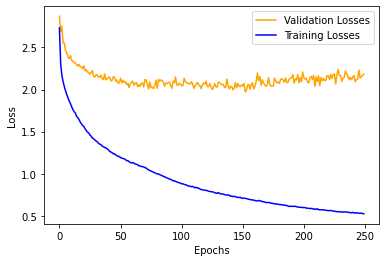

In [46]:
epochs = [u for u in range(NB_EPOCHS)]
plt.plot(epochs, validation_losses, label = 'Validation Losses', color = 'orange')
plt.plot(epochs, training_losses, label = 'Training Losses', color = 'blue')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [48]:
torch.save(obj=detr.state_dict(), f="detr_models/detr_{}epochs_{}batchsize_{}lr.pt".format(NB_EPOCHS, BATCH_SIZE, LEARNING_RATE))

#### **Test :** 

In the FB demos, I realized that in practice, outside of the training procedure, the predictions was kept only if their probability was superior to a certain proba, 0.7 in their examples.

In [ ]:
detr = DETR(num_classes=NB_INSTANCES_CLASSES, retrain_resnet=True, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6, N = 100,device=device)
torch.load_state_dict(torch.load("detr_models/detr_100epochs_32batchsize.pt"))

In [49]:
instances_val = CocoDetection_diy_bis(root = data_path_val, annFile = labels_path_val, size=(224,224))
instances_val_dataloader = DataLoader(instances_val, batch_size=5, shuffle=True, collate_fn = collate_fn_diy)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [50]:
images,labels = next(iter(instances_val_dataloader))

In [51]:
with torch.no_grad() :
    predictions = detr(images.cuda())

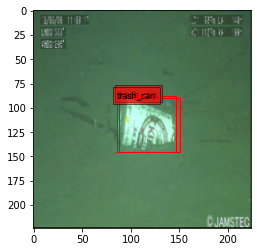

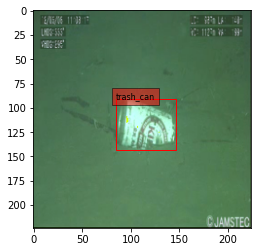

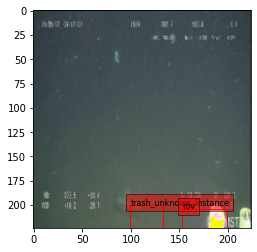

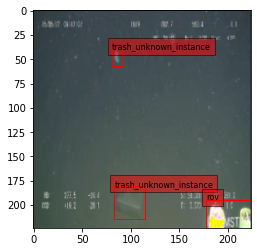

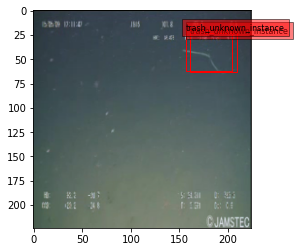

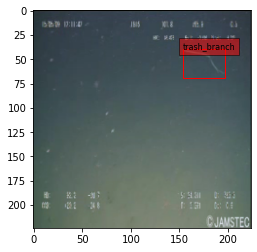

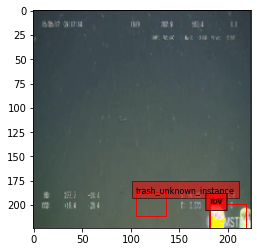

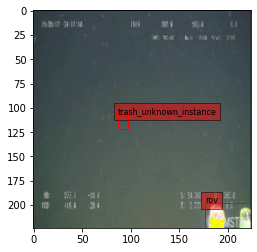

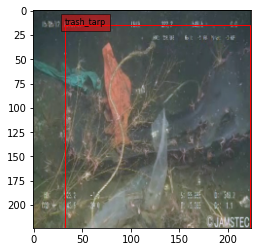

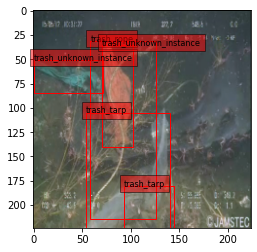

In [59]:
for i in range(5) : 
    plot_bounding_boxes_predictions(images, predictions,i, keep_pred = 0)
    plot_bounding_boxes(images,labels,i)
    

In [60]:
images,labels = next(iter(instances_val_dataloader))

In [61]:
with torch.no_grad() :
    predictions = detr(images.cuda())

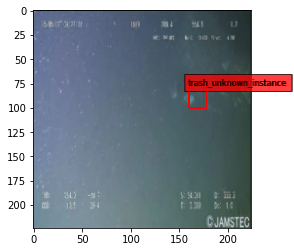

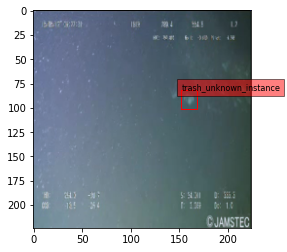

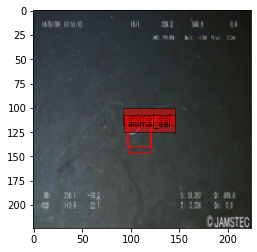

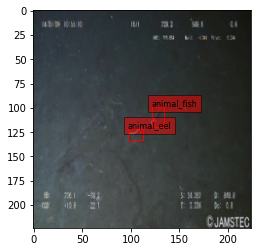

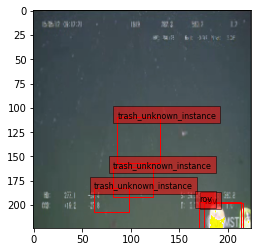

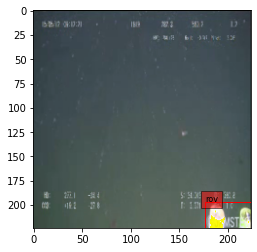

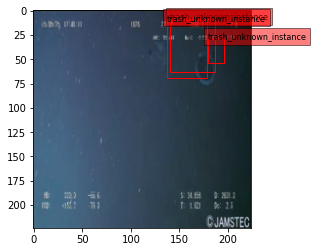

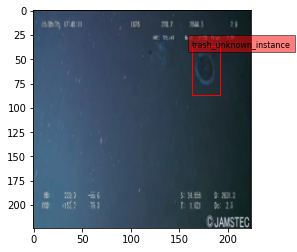

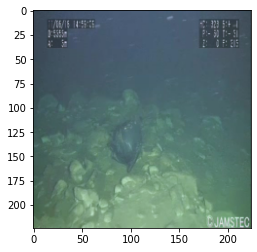

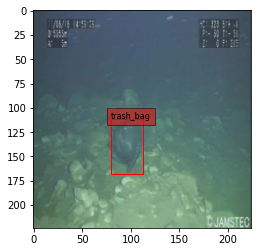

In [62]:
for i in range(5) : 
    plot_bounding_boxes_predictions(images, predictions,i, keep_pred = 0)
    plot_bounding_boxes(images,labels,i)
    

In [63]:
images,labels = next(iter(instances_val_dataloader))

In [64]:
with torch.no_grad() :
    predictions = detr(images.cuda())

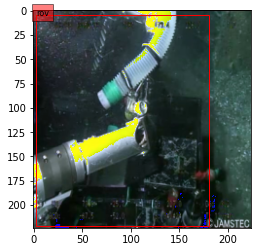

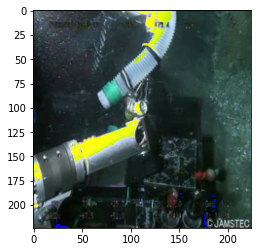

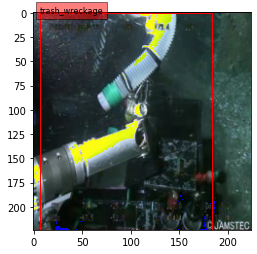

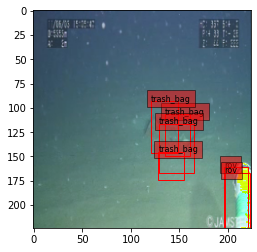

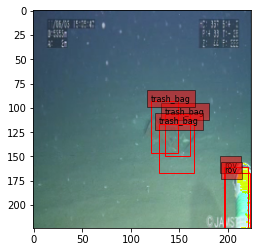

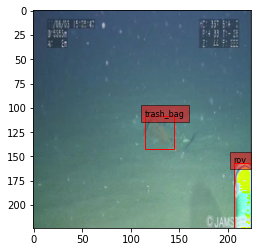

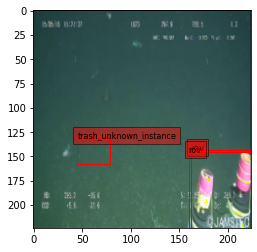

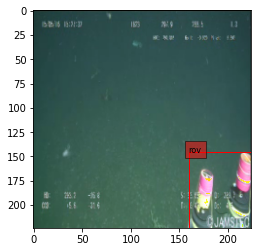

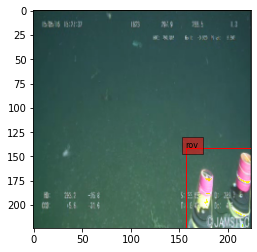

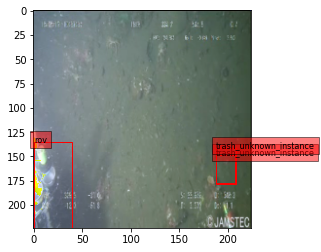

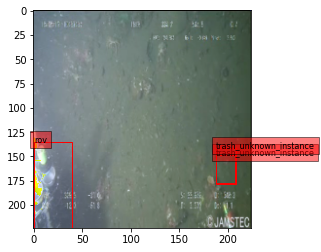

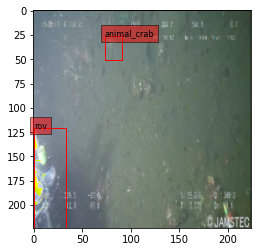

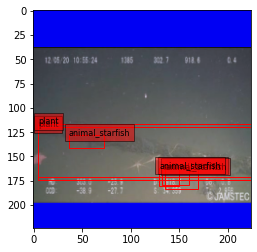

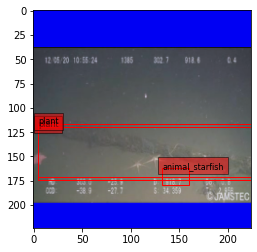

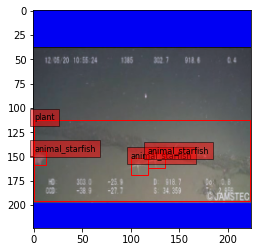

In [65]:
for i in range(5) : 
    plot_bounding_boxes_predictions(images, predictions,i, keep_pred = 0)
    plot_bounding_boxes_predictions(images, predictions,i, keep_pred = 0.6)
    plot_bounding_boxes(images,labels,i)


---

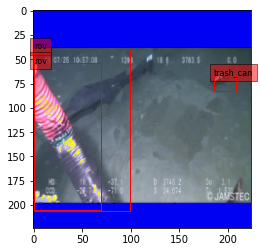

In [ ]:
plot_bounding_boxes_predictions(images, predictions,1, keep_pred = 0.8)

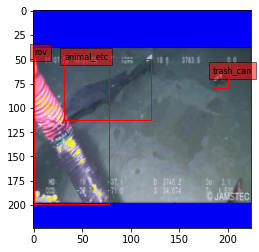

In [ ]:
plot_bounding_boxes(images,labels,1)

---

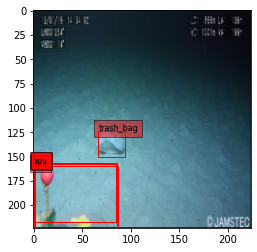

In [ ]:
plot_bounding_boxes_predictions(images, predictions,4)

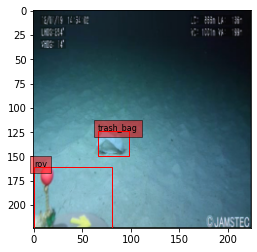

In [ ]:
plot_bounding_boxes(images,labels,4)

## DETR - Customization of a pre-trained DETR



Let try to use the pretrained version of the DETR available on FB github :

In [80]:
detr_fb = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)

Downloading: "https://github.com/facebookresearch/detr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

We will just have to modify the final prediction head for the categories, as our number of categories is different from theirs. We will froze the other parameters of the model :

In [81]:
detr_fb.class_embed

Linear(in_features=256, out_features=92, bias=True)

In [82]:
# for param in detr_fb.parameters(): 
#     param.requires_grad = False

In [83]:
detr_fb.class_embed = nn.Linear(in_features=256, out_features=23)

We now want to re train (only the prediction head part) on our images :

In [85]:
NB_EPOCHS = 250

BATCH_SIZE = 32
NB_INSTANCES_CLASSES = 22

LEARNING_RATE = 0.00001

LAMBDA_CATEGORY = 1
LAMBDA_IOU = 1
LAMBDA_1 = 1

In [86]:
detr_fb = detr_fb.to(device)
bipartite_matcher = Bipartite_Matching(lambda_category=LAMBDA_CATEGORY, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device= device)
optimizer = torch.optim.Adam(detr_fb.parameters(), lr=LEARNING_RATE)

In [88]:
detr_learnable_params = 0
for p in detr_fb.parameters() : 
    if p.requires_grad : 
        detr_learnable_params += p.numel() 
print('Total number of learnable parameters : ', detr_learnable_params)

Total number of learnable parameters :  41284635


In [89]:
for p in detr_fb.parameters() : 
    assert p.is_cuda

In [90]:
training_losses = []
validation_losses = []

for epoch in tqdm(range(NB_EPOCHS)) :

    print("-"*20)
    print("Epoch :",epoch)

    training_loss = 0.
   

    for batch_id, (images, labels) in enumerate(instances_train_dataloader):

        optimizer.zero_grad()
        images = images.to(device)
        
        # Prédictions du modèle : 
        predictions = detr_fb(images)
        
        # Loss : 
        indices_affectations = bipartite_matcher.forward(predictions, labels)

        loss = hungarian_loss(predictions, labels, indices_affectations, num_classes=NB_INSTANCES_CLASSES, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device=device)
        
        # Calcul de gradient :
        loss.backward()

        # 1 optimization step : 
        optimizer.step()
                
        # Training loss : 
        training_loss += loss.item() * len(labels)
        
        if batch_id % 10 == 0 and epoch % 10 == 0:
            print(f'Training loss on batch_id {batch_id} : {loss.item()}')
        
    # Validation loss : 
    val_loss = 0.
    with torch.no_grad() : 
        for batch_id, (images, labels) in enumerate(instances_val_dataloader):
            images = images.to(device) 

                # Prédictions du modèle : 
            predictions = detr_fb(images)

                # Loss : 
            indices_affectations = bipartite_matcher.forward(predictions, labels)

            loss = hungarian_loss(predictions, labels, indices_affectations, num_classes=NB_INSTANCES_CLASSES, lambda_iou=LAMBDA_IOU, lambda_1=LAMBDA_1, device=device)

            val_loss += loss.item() * len(labels)
    validation_losses.append(val_loss / NB_VAL_IMAGES)
    training_losses.append(training_loss / NB_TRAIN_IMAGES)
    

    print(f'=> Training loss at epoch {epoch} :', training_losses[-1])
    print(f'=> Validation loss at end of epoch {epoch} :', validation_losses[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

--------------------
Epoch : 0
Training loss on batch_id 0 : 5.449944972991943
Training loss on batch_id 10 : 5.083869457244873
Training loss on batch_id 20 : 4.848998546600342
Training loss on batch_id 30 : 4.540975570678711
Training loss on batch_id 40 : 4.321852684020996
Training loss on batch_id 50 : 4.143505096435547
Training loss on batch_id 60 : 4.002799987792969
Training loss on batch_id 70 : 3.797255516052246
Training loss on batch_id 80 : 3.4260687828063965
Training loss on batch_id 90 : 3.222898006439209
Training loss on batch_id 100 : 3.0356664657592773
Training loss on batch_id 110 : 2.8927884101867676
Training loss on batch_id 120 : 2.8259427547454834
Training loss on batch_id 130 : 2.5569725036621094
Training loss on batch_id 140 : 2.4268229007720947
Training loss on batch_id 150 : 2.237619400024414
Training loss on batch_id 160 : 2.355642557144165
Training loss on batch_id 170 : 2.294121503829956
Training loss on batch_id 180 : 2.011791706085205


  0%|          | 1/250 [01:58<8:13:11, 118.84s/it]

=> Training loss at epoch 0 : 3.4262341626694846
=> Validation loss at end of epoch 0 : 2.5936867842595266
--------------------
Epoch : 1


  1%|          | 2/250 [03:57<8:11:33, 118.93s/it]

=> Training loss at epoch 1 : 2.11498271701558
=> Validation loss at end of epoch 1 : 2.2921312309496282
--------------------
Epoch : 2


  1%|          | 3/250 [05:56<8:09:00, 118.79s/it]

=> Training loss at epoch 2 : 1.8547366046551723
=> Validation loss at end of epoch 2 : 2.1142196725946776
--------------------
Epoch : 3


  2%|▏         | 4/250 [07:54<8:05:36, 118.44s/it]

=> Training loss at epoch 3 : 1.7283209096864542
=> Validation loss at end of epoch 3 : 1.986868168960578
--------------------
Epoch : 4


  2%|▏         | 5/250 [09:52<8:02:37, 118.20s/it]

=> Training loss at epoch 4 : 1.6265123512365556
=> Validation loss at end of epoch 4 : 1.9715838652646531
--------------------
Epoch : 5


  2%|▏         | 6/250 [11:49<7:59:20, 117.87s/it]

=> Training loss at epoch 5 : 1.5720827130571635
=> Validation loss at end of epoch 5 : 1.881708331594492
--------------------
Epoch : 6


  3%|▎         | 7/250 [13:47<7:57:24, 117.88s/it]

=> Training loss at epoch 6 : 1.5152475943962405
=> Validation loss at end of epoch 6 : 1.8456681886754456
--------------------
Epoch : 7


  3%|▎         | 8/250 [15:47<7:58:15, 118.58s/it]

=> Training loss at epoch 7 : 1.4635757611786542
=> Validation loss at end of epoch 7 : 1.8146845373571074
--------------------
Epoch : 8


  4%|▎         | 9/250 [17:45<7:56:11, 118.55s/it]

=> Training loss at epoch 8 : 1.4093215906610197
=> Validation loss at end of epoch 8 : 1.7635386563844024
--------------------
Epoch : 9


  4%|▍         | 10/250 [19:43<7:53:27, 118.37s/it]

=> Training loss at epoch 9 : 1.375102764323833
=> Validation loss at end of epoch 9 : 1.7425784829812354
--------------------
Epoch : 10
Training loss on batch_id 0 : 1.632057785987854
Training loss on batch_id 10 : 1.2552560567855835
Training loss on batch_id 20 : 1.2572224140167236
Training loss on batch_id 30 : 1.4858622550964355
Training loss on batch_id 40 : 1.265446662902832
Training loss on batch_id 50 : 1.2555698156356812
Training loss on batch_id 60 : 1.1246819496154785
Training loss on batch_id 70 : 1.4847009181976318
Training loss on batch_id 80 : 1.536991834640503
Training loss on batch_id 90 : 1.250899314880371
Training loss on batch_id 100 : 1.301566243171692
Training loss on batch_id 110 : 1.6674003601074219
Training loss on batch_id 120 : 1.3544609546661377
Training loss on batch_id 130 : 1.5622923374176025
Training loss on batch_id 140 : 1.4785417318344116
Training loss on batch_id 150 : 1.3958775997161865
Training loss on batch_id 160 : 1.194065809249878
Training los

  4%|▍         | 11/250 [21:41<7:50:53, 118.22s/it]

=> Training loss at epoch 10 : 1.359196375758807
=> Validation loss at end of epoch 10 : 1.7246121209709147
--------------------
Epoch : 11


  5%|▍         | 12/250 [23:41<7:50:39, 118.65s/it]

=> Training loss at epoch 11 : 1.3717364096189468
=> Validation loss at end of epoch 11 : 1.7148815355512923
--------------------
Epoch : 12


  5%|▌         | 13/250 [25:39<7:48:37, 118.64s/it]

=> Training loss at epoch 12 : 1.3150658036103842
=> Validation loss at end of epoch 12 : 1.6717147790772455
--------------------
Epoch : 13


  6%|▌         | 14/250 [27:38<7:46:12, 118.53s/it]

=> Training loss at epoch 13 : 1.2818666942632602
=> Validation loss at end of epoch 13 : 1.6539733607870866
--------------------
Epoch : 14


  6%|▌         | 15/250 [29:36<7:43:52, 118.44s/it]

=> Training loss at epoch 14 : 1.2583338013190626
=> Validation loss at end of epoch 14 : 1.6384566233484457
--------------------
Epoch : 15


  6%|▋         | 16/250 [31:33<7:40:44, 118.14s/it]

=> Training loss at epoch 15 : 1.242767195414632
=> Validation loss at end of epoch 15 : 1.6409929453443213
--------------------
Epoch : 16


  7%|▋         | 17/250 [33:33<7:41:02, 118.72s/it]

=> Training loss at epoch 16 : 1.2284084187591755
=> Validation loss at end of epoch 16 : 1.6234292424338324
--------------------
Epoch : 17


  7%|▋         | 18/250 [35:32<7:39:00, 118.71s/it]

=> Training loss at epoch 17 : 1.2068904324788645
=> Validation loss at end of epoch 17 : 1.5896076008144835
--------------------
Epoch : 18


  8%|▊         | 19/250 [37:30<7:36:35, 118.60s/it]

=> Training loss at epoch 18 : 1.1742504744517932
=> Validation loss at end of epoch 18 : 1.5649036933467402
--------------------
Epoch : 19


  8%|▊         | 20/250 [39:28<7:33:47, 118.38s/it]

=> Training loss at epoch 19 : 1.1945503510233793
=> Validation loss at end of epoch 19 : 1.5766334944740004
--------------------
Epoch : 20
Training loss on batch_id 0 : 1.1998928785324097
Training loss on batch_id 10 : 1.1248271465301514
Training loss on batch_id 20 : 1.1402995586395264
Training loss on batch_id 30 : 1.0916109085083008
Training loss on batch_id 40 : 1.080592155456543
Training loss on batch_id 50 : 1.0730282068252563
Training loss on batch_id 60 : 1.0396974086761475
Training loss on batch_id 70 : 1.1748075485229492
Training loss on batch_id 80 : 1.3706996440887451
Training loss on batch_id 90 : 1.012639045715332
Training loss on batch_id 100 : 1.3015451431274414
Training loss on batch_id 110 : 1.262986660003662
Training loss on batch_id 120 : 1.0963910818099976
Training loss on batch_id 130 : 1.100003957748413
Training loss on batch_id 140 : 1.0902113914489746
Training loss on batch_id 150 : 1.0151046514511108
Training loss on batch_id 160 : 1.129530906677246
Training

  8%|▊         | 21/250 [41:26<7:31:34, 118.32s/it]

=> Training loss at epoch 20 : 1.1637581213190844
=> Validation loss at end of epoch 20 : 1.5630780501581838
--------------------
Epoch : 21


  9%|▉         | 22/250 [43:25<7:29:41, 118.34s/it]

=> Training loss at epoch 21 : 1.139013376760758
=> Validation loss at end of epoch 21 : 1.5356741058587404
--------------------
Epoch : 22


  9%|▉         | 23/250 [45:23<7:27:51, 118.38s/it]

=> Training loss at epoch 22 : 1.1158476902253354
=> Validation loss at end of epoch 22 : 1.5292890797829566
--------------------
Epoch : 23


 10%|▉         | 24/250 [47:22<7:26:42, 118.60s/it]

=> Training loss at epoch 23 : 1.1154195134932603
=> Validation loss at end of epoch 23 : 1.5282833272722771
--------------------
Epoch : 24


 10%|█         | 25/250 [49:21<7:24:11, 118.45s/it]

=> Training loss at epoch 24 : 1.1101388217787653
=> Validation loss at end of epoch 24 : 1.5328088304532956
--------------------
Epoch : 25


 10%|█         | 26/250 [51:18<7:21:20, 118.22s/it]

=> Training loss at epoch 25 : 1.104010362941572
=> Validation loss at end of epoch 25 : 1.5566829993294546
--------------------
Epoch : 26


 11%|█         | 27/250 [53:16<7:19:04, 118.14s/it]

=> Training loss at epoch 26 : 1.1128512339265701
=> Validation loss at end of epoch 26 : 1.518657905544108
--------------------
Epoch : 27


 11%|█         | 28/250 [55:15<7:17:27, 118.23s/it]

=> Training loss at epoch 27 : 1.0965937900032177
=> Validation loss at end of epoch 27 : 1.4882884995253478
--------------------
Epoch : 28


 12%|█▏        | 29/250 [57:11<7:13:45, 117.76s/it]

=> Training loss at epoch 28 : 1.0589483521540894
=> Validation loss at end of epoch 28 : 1.478911540252599
--------------------
Epoch : 29


 12%|█▏        | 30/250 [59:09<7:11:44, 117.75s/it]

=> Training loss at epoch 29 : 1.0355872857698407
=> Validation loss at end of epoch 29 : 1.4455920808608365
--------------------
Epoch : 30
Training loss on batch_id 0 : 1.2924296855926514
Training loss on batch_id 10 : 1.017480492591858
Training loss on batch_id 20 : 1.0195860862731934
Training loss on batch_id 30 : 0.9162020683288574
Training loss on batch_id 40 : 1.1073060035705566
Training loss on batch_id 50 : 1.2119629383087158
Training loss on batch_id 60 : 0.8316646218299866
Training loss on batch_id 70 : 1.036807894706726
Training loss on batch_id 80 : 1.088218331336975
Training loss on batch_id 90 : 1.2202975749969482
Training loss on batch_id 100 : 1.2365562915802002
Training loss on batch_id 110 : 1.0791563987731934
Training loss on batch_id 120 : 1.1808520555496216
Training loss on batch_id 130 : 0.897749125957489
Training loss on batch_id 140 : 0.8855640888214111
Training loss on batch_id 150 : 0.9696285724639893
Training loss on batch_id 160 : 0.8112103939056396
Trainin

 12%|█▏        | 31/250 [1:01:07<7:10:07, 117.84s/it]

=> Training loss at epoch 30 : 1.0307189960078769
=> Validation loss at end of epoch 30 : 1.4375274725966383
--------------------
Epoch : 31


 13%|█▎        | 32/250 [1:03:05<7:08:12, 117.86s/it]

=> Training loss at epoch 31 : 1.028745725758294
=> Validation loss at end of epoch 31 : 1.4481446742491817
--------------------
Epoch : 32


 13%|█▎        | 33/250 [1:05:03<7:06:41, 117.98s/it]

=> Training loss at epoch 32 : 1.0276871128113725
=> Validation loss at end of epoch 32 : 1.5327959249824052
--------------------
Epoch : 33


 14%|█▎        | 34/250 [1:07:01<7:04:49, 118.01s/it]

=> Training loss at epoch 33 : 1.0930621586844436
=> Validation loss at end of epoch 33 : 1.4977888271615312
--------------------
Epoch : 34


 14%|█▍        | 35/250 [1:08:59<7:02:48, 117.99s/it]

=> Training loss at epoch 34 : 1.0494715150485625
=> Validation loss at end of epoch 34 : 1.4424793404293974
--------------------
Epoch : 35


 14%|█▍        | 36/250 [1:10:57<7:00:37, 117.93s/it]

=> Training loss at epoch 35 : 1.0207906014646073
=> Validation loss at end of epoch 35 : 1.4070731575008881
--------------------
Epoch : 36


 15%|█▍        | 37/250 [1:12:55<6:58:32, 117.90s/it]

=> Training loss at epoch 36 : 0.9846636320280813
=> Validation loss at end of epoch 36 : 1.4104299102540419
--------------------
Epoch : 37


 15%|█▌        | 38/250 [1:14:53<6:56:55, 118.00s/it]

=> Training loss at epoch 37 : 0.9602854684277792
=> Validation loss at end of epoch 37 : 1.3737676546380326
--------------------
Epoch : 38


 16%|█▌        | 39/250 [1:16:51<6:54:58, 118.00s/it]

=> Training loss at epoch 38 : 0.9699541670767021
=> Validation loss at end of epoch 38 : 1.480585199963454
--------------------
Epoch : 39


 16%|█▌        | 40/250 [1:18:49<6:53:02, 118.01s/it]

=> Training loss at epoch 39 : 1.0191162154975255
=> Validation loss at end of epoch 39 : 1.4305145885493304
--------------------
Epoch : 40
Training loss on batch_id 0 : 1.3427205085754395
Training loss on batch_id 10 : 1.4258654117584229
Training loss on batch_id 20 : 0.8790088891983032
Training loss on batch_id 30 : 1.0850321054458618
Training loss on batch_id 40 : 0.9122110605239868
Training loss on batch_id 50 : 0.9664608240127563
Training loss on batch_id 60 : 1.0387704372406006
Training loss on batch_id 70 : 0.9434928297996521
Training loss on batch_id 80 : 0.8652889728546143
Training loss on batch_id 90 : 0.8769054412841797
Training loss on batch_id 100 : 0.9374828338623047
Training loss on batch_id 110 : 1.0715711116790771
Training loss on batch_id 120 : 1.2380807399749756
Training loss on batch_id 130 : 0.8185691237449646
Training loss on batch_id 140 : 0.9398403763771057
Training loss on batch_id 150 : 0.7287721037864685
Training loss on batch_id 160 : 1.0084514617919922
Tra

 16%|█▋        | 41/250 [1:20:47<6:50:56, 117.97s/it]

=> Training loss at epoch 40 : 0.9706606013069247
=> Validation loss at end of epoch 40 : 1.3885877737816044
--------------------
Epoch : 41


 17%|█▋        | 42/250 [1:22:45<6:48:47, 117.92s/it]

=> Training loss at epoch 41 : 0.9345561769906883
=> Validation loss at end of epoch 41 : 1.374270349922862
--------------------
Epoch : 42


 17%|█▋        | 43/250 [1:24:43<6:46:50, 117.93s/it]

=> Training loss at epoch 42 : 0.9165486508131224
=> Validation loss at end of epoch 42 : 1.3543646963347324
--------------------
Epoch : 43


 18%|█▊        | 44/250 [1:26:41<6:45:17, 118.04s/it]

=> Training loss at epoch 43 : 0.9143762309789067
=> Validation loss at end of epoch 43 : 1.3774227628836762
--------------------
Epoch : 44


 18%|█▊        | 45/250 [1:28:39<6:43:06, 117.98s/it]

=> Training loss at epoch 44 : 0.895263455922409
=> Validation loss at end of epoch 44 : 1.337163900539162
--------------------
Epoch : 45


 18%|█▊        | 46/250 [1:30:37<6:41:29, 118.09s/it]

=> Training loss at epoch 45 : 0.8719337945719544
=> Validation loss at end of epoch 45 : 1.3060170332036438
--------------------
Epoch : 46


 19%|█▉        | 47/250 [1:32:35<6:39:33, 118.09s/it]

=> Training loss at epoch 46 : 0.8577348389806377
=> Validation loss at end of epoch 46 : 1.3226191778752527
--------------------
Epoch : 47


 19%|█▉        | 48/250 [1:34:33<6:37:26, 118.05s/it]

=> Training loss at epoch 47 : 0.8421358249645438
=> Validation loss at end of epoch 47 : 1.2944382248801984
--------------------
Epoch : 48


 20%|█▉        | 49/250 [1:36:31<6:35:09, 117.96s/it]

=> Training loss at epoch 48 : 0.8191467061872238
=> Validation loss at end of epoch 48 : 1.2725176473441286
--------------------
Epoch : 49


 20%|██        | 50/250 [1:38:29<6:33:23, 118.02s/it]

=> Training loss at epoch 49 : 0.8036526802248534
=> Validation loss at end of epoch 49 : 1.2832889327196422
--------------------
Epoch : 50
Training loss on batch_id 0 : 1.0297796726226807
Training loss on batch_id 10 : 1.0159761905670166
Training loss on batch_id 20 : 0.6477290391921997
Training loss on batch_id 30 : 0.8755423426628113
Training loss on batch_id 40 : 0.8399815559387207
Training loss on batch_id 50 : 0.8575439453125
Training loss on batch_id 60 : 0.6120718717575073
Training loss on batch_id 70 : 0.6364140510559082
Training loss on batch_id 80 : 0.786899209022522
Training loss on batch_id 90 : 0.6742557883262634
Training loss on batch_id 100 : 0.697428822517395
Training loss on batch_id 110 : 0.8354810476303101
Training loss on batch_id 120 : 0.9912961721420288
Training loss on batch_id 130 : 0.7987191677093506
Training loss on batch_id 140 : 0.947737455368042
Training loss on batch_id 150 : 0.7900819778442383
Training loss on batch_id 160 : 0.9902703762054443
Training 

 20%|██        | 51/250 [1:40:27<6:31:37, 118.08s/it]

=> Training loss at epoch 50 : 0.834856082355298
=> Validation loss at end of epoch 50 : 1.2830177974784074
--------------------
Epoch : 51


 21%|██        | 52/250 [1:42:25<6:29:33, 118.05s/it]

=> Training loss at epoch 51 : 0.8264627312690094
=> Validation loss at end of epoch 51 : 1.3361250880810107
--------------------
Epoch : 52


 21%|██        | 53/250 [1:44:24<6:27:47, 118.11s/it]

=> Training loss at epoch 52 : 0.8347092880852833
=> Validation loss at end of epoch 52 : 1.278821523021176
--------------------
Epoch : 53


 22%|██▏       | 54/250 [1:46:22<6:25:46, 118.10s/it]

=> Training loss at epoch 53 : 0.8096503875713553
=> Validation loss at end of epoch 53 : 1.2857553602408198
--------------------
Epoch : 54


 22%|██▏       | 55/250 [1:48:20<6:23:33, 118.02s/it]

=> Training loss at epoch 54 : 0.7952705745252812
=> Validation loss at end of epoch 54 : 1.263551292880889
--------------------
Epoch : 55


 22%|██▏       | 56/250 [1:50:18<6:21:30, 117.99s/it]

=> Training loss at epoch 55 : 0.7694072060809092
=> Validation loss at end of epoch 55 : 1.2414064253010537
--------------------
Epoch : 56


 23%|██▎       | 57/250 [1:52:16<6:19:37, 118.02s/it]

=> Training loss at epoch 56 : 0.843254336618925
=> Validation loss at end of epoch 56 : 1.270585165558011
--------------------
Epoch : 57


 23%|██▎       | 58/250 [1:54:14<6:18:14, 118.20s/it]

=> Training loss at epoch 57 : 0.7824476995648968
=> Validation loss at end of epoch 57 : 1.239273921499693
--------------------
Epoch : 58


 24%|██▎       | 59/250 [1:56:12<6:16:13, 118.18s/it]

=> Training loss at epoch 58 : 0.7522334716384901
=> Validation loss at end of epoch 58 : 1.2059913501598156
--------------------
Epoch : 59


 24%|██▍       | 60/250 [1:58:10<6:14:04, 118.13s/it]

=> Training loss at epoch 59 : 0.7361634579750495
=> Validation loss at end of epoch 59 : 1.2062477125951074
--------------------
Epoch : 60
Training loss on batch_id 0 : 0.7309117317199707
Training loss on batch_id 10 : 0.7618908882141113
Training loss on batch_id 20 : 0.8319496512413025
Training loss on batch_id 30 : 0.7017533779144287
Training loss on batch_id 40 : 0.6828041076660156
Training loss on batch_id 50 : 0.7682725787162781
Training loss on batch_id 60 : 0.8122193813323975
Training loss on batch_id 70 : 0.8169043064117432
Training loss on batch_id 80 : 0.6941805481910706
Training loss on batch_id 90 : 0.7915277481079102
Training loss on batch_id 100 : 0.8235167860984802
Training loss on batch_id 110 : 0.7647631168365479
Training loss on batch_id 120 : 0.7144320011138916
Training loss on batch_id 130 : 0.8137503862380981
Training loss on batch_id 140 : 0.5924818515777588
Training loss on batch_id 150 : 0.7565556764602661
Training loss on batch_id 160 : 0.7094377279281616
Tra

 24%|██▍       | 61/250 [2:00:08<6:11:58, 118.09s/it]

=> Training loss at epoch 60 : 0.7244722931324109
=> Validation loss at end of epoch 60 : 1.2087509916362913
--------------------
Epoch : 61


 25%|██▍       | 62/250 [2:02:06<6:09:43, 118.00s/it]

=> Training loss at epoch 61 : 0.7069147924303714
=> Validation loss at end of epoch 61 : 1.1867844361061621
--------------------
Epoch : 62


 25%|██▌       | 63/250 [2:04:05<6:08:43, 118.31s/it]

=> Training loss at epoch 62 : 0.6912673687109354
=> Validation loss at end of epoch 62 : 1.1826804295870774
--------------------
Epoch : 63


 26%|██▌       | 64/250 [2:06:04<6:06:59, 118.38s/it]

=> Training loss at epoch 63 : 0.6794380627087296
=> Validation loss at end of epoch 63 : 1.1725880743476134
--------------------
Epoch : 64


 26%|██▌       | 65/250 [2:08:01<6:04:05, 118.08s/it]

=> Training loss at epoch 64 : 0.6747181399833635
=> Validation loss at end of epoch 64 : 1.159056622901998
--------------------
Epoch : 65


 26%|██▋       | 66/250 [2:10:00<6:03:18, 118.47s/it]

=> Training loss at epoch 65 : 0.6682180226389672
=> Validation loss at end of epoch 65 : 1.190967465081003
--------------------
Epoch : 66


 27%|██▋       | 67/250 [2:11:59<6:01:17, 118.45s/it]

=> Training loss at epoch 66 : 0.6601345647000519
=> Validation loss at end of epoch 66 : 1.166318802518645
--------------------
Epoch : 67


 27%|██▋       | 68/250 [2:13:57<5:59:13, 118.43s/it]

=> Training loss at epoch 67 : 0.6338092851815692
=> Validation loss at end of epoch 67 : 1.1554196744819465
--------------------
Epoch : 68


 28%|██▊       | 69/250 [2:15:55<5:57:02, 118.36s/it]

=> Training loss at epoch 68 : 0.6259236876864327
=> Validation loss at end of epoch 68 : 1.1468921335707982
--------------------
Epoch : 69


 28%|██▊       | 70/250 [2:17:53<5:54:09, 118.05s/it]

=> Training loss at epoch 69 : 0.6309568004380153
=> Validation loss at end of epoch 69 : 1.1354815324909706
--------------------
Epoch : 70
Training loss on batch_id 0 : 0.5430588722229004
Training loss on batch_id 10 : 0.6216275691986084
Training loss on batch_id 20 : 0.4929566979408264
Training loss on batch_id 30 : 0.7100139856338501
Training loss on batch_id 40 : 0.4803251028060913
Training loss on batch_id 50 : 0.6312224864959717
Training loss on batch_id 60 : 0.6156018972396851
Training loss on batch_id 70 : 0.6781447529792786
Training loss on batch_id 80 : 0.7113598585128784
Training loss on batch_id 90 : 0.6111206412315369
Training loss on batch_id 100 : 0.6007912755012512
Training loss on batch_id 110 : 0.8720247745513916
Training loss on batch_id 120 : 0.5799150466918945
Training loss on batch_id 130 : 0.5519219636917114
Training loss on batch_id 140 : 0.719556450843811
Training loss on batch_id 150 : 0.5594781637191772
Training loss on batch_id 160 : 0.6290884613990784
Trai

 28%|██▊       | 71/250 [2:19:51<5:52:11, 118.05s/it]

=> Training loss at epoch 70 : 0.6360739825092262
=> Validation loss at end of epoch 70 : 1.149603984827775
--------------------
Epoch : 71


 29%|██▉       | 72/250 [2:21:48<5:49:50, 117.93s/it]

=> Training loss at epoch 71 : 0.625838602847141
=> Validation loss at end of epoch 71 : 1.1615107621227854
--------------------
Epoch : 72


 29%|██▉       | 73/250 [2:23:47<5:48:08, 118.01s/it]

=> Training loss at epoch 72 : 0.613975879719507
=> Validation loss at end of epoch 72 : 1.1358511005418657
--------------------
Epoch : 73


 30%|██▉       | 74/250 [2:25:46<5:47:10, 118.35s/it]

=> Training loss at epoch 73 : 0.6046443772335635
=> Validation loss at end of epoch 73 : 1.148467064839191
--------------------
Epoch : 74


 30%|███       | 75/250 [2:27:44<5:45:20, 118.40s/it]

=> Training loss at epoch 74 : 0.5996071815982105
=> Validation loss at end of epoch 74 : 1.1430455851835486
--------------------
Epoch : 75


 30%|███       | 76/250 [2:29:42<5:43:06, 118.31s/it]

=> Training loss at epoch 75 : 0.594283954269711
=> Validation loss at end of epoch 75 : 1.1574661318852575
--------------------
Epoch : 76


 31%|███       | 77/250 [2:31:41<5:41:07, 118.31s/it]

=> Training loss at epoch 76 : 0.5805866760452818
=> Validation loss at end of epoch 76 : 1.1362065108267245
--------------------
Epoch : 77


 31%|███       | 78/250 [2:33:39<5:39:19, 118.37s/it]

=> Training loss at epoch 77 : 0.5784787417490033
=> Validation loss at end of epoch 77 : 1.1172874147411835
--------------------
Epoch : 78


 32%|███▏      | 79/250 [2:35:37<5:36:56, 118.23s/it]

=> Training loss at epoch 78 : 0.5709499835968017
=> Validation loss at end of epoch 78 : 1.131926614560557
--------------------
Epoch : 79


 32%|███▏      | 80/250 [2:37:35<5:35:02, 118.25s/it]

=> Training loss at epoch 79 : 0.5987531943844059
=> Validation loss at end of epoch 79 : 1.1358647759883636
--------------------
Epoch : 80
Training loss on batch_id 0 : 0.6072642803192139
Training loss on batch_id 10 : 0.4166136384010315
Training loss on batch_id 20 : 0.5144405364990234
Training loss on batch_id 30 : 0.48983216285705566
Training loss on batch_id 40 : 0.6077591776847839
Training loss on batch_id 50 : 0.5641037225723267
Training loss on batch_id 60 : 0.685335636138916
Training loss on batch_id 70 : 0.5708343982696533
Training loss on batch_id 80 : 0.4631209671497345
Training loss on batch_id 90 : 0.6329134702682495
Training loss on batch_id 100 : 0.5635609030723572
Training loss on batch_id 110 : 0.5906513929367065
Training loss on batch_id 120 : 0.506475031375885
Training loss on batch_id 130 : 0.6518189907073975
Training loss on batch_id 140 : 0.5828558206558228
Training loss on batch_id 150 : 0.5440967679023743
Training loss on batch_id 160 : 0.5391063690185547
Trai

 32%|███▏      | 81/250 [2:39:32<5:31:47, 117.79s/it]

=> Training loss at epoch 80 : 0.5664506961173099
=> Validation loss at end of epoch 80 : 1.1079929466858676
--------------------
Epoch : 81


 33%|███▎      | 82/250 [2:41:30<5:30:06, 117.90s/it]

=> Training loss at epoch 81 : 0.5613121644190688
=> Validation loss at end of epoch 81 : 1.1097667039012327
--------------------
Epoch : 82


 33%|███▎      | 83/250 [2:43:28<5:27:50, 117.78s/it]

=> Training loss at epoch 82 : 0.5608423703579695
=> Validation loss at end of epoch 82 : 1.1060565062315442
--------------------
Epoch : 83


 34%|███▎      | 84/250 [2:45:26<5:25:58, 117.82s/it]

=> Training loss at epoch 83 : 0.5325451291600044
=> Validation loss at end of epoch 83 : 1.07452774325868
--------------------
Epoch : 84


 34%|███▍      | 85/250 [2:47:24<5:24:25, 117.97s/it]

=> Training loss at epoch 84 : 0.5270307662559754
=> Validation loss at end of epoch 84 : 1.079461539087861
--------------------
Epoch : 85


 34%|███▍      | 86/250 [2:49:22<5:22:43, 118.07s/it]

=> Training loss at epoch 85 : 0.5276034503560959
=> Validation loss at end of epoch 85 : 1.1287550024603799
--------------------
Epoch : 86


 35%|███▍      | 87/250 [2:51:21<5:20:49, 118.09s/it]

=> Training loss at epoch 86 : 0.5231344931202296
=> Validation loss at end of epoch 86 : 1.0933067871106636
--------------------
Epoch : 87


 35%|███▌      | 88/250 [2:53:19<5:19:08, 118.20s/it]

=> Training loss at epoch 87 : 0.5118403896996528
=> Validation loss at end of epoch 87 : 1.0983530069395264
--------------------
Epoch : 88


 36%|███▌      | 89/250 [2:55:17<5:17:18, 118.25s/it]

=> Training loss at epoch 88 : 0.5166112084921392
=> Validation loss at end of epoch 88 : 1.194617610629372
--------------------
Epoch : 89


 36%|███▌      | 90/250 [2:57:15<5:15:12, 118.21s/it]

=> Training loss at epoch 89 : 0.5456955157717888
=> Validation loss at end of epoch 89 : 1.1034218882516662
--------------------
Epoch : 90
Training loss on batch_id 0 : 0.5631759762763977
Training loss on batch_id 10 : 0.5793435573577881
Training loss on batch_id 20 : 0.5713367462158203
Training loss on batch_id 30 : 0.5037930011749268
Training loss on batch_id 40 : 0.6836133003234863
Training loss on batch_id 50 : 0.529766857624054
Training loss on batch_id 60 : 0.604914128780365
Training loss on batch_id 70 : 0.34908729791641235
Training loss on batch_id 80 : 0.5596879720687866
Training loss on batch_id 90 : 0.46812736988067627
Training loss on batch_id 100 : 0.4174672067165375
Training loss on batch_id 110 : 0.5963491201400757
Training loss on batch_id 120 : 0.4519200623035431
Training loss on batch_id 130 : 0.6420845985412598
Training loss on batch_id 140 : 0.5547481179237366
Training loss on batch_id 150 : 0.7985566258430481
Training loss on batch_id 160 : 0.9790022373199463
Tra

 36%|███▋      | 91/250 [2:59:14<5:13:32, 118.32s/it]

=> Training loss at epoch 90 : 0.5921937555885473
=> Validation loss at end of epoch 90 : 1.2295974730769759
--------------------
Epoch : 91


 37%|███▋      | 92/250 [3:01:11<5:10:51, 118.05s/it]

=> Training loss at epoch 91 : 0.6188451846768221
=> Validation loss at end of epoch 91 : 1.1280937453613349
--------------------
Epoch : 92


 37%|███▋      | 93/250 [3:03:08<5:07:59, 117.70s/it]

=> Training loss at epoch 92 : 0.5625498406275775
=> Validation loss at end of epoch 92 : 1.1005502909084144
--------------------
Epoch : 93


 38%|███▊      | 94/250 [3:05:05<5:05:24, 117.47s/it]

=> Training loss at epoch 93 : 0.5328049135719167
=> Validation loss at end of epoch 93 : 1.0914902103498072
--------------------
Epoch : 94


 38%|███▊      | 95/250 [3:07:04<5:04:14, 117.77s/it]

=> Training loss at epoch 94 : 0.514855568338207
=> Validation loss at end of epoch 94 : 1.1112960829304526
--------------------
Epoch : 95


 38%|███▊      | 96/250 [3:09:02<5:02:31, 117.87s/it]

=> Training loss at epoch 95 : 0.5041054303893744
=> Validation loss at end of epoch 95 : 1.124837733837658
--------------------
Epoch : 96


 39%|███▉      | 97/250 [3:11:00<5:00:48, 117.96s/it]

=> Training loss at epoch 96 : 0.4979877217781023
=> Validation loss at end of epoch 96 : 1.0809953608196927
--------------------
Epoch : 97


 39%|███▉      | 98/250 [3:12:58<4:58:53, 117.98s/it]

=> Training loss at epoch 97 : 0.49557039781925805
=> Validation loss at end of epoch 97 : 1.0867596516790032
--------------------
Epoch : 98


 40%|███▉      | 99/250 [3:14:57<4:57:30, 118.22s/it]

=> Training loss at epoch 98 : 0.4969269937065546
=> Validation loss at end of epoch 98 : 1.1065415302462025
--------------------
Epoch : 99


 40%|████      | 100/250 [3:16:55<4:55:48, 118.33s/it]

=> Training loss at epoch 99 : 0.4876235013448396
=> Validation loss at end of epoch 99 : 1.107654039612415
--------------------
Epoch : 100
Training loss on batch_id 0 : 0.33363932371139526
Training loss on batch_id 10 : 0.39509356021881104
Training loss on batch_id 20 : 0.48989182710647583
Training loss on batch_id 30 : 0.4929995834827423
Training loss on batch_id 40 : 0.5138756632804871
Training loss on batch_id 50 : 0.40802982449531555
Training loss on batch_id 60 : 0.6034784913063049
Training loss on batch_id 70 : 0.3835550546646118
Training loss on batch_id 80 : 0.44483017921447754
Training loss on batch_id 90 : 0.47607094049453735
Training loss on batch_id 100 : 0.5148782730102539
Training loss on batch_id 110 : 0.42105650901794434
Training loss on batch_id 120 : 0.41779038310050964
Training loss on batch_id 130 : 0.47202908992767334
Training loss on batch_id 140 : 0.42245733737945557
Training loss on batch_id 150 : 0.7737127542495728
Training loss on batch_id 160 : 0.5732629299

 40%|████      | 101/250 [3:18:54<4:53:43, 118.28s/it]

=> Training loss at epoch 100 : 0.4770666369798256
=> Validation loss at end of epoch 100 : 1.089050759828496
--------------------
Epoch : 101


 41%|████      | 102/250 [3:20:52<4:52:10, 118.45s/it]

=> Training loss at epoch 101 : 0.4616434669848424
=> Validation loss at end of epoch 101 : 1.073177573129002
--------------------
Epoch : 102


 41%|████      | 103/250 [3:22:50<4:49:44, 118.26s/it]

=> Training loss at epoch 102 : 0.4588009032796261
=> Validation loss at end of epoch 102 : 1.0717661742708844
--------------------
Epoch : 103


 42%|████▏     | 104/250 [3:24:48<4:47:38, 118.21s/it]

=> Training loss at epoch 103 : 0.4511282697062009
=> Validation loss at end of epoch 103 : 1.0735811549835654
--------------------
Epoch : 104


 42%|████▏     | 105/250 [3:26:46<4:45:12, 118.02s/it]

=> Training loss at epoch 104 : 0.44795368619920395
=> Validation loss at end of epoch 104 : 1.0528180809933514
--------------------
Epoch : 105


 42%|████▏     | 106/250 [3:28:44<4:43:27, 118.11s/it]

=> Training loss at epoch 105 : 0.4401742195060994
=> Validation loss at end of epoch 105 : 1.0873372282998501
--------------------
Epoch : 106


 43%|████▎     | 107/250 [3:30:42<4:41:01, 117.91s/it]

=> Training loss at epoch 106 : 0.4447053833825472
=> Validation loss at end of epoch 106 : 1.085245007494791
--------------------
Epoch : 107


 43%|████▎     | 108/250 [3:32:40<4:39:13, 117.98s/it]

=> Training loss at epoch 107 : 0.43238543398303625
=> Validation loss at end of epoch 107 : 1.0948069577593333
--------------------
Epoch : 108


 44%|████▎     | 109/250 [3:34:38<4:37:29, 118.08s/it]

=> Training loss at epoch 108 : 0.4310973468636641
=> Validation loss at end of epoch 108 : 1.1013939306854474
--------------------
Epoch : 109


 44%|████▍     | 110/250 [3:36:36<4:35:42, 118.16s/it]

=> Training loss at epoch 109 : 0.44255892777383965
=> Validation loss at end of epoch 109 : 1.0914240443612975
--------------------
Epoch : 110
Training loss on batch_id 0 : 0.34580278396606445
Training loss on batch_id 10 : 0.3170742690563202
Training loss on batch_id 20 : 0.5378849506378174
Training loss on batch_id 30 : 0.4009512662887573
Training loss on batch_id 40 : 0.3905811309814453
Training loss on batch_id 50 : 0.47154462337493896
Training loss on batch_id 60 : 0.4578057527542114
Training loss on batch_id 70 : 0.579917848110199
Training loss on batch_id 80 : 0.47581106424331665
Training loss on batch_id 90 : 0.4006907343864441
Training loss on batch_id 100 : 0.4102603793144226
Training loss on batch_id 110 : 0.4647553265094757
Training loss on batch_id 120 : 0.37551528215408325
Training loss on batch_id 130 : 0.32204389572143555
Training loss on batch_id 140 : 0.45118415355682373
Training loss on batch_id 150 : 0.43397775292396545
Training loss on batch_id 160 : 0.3729630410

 44%|████▍     | 111/250 [3:38:35<4:33:47, 118.18s/it]

=> Training loss at epoch 110 : 0.43085383347804546
=> Validation loss at end of epoch 110 : 1.0752341284009823
--------------------
Epoch : 111


 45%|████▍     | 112/250 [3:40:33<4:32:05, 118.30s/it]

=> Training loss at epoch 111 : 0.4246603491968688
=> Validation loss at end of epoch 111 : 1.0845153572617559
--------------------
Epoch : 112


 45%|████▌     | 113/250 [3:42:32<4:30:44, 118.57s/it]

=> Training loss at epoch 112 : 0.4542571661694425
=> Validation loss at end of epoch 112 : 1.0880751167574236
--------------------
Epoch : 113


 46%|████▌     | 114/250 [3:44:30<4:28:09, 118.31s/it]

=> Training loss at epoch 113 : 0.44461450526661256
=> Validation loss at end of epoch 113 : 1.0997754396722954
--------------------
Epoch : 114


 46%|████▌     | 115/250 [3:46:29<4:26:40, 118.52s/it]

=> Training loss at epoch 114 : 0.44094215696347416
=> Validation loss at end of epoch 114 : 1.1153913419092856
--------------------
Epoch : 115


 46%|████▋     | 116/250 [3:48:26<4:23:36, 118.03s/it]

=> Training loss at epoch 115 : 0.43446718262721956
=> Validation loss at end of epoch 115 : 1.0778404365909962
--------------------
Epoch : 116


 47%|████▋     | 117/250 [3:50:24<4:21:42, 118.07s/it]

=> Training loss at epoch 116 : 0.4389279933921188
=> Validation loss at end of epoch 116 : 1.0601671977778986
--------------------
Epoch : 117


 47%|████▋     | 118/250 [3:52:22<4:19:49, 118.10s/it]

=> Training loss at epoch 117 : 0.43765171520590096
=> Validation loss at end of epoch 117 : 1.0394646604370843
--------------------
Epoch : 118


 48%|████▊     | 119/250 [3:54:21<4:18:01, 118.18s/it]

=> Training loss at epoch 118 : 0.43159803516198464
=> Validation loss at end of epoch 118 : 1.1525746894173758
--------------------
Epoch : 119


 48%|████▊     | 120/250 [3:56:19<4:15:56, 118.13s/it]

=> Training loss at epoch 119 : 0.44108810930928216
=> Validation loss at end of epoch 119 : 1.0912286840320777
--------------------
Epoch : 120
Training loss on batch_id 0 : 0.6230645775794983
Training loss on batch_id 10 : 0.45967334508895874
Training loss on batch_id 20 : 0.3997608423233032
Training loss on batch_id 30 : 0.5396930575370789
Training loss on batch_id 40 : 0.39352408051490784
Training loss on batch_id 50 : 0.43067383766174316
Training loss on batch_id 60 : 0.34052035212516785
Training loss on batch_id 70 : 0.5274774432182312
Training loss on batch_id 80 : 0.37630710005760193
Training loss on batch_id 90 : 0.34669697284698486
Training loss on batch_id 100 : 0.4599913954734802
Training loss on batch_id 110 : 0.2918335795402527
Training loss on batch_id 120 : 0.4733089804649353
Training loss on batch_id 130 : 0.5129681825637817
Training loss on batch_id 140 : 0.4088590741157532
Training loss on batch_id 150 : 0.4615458846092224
Training loss on batch_id 160 : 0.3678308725

 48%|████▊     | 121/250 [3:58:16<4:13:30, 117.91s/it]

=> Training loss at epoch 120 : 0.4220017722885371
=> Validation loss at end of epoch 120 : 1.0634820828150955
--------------------
Epoch : 121


 49%|████▉     | 122/250 [4:00:14<4:11:26, 117.87s/it]

=> Training loss at epoch 121 : 0.41418442686824686
=> Validation loss at end of epoch 121 : 1.0737095450513137
--------------------
Epoch : 122


 49%|████▉     | 123/250 [4:02:12<4:09:47, 118.01s/it]

=> Training loss at epoch 122 : 0.4097393423834814
=> Validation loss at end of epoch 122 : 1.0909638237256847
--------------------
Epoch : 123


 50%|████▉     | 124/250 [4:04:10<4:07:51, 118.03s/it]

=> Training loss at epoch 123 : 0.39753108410823473
=> Validation loss at end of epoch 123 : 1.0634945943081182
--------------------
Epoch : 124


 50%|█████     | 125/250 [4:06:09<4:06:03, 118.11s/it]

=> Training loss at epoch 124 : 0.39405487702095304
=> Validation loss at end of epoch 124 : 1.074774736929896
--------------------
Epoch : 125


 50%|█████     | 126/250 [4:08:07<4:04:01, 118.08s/it]

=> Training loss at epoch 125 : 0.39188155456701784
=> Validation loss at end of epoch 125 : 1.0707199584949296
--------------------
Epoch : 126


 51%|█████     | 127/250 [4:10:05<4:02:13, 118.16s/it]

=> Training loss at epoch 126 : 0.41177905378318086
=> Validation loss at end of epoch 126 : 1.0859084409428557
--------------------
Epoch : 127


 51%|█████     | 128/250 [4:12:04<4:00:27, 118.26s/it]

=> Training loss at epoch 127 : 0.4196371327130537
=> Validation loss at end of epoch 127 : 1.162728763603603
--------------------
Epoch : 128


 52%|█████▏    | 129/250 [4:14:01<3:58:09, 118.09s/it]

=> Training loss at epoch 128 : 0.4300637254465344
=> Validation loss at end of epoch 128 : 1.0674740737848107
--------------------
Epoch : 129


 52%|█████▏    | 130/250 [4:15:59<3:55:48, 117.91s/it]

=> Training loss at epoch 129 : 0.40026009378114813
=> Validation loss at end of epoch 129 : 1.0848553567579131
--------------------
Epoch : 130
Training loss on batch_id 0 : 0.3924295902252197
Training loss on batch_id 10 : 0.43868523836135864
Training loss on batch_id 20 : 0.3197302520275116
Training loss on batch_id 30 : 0.37409263849258423
Training loss on batch_id 40 : 0.3662679195404053
Training loss on batch_id 50 : 0.3419717252254486
Training loss on batch_id 60 : 0.2787981629371643
Training loss on batch_id 70 : 0.33020785450935364
Training loss on batch_id 80 : 0.3162706196308136
Training loss on batch_id 90 : 0.29489386081695557
Training loss on batch_id 100 : 0.4430733919143677
Training loss on batch_id 110 : 0.3930078446865082
Training loss on batch_id 120 : 0.4563421607017517
Training loss on batch_id 130 : 0.41503506898880005
Training loss on batch_id 140 : 0.28153368830680847
Training loss on batch_id 150 : 0.33775633573532104
Training loss on batch_id 160 : 0.410598993

 52%|█████▏    | 131/250 [4:17:56<3:53:36, 117.78s/it]

=> Training loss at epoch 130 : 0.39095644764141513
=> Validation loss at end of epoch 130 : 1.0573681374685393
--------------------
Epoch : 131


 53%|█████▎    | 132/250 [4:19:54<3:51:48, 117.87s/it]

=> Training loss at epoch 131 : 0.38295592109919185
=> Validation loss at end of epoch 131 : 1.0823152137249579
--------------------
Epoch : 132


 53%|█████▎    | 133/250 [4:21:52<3:50:03, 117.98s/it]

=> Training loss at epoch 132 : 0.3877404885358881
=> Validation loss at end of epoch 132 : 1.0670358664124762
--------------------
Epoch : 133


 54%|█████▎    | 134/250 [4:23:51<3:48:13, 118.05s/it]

=> Training loss at epoch 133 : 0.3781139779660885
=> Validation loss at end of epoch 133 : 1.0556091465763975
--------------------
Epoch : 134


 54%|█████▍    | 135/250 [4:25:49<3:46:21, 118.10s/it]

=> Training loss at epoch 134 : 0.3881348676997969
=> Validation loss at end of epoch 134 : 1.1287776008053458
--------------------
Epoch : 135


 54%|█████▍    | 136/250 [4:27:47<3:44:34, 118.20s/it]

=> Training loss at epoch 135 : 0.3782011920818099
=> Validation loss at end of epoch 135 : 1.1058155632502324
--------------------
Epoch : 136


 55%|█████▍    | 137/250 [4:29:45<3:42:31, 118.15s/it]

=> Training loss at epoch 136 : 0.40598011817798474
=> Validation loss at end of epoch 136 : 1.0910779170451625
--------------------
Epoch : 137


 55%|█████▌    | 138/250 [4:31:43<3:40:24, 118.07s/it]

=> Training loss at epoch 137 : 0.39255143119988123
=> Validation loss at end of epoch 137 : 1.0986389463479973
--------------------
Epoch : 138


 56%|█████▌    | 139/250 [4:33:42<3:38:53, 118.32s/it]

=> Training loss at epoch 138 : 0.3943555926549366
=> Validation loss at end of epoch 138 : 1.0704853262658107
--------------------
Epoch : 139


 56%|█████▌    | 140/250 [4:35:43<3:38:16, 119.06s/it]

=> Training loss at epoch 139 : 0.38570900083276133
=> Validation loss at end of epoch 139 : 1.0774917069890755
--------------------
Epoch : 140
Training loss on batch_id 0 : 0.37196648120880127
Training loss on batch_id 10 : 0.3397444486618042
Training loss on batch_id 20 : 0.36817896366119385
Training loss on batch_id 30 : 0.26692691445350647
Training loss on batch_id 40 : 0.40067678689956665
Training loss on batch_id 50 : 0.33937975764274597
Training loss on batch_id 60 : 0.3452339172363281
Training loss on batch_id 70 : 0.36961567401885986
Training loss on batch_id 80 : 0.4459843635559082
Training loss on batch_id 90 : 0.32986947894096375
Training loss on batch_id 100 : 0.3600977659225464
Training loss on batch_id 110 : 0.3431122601032257
Training loss on batch_id 120 : 0.3666996359825134
Training loss on batch_id 130 : 0.43523767590522766
Training loss on batch_id 140 : 0.37239164113998413
Training loss on batch_id 150 : 0.35753539204597473
Training loss on batch_id 160 : 0.232869

 56%|█████▋    | 141/250 [4:37:42<3:36:10, 118.99s/it]

=> Training loss at epoch 140 : 0.37103800891797994
=> Validation loss at end of epoch 140 : 1.0821070483485407
--------------------
Epoch : 141


 57%|█████▋    | 142/250 [4:39:40<3:33:53, 118.83s/it]

=> Training loss at epoch 141 : 0.36292225249228355
=> Validation loss at end of epoch 141 : 1.1071152255367795
--------------------
Epoch : 142


 57%|█████▋    | 143/250 [4:41:40<3:32:22, 119.08s/it]

=> Training loss at epoch 142 : 0.3555703481218585
=> Validation loss at end of epoch 142 : 1.0913476450035857
--------------------
Epoch : 143


 58%|█████▊    | 144/250 [4:43:39<3:30:15, 119.01s/it]

=> Training loss at epoch 143 : 0.3556905711571834
=> Validation loss at end of epoch 143 : 1.0903849351920558
--------------------
Epoch : 144


 58%|█████▊    | 145/250 [4:45:37<3:27:52, 118.78s/it]

=> Training loss at epoch 144 : 0.3705236002716857
=> Validation loss at end of epoch 144 : 1.1502689179406544
--------------------
Epoch : 145


 58%|█████▊    | 146/250 [4:47:35<3:25:14, 118.41s/it]

=> Training loss at epoch 145 : 0.3881741588457694
=> Validation loss at end of epoch 145 : 1.1193184457141208
--------------------
Epoch : 146


 59%|█████▉    | 147/250 [4:49:32<3:22:43, 118.09s/it]

=> Training loss at epoch 146 : 0.38381977184489063
=> Validation loss at end of epoch 146 : 1.09032731058292
--------------------
Epoch : 147


 59%|█████▉    | 148/250 [4:51:30<3:20:42, 118.06s/it]

=> Training loss at epoch 147 : 0.3752933608827174
=> Validation loss at end of epoch 147 : 1.0985495796802258
--------------------
Epoch : 148


 60%|█████▉    | 149/250 [4:53:28<3:18:32, 117.95s/it]

=> Training loss at epoch 148 : 0.36825244719591005
=> Validation loss at end of epoch 148 : 1.1395346192608944
--------------------
Epoch : 149


 60%|██████    | 150/250 [4:55:25<3:16:19, 117.79s/it]

=> Training loss at epoch 149 : 0.35948156139522375
=> Validation loss at end of epoch 149 : 1.0712340507646592
--------------------
Epoch : 150
Training loss on batch_id 0 : 0.38032323122024536
Training loss on batch_id 10 : 0.3608092665672302
Training loss on batch_id 20 : 0.3289279341697693
Training loss on batch_id 30 : 0.3987182676792145
Training loss on batch_id 40 : 0.5981581211090088
Training loss on batch_id 50 : 0.3590964078903198
Training loss on batch_id 60 : 0.35819393396377563
Training loss on batch_id 70 : 0.41918766498565674
Training loss on batch_id 80 : 0.32071706652641296
Training loss on batch_id 90 : 0.332283079624176
Training loss on batch_id 100 : 0.26570427417755127
Training loss on batch_id 110 : 0.285972535610199
Training loss on batch_id 120 : 0.28920117020606995
Training loss on batch_id 130 : 0.4566480219364166
Training loss on batch_id 140 : 0.3169667720794678
Training loss on batch_id 150 : 0.3469141125679016
Training loss on batch_id 160 : 0.344402223825

 60%|██████    | 151/250 [4:57:23<3:14:20, 117.78s/it]

=> Training loss at epoch 150 : 0.3618443844245665
=> Validation loss at end of epoch 150 : 1.084870890692305
--------------------
Epoch : 151


 61%|██████    | 152/250 [4:59:21<3:12:42, 117.98s/it]

=> Training loss at epoch 151 : 0.3572845228722738
=> Validation loss at end of epoch 151 : 1.095406996237265
--------------------
Epoch : 152


 61%|██████    | 153/250 [5:01:20<3:10:53, 118.07s/it]

=> Training loss at epoch 152 : 0.34751291911855575
=> Validation loss at end of epoch 152 : 1.065830124702886
--------------------
Epoch : 153


 62%|██████▏   | 154/250 [5:03:17<3:08:50, 118.03s/it]

=> Training loss at epoch 153 : 0.3383759166765881
=> Validation loss at end of epoch 153 : 1.077904311646143
--------------------
Epoch : 154


 62%|██████▏   | 155/250 [5:05:15<3:06:49, 117.99s/it]

=> Training loss at epoch 154 : 0.40251204879050007
=> Validation loss at end of epoch 154 : 1.186656264580117
--------------------
Epoch : 155


 62%|██████▏   | 156/250 [5:07:13<3:04:50, 117.98s/it]

=> Training loss at epoch 155 : 0.4102447301124799
=> Validation loss at end of epoch 155 : 1.1332332756639878
--------------------
Epoch : 156


 63%|██████▎   | 157/250 [5:09:11<3:02:51, 117.97s/it]

=> Training loss at epoch 156 : 0.38288997461357493
=> Validation loss at end of epoch 156 : 1.1122898210259033
--------------------
Epoch : 157


 63%|██████▎   | 158/250 [5:11:09<3:00:43, 117.86s/it]

=> Training loss at epoch 157 : 0.3676145452511576
=> Validation loss at end of epoch 157 : 1.0887399870827599
--------------------
Epoch : 158


 64%|██████▎   | 159/250 [5:13:07<2:58:49, 117.91s/it]

=> Training loss at epoch 158 : 0.3503197054576009
=> Validation loss at end of epoch 158 : 1.1187574084987824
--------------------
Epoch : 159


 64%|██████▍   | 160/250 [5:15:06<2:57:21, 118.24s/it]

=> Training loss at epoch 159 : 0.3530863237941157
=> Validation loss at end of epoch 159 : 1.1278135647904697
--------------------
Epoch : 160
Training loss on batch_id 0 : 0.40566015243530273
Training loss on batch_id 10 : 0.44987887144088745
Training loss on batch_id 20 : 0.2905997335910797
Training loss on batch_id 30 : 0.5034314393997192
Training loss on batch_id 40 : 0.27938854694366455
Training loss on batch_id 50 : 0.4862145483493805
Training loss on batch_id 60 : 0.27387380599975586
Training loss on batch_id 70 : 0.2548218071460724
Training loss on batch_id 80 : 0.2928640842437744
Training loss on batch_id 90 : 0.3013908565044403
Training loss on batch_id 100 : 0.3004319965839386
Training loss on batch_id 110 : 0.2998690605163574
Training loss on batch_id 120 : 0.2597966194152832
Training loss on batch_id 130 : 0.27104872465133667
Training loss on batch_id 140 : 0.33697137236595154
Training loss on batch_id 150 : 0.3364196717739105
Training loss on batch_id 160 : 0.32030621170

 64%|██████▍   | 161/250 [5:17:04<2:55:14, 118.14s/it]

=> Training loss at epoch 160 : 0.33747131234834926
=> Validation loss at end of epoch 160 : 1.1134581644065296
--------------------
Epoch : 161


 65%|██████▍   | 162/250 [5:19:01<2:53:00, 117.96s/it]

=> Training loss at epoch 161 : 0.33844030064585184
=> Validation loss at end of epoch 161 : 1.1880903379519088
--------------------
Epoch : 162


 65%|██████▌   | 163/250 [5:21:00<2:51:09, 118.04s/it]

=> Training loss at epoch 162 : 0.3568279844198164
=> Validation loss at end of epoch 162 : 1.127219103737925
--------------------
Epoch : 163


 66%|██████▌   | 164/250 [5:22:57<2:48:59, 117.90s/it]

=> Training loss at epoch 163 : 0.33414184228998517
=> Validation loss at end of epoch 163 : 1.0940845979876173
--------------------
Epoch : 164


 66%|██████▌   | 165/250 [5:24:56<2:47:19, 118.11s/it]

=> Training loss at epoch 164 : 0.33464481772122456
=> Validation loss at end of epoch 164 : 1.10602285631761
--------------------
Epoch : 165


 66%|██████▋   | 166/250 [5:26:54<2:45:21, 118.11s/it]

=> Training loss at epoch 165 : 0.3402633506949048
=> Validation loss at end of epoch 165 : 1.1214143249816029
--------------------
Epoch : 166


 67%|██████▋   | 167/250 [5:28:52<2:43:23, 118.11s/it]

=> Training loss at epoch 166 : 0.3348959719014384
=> Validation loss at end of epoch 166 : 1.1186638879536959
--------------------
Epoch : 167


 67%|██████▋   | 168/250 [5:30:50<2:41:27, 118.14s/it]

=> Training loss at epoch 167 : 0.3314528665509189
=> Validation loss at end of epoch 167 : 1.1401132901882023
--------------------
Epoch : 168


 68%|██████▊   | 169/250 [5:32:48<2:39:33, 118.19s/it]

=> Training loss at epoch 168 : 0.3374864734064324
=> Validation loss at end of epoch 168 : 1.110738648470319
--------------------
Epoch : 169


 68%|██████▊   | 170/250 [5:34:47<2:37:38, 118.24s/it]

=> Training loss at epoch 169 : 0.32540037643781694
=> Validation loss at end of epoch 169 : 1.1312604331149156
--------------------
Epoch : 170
Training loss on batch_id 0 : 0.3568766713142395
Training loss on batch_id 10 : 0.31040629744529724
Training loss on batch_id 20 : 0.33333462476730347
Training loss on batch_id 30 : 0.3303929567337036
Training loss on batch_id 40 : 0.37540656328201294
Training loss on batch_id 50 : 0.3053872585296631
Training loss on batch_id 60 : 0.3060882091522217
Training loss on batch_id 70 : 0.3428659439086914
Training loss on batch_id 80 : 0.3861660957336426
Training loss on batch_id 90 : 0.27910611033439636
Training loss on batch_id 100 : 0.3319738805294037
Training loss on batch_id 110 : 0.3833516240119934
Training loss on batch_id 120 : 0.26122117042541504
Training loss on batch_id 130 : 0.33749067783355713
Training loss on batch_id 140 : 0.3211665153503418
Training loss on batch_id 150 : 0.34312498569488525
Training loss on batch_id 160 : 0.318921595

 68%|██████▊   | 171/250 [5:36:45<2:35:44, 118.29s/it]

=> Training loss at epoch 170 : 0.3316629343895704
=> Validation loss at end of epoch 170 : 1.0936464898307736
--------------------
Epoch : 171


 69%|██████▉   | 172/250 [5:38:44<2:33:46, 118.29s/it]

=> Training loss at epoch 171 : 0.3190630296341958
=> Validation loss at end of epoch 171 : 1.1288761509795135
--------------------
Epoch : 172


 69%|██████▉   | 173/250 [5:40:42<2:31:47, 118.28s/it]

=> Training loss at epoch 172 : 0.3617464947877398
=> Validation loss at end of epoch 172 : 1.163957572362687
--------------------
Epoch : 173


 70%|██████▉   | 174/250 [5:42:40<2:29:48, 118.27s/it]

=> Training loss at epoch 173 : 0.37456553251116315
=> Validation loss at end of epoch 173 : 1.1135363685326047
--------------------
Epoch : 174


 70%|███████   | 175/250 [5:44:39<2:27:57, 118.36s/it]

=> Training loss at epoch 174 : 0.3494851338303197
=> Validation loss at end of epoch 174 : 1.11398286722542
--------------------
Epoch : 175


 70%|███████   | 176/250 [5:46:37<2:26:05, 118.45s/it]

=> Training loss at epoch 175 : 0.3269806935781304
=> Validation loss at end of epoch 175 : 1.1533798193453495
--------------------
Epoch : 176


 71%|███████   | 177/250 [5:48:35<2:24:01, 118.37s/it]

=> Training loss at epoch 176 : 0.3286652392085092
=> Validation loss at end of epoch 176 : 1.0992542055501249
--------------------
Epoch : 177


 71%|███████   | 178/250 [5:50:34<2:22:02, 118.36s/it]

=> Training loss at epoch 177 : 0.31449981745568956
=> Validation loss at end of epoch 177 : 1.1205099762239557
--------------------
Epoch : 178


 72%|███████▏  | 179/250 [5:52:32<2:19:51, 118.19s/it]

=> Training loss at epoch 178 : 0.3122786237597957
=> Validation loss at end of epoch 178 : 1.1130660699961388
--------------------
Epoch : 179


 72%|███████▏  | 180/250 [5:54:30<2:17:53, 118.20s/it]

=> Training loss at epoch 179 : 0.31400597592768154
=> Validation loss at end of epoch 179 : 1.1320544442043372
--------------------
Epoch : 180
Training loss on batch_id 0 : 0.30563557147979736
Training loss on batch_id 10 : 0.35447457432746887
Training loss on batch_id 20 : 0.24578027427196503
Training loss on batch_id 30 : 0.23457497358322144
Training loss on batch_id 40 : 0.3651265799999237
Training loss on batch_id 50 : 0.2288064956665039
Training loss on batch_id 60 : 0.3148723244667053
Training loss on batch_id 70 : 0.23578068614006042
Training loss on batch_id 80 : 0.46666067838668823
Training loss on batch_id 90 : 0.2738778591156006
Training loss on batch_id 100 : 0.2920013964176178
Training loss on batch_id 110 : 0.2385486513376236
Training loss on batch_id 120 : 0.24055588245391846
Training loss on batch_id 130 : 0.2645554840564728
Training loss on batch_id 140 : 0.20248949527740479
Training loss on batch_id 150 : 0.28842467069625854
Training loss on batch_id 160 : 0.2178424

 72%|███████▏  | 181/250 [5:56:28<2:15:49, 118.11s/it]

=> Training loss at epoch 180 : 0.3061960672408416
=> Validation loss at end of epoch 180 : 1.1327853038868076
--------------------
Epoch : 181


 73%|███████▎  | 182/250 [5:58:25<2:13:41, 117.96s/it]

=> Training loss at epoch 181 : 0.3149397891607544
=> Validation loss at end of epoch 181 : 1.1421066543124714
--------------------
Epoch : 182


 73%|███████▎  | 183/250 [6:00:24<2:11:49, 118.06s/it]

=> Training loss at epoch 182 : 0.3139753779791056
=> Validation loss at end of epoch 182 : 1.1380933060813387
--------------------
Epoch : 183


 74%|███████▎  | 184/250 [6:02:22<2:09:53, 118.09s/it]

=> Training loss at epoch 183 : 0.3222681419277427
=> Validation loss at end of epoch 183 : 1.1323249204946584
--------------------
Epoch : 184


 74%|███████▍  | 185/250 [6:04:20<2:07:57, 118.11s/it]

=> Training loss at epoch 184 : 0.3147356530210742
=> Validation loss at end of epoch 184 : 1.1379754525895938
--------------------
Epoch : 185


 74%|███████▍  | 186/250 [6:06:18<2:06:03, 118.17s/it]

=> Training loss at epoch 185 : 0.3043248426737318
=> Validation loss at end of epoch 185 : 1.1256570289107957
--------------------
Epoch : 186


 75%|███████▍  | 187/250 [6:08:17<2:04:10, 118.27s/it]

=> Training loss at epoch 186 : 0.2984858533860432
=> Validation loss at end of epoch 186 : 1.1104885088742662
--------------------
Epoch : 187


 75%|███████▌  | 188/250 [6:10:15<2:02:12, 118.27s/it]

=> Training loss at epoch 187 : 0.3111708063481764
=> Validation loss at end of epoch 187 : 1.1818028228664357
--------------------
Epoch : 188


 76%|███████▌  | 189/250 [6:12:13<2:00:17, 118.32s/it]

=> Training loss at epoch 188 : 0.3157196114992958
=> Validation loss at end of epoch 188 : 1.1232958373133786
--------------------
Epoch : 189


 76%|███████▌  | 190/250 [6:14:12<1:58:16, 118.27s/it]

=> Training loss at epoch 189 : 0.30350991135673494
=> Validation loss at end of epoch 189 : 1.1183043794467746
--------------------
Epoch : 190
Training loss on batch_id 0 : 0.44713833928108215
Training loss on batch_id 10 : 0.282516747713089
Training loss on batch_id 20 : 0.24228350818157196
Training loss on batch_id 30 : 0.21339647471904755
Training loss on batch_id 40 : 0.2321685552597046
Training loss on batch_id 50 : 0.2518119812011719
Training loss on batch_id 60 : 0.3006812334060669
Training loss on batch_id 70 : 0.2603010833263397
Training loss on batch_id 80 : 0.3051231801509857
Training loss on batch_id 90 : 0.23751404881477356
Training loss on batch_id 100 : 0.3716103434562683
Training loss on batch_id 110 : 0.26589977741241455
Training loss on batch_id 120 : 0.281869113445282
Training loss on batch_id 130 : 0.2886495292186737
Training loss on batch_id 140 : 0.24533380568027496
Training loss on batch_id 150 : 0.25778084993362427
Training loss on batch_id 160 : 0.32600980997

 76%|███████▋  | 191/250 [6:16:10<1:56:25, 118.41s/it]

=> Training loss at epoch 190 : 0.30328547754566826
=> Validation loss at end of epoch 190 : 1.1113973404910114
--------------------
Epoch : 191


 77%|███████▋  | 192/250 [6:18:08<1:54:21, 118.31s/it]

=> Training loss at epoch 191 : 0.2982009914426497
=> Validation loss at end of epoch 191 : 1.139645836838142
--------------------
Epoch : 192


 77%|███████▋  | 193/250 [6:20:07<1:52:26, 118.36s/it]

=> Training loss at epoch 192 : 0.3027978292743922
=> Validation loss at end of epoch 192 : 1.1643894345945343
--------------------
Epoch : 193


 78%|███████▊  | 194/250 [6:22:05<1:50:27, 118.34s/it]

=> Training loss at epoch 193 : 0.3433668154433849
=> Validation loss at end of epoch 193 : 1.193057172565535
--------------------
Epoch : 194


 78%|███████▊  | 195/250 [6:24:03<1:48:15, 118.11s/it]

=> Training loss at epoch 194 : 0.32201239673047644
=> Validation loss at end of epoch 194 : 1.1311040041414466
--------------------
Epoch : 195


 78%|███████▊  | 196/250 [6:26:01<1:46:25, 118.25s/it]

=> Training loss at epoch 195 : 0.3090313536316918
=> Validation loss at end of epoch 195 : 1.1632818682046173
--------------------
Epoch : 196


 79%|███████▉  | 197/250 [6:27:59<1:44:24, 118.20s/it]

=> Training loss at epoch 196 : 0.30479674882763
=> Validation loss at end of epoch 196 : 1.118133939432391
--------------------
Epoch : 197


 79%|███████▉  | 198/250 [6:29:58<1:42:26, 118.21s/it]

=> Training loss at epoch 197 : 0.3269707493662146
=> Validation loss at end of epoch 197 : 1.125076965783717
--------------------
Epoch : 198


 80%|███████▉  | 199/250 [6:31:56<1:40:25, 118.15s/it]

=> Training loss at epoch 198 : 0.31280674719653245
=> Validation loss at end of epoch 198 : 1.1842956018634951
--------------------
Epoch : 199


 80%|████████  | 200/250 [6:33:53<1:38:16, 117.94s/it]

=> Training loss at epoch 199 : 0.32331316041140545
=> Validation loss at end of epoch 199 : 1.1236915542259358
--------------------
Epoch : 200
Training loss on batch_id 0 : 0.34048569202423096
Training loss on batch_id 10 : 0.24734774231910706
Training loss on batch_id 20 : 0.3361245393753052
Training loss on batch_id 30 : 0.2879370450973511
Training loss on batch_id 40 : 0.25698474049568176
Training loss on batch_id 50 : 0.22756323218345642
Training loss on batch_id 60 : 0.3133513927459717
Training loss on batch_id 70 : 0.2769163250923157
Training loss on batch_id 80 : 0.3085145950317383
Training loss on batch_id 90 : 0.2502957880496979
Training loss on batch_id 100 : 0.2649650573730469
Training loss on batch_id 110 : 0.2764808237552643
Training loss on batch_id 120 : 0.4549925923347473
Training loss on batch_id 130 : 0.3195264935493469
Training loss on batch_id 140 : 0.22672799229621887
Training loss on batch_id 150 : 0.2718810737133026
Training loss on batch_id 160 : 0.23848183453

 80%|████████  | 201/250 [6:35:51<1:36:15, 117.88s/it]

=> Training loss at epoch 200 : 0.30299963307891714
=> Validation loss at end of epoch 200 : 1.1785468351040702
--------------------
Epoch : 201


 81%|████████  | 202/250 [6:37:49<1:34:19, 117.92s/it]

=> Training loss at epoch 201 : 0.31028512761991867
=> Validation loss at end of epoch 201 : 1.1171017150543208
--------------------
Epoch : 202


 81%|████████  | 203/250 [6:39:47<1:32:23, 117.95s/it]

=> Training loss at epoch 202 : 0.29741181829991853
=> Validation loss at end of epoch 202 : 1.1062871365570046
--------------------
Epoch : 203


 82%|████████▏ | 204/250 [6:41:45<1:30:23, 117.90s/it]

=> Training loss at epoch 203 : 0.3154655591722175
=> Validation loss at end of epoch 203 : 1.1220924553916884
--------------------
Epoch : 204


 82%|████████▏ | 205/250 [6:43:43<1:28:30, 118.01s/it]

=> Training loss at epoch 204 : 0.29644611876854104
=> Validation loss at end of epoch 204 : 1.1142409461263791
--------------------
Epoch : 205


 82%|████████▏ | 206/250 [6:45:41<1:26:28, 117.92s/it]

=> Training loss at epoch 205 : 0.2813295855516259
=> Validation loss at end of epoch 205 : 1.0828041418178662
--------------------
Epoch : 206


 83%|████████▎ | 207/250 [6:47:39<1:24:30, 117.93s/it]

=> Training loss at epoch 206 : 0.28448758058722906
=> Validation loss at end of epoch 206 : 1.1270304477100488
--------------------
Epoch : 207


 83%|████████▎ | 208/250 [6:49:37<1:22:45, 118.23s/it]

=> Training loss at epoch 207 : 0.28689336831031115
=> Validation loss at end of epoch 207 : 1.111522222290168
--------------------
Epoch : 208


 84%|████████▎ | 209/250 [6:51:36<1:20:45, 118.18s/it]

=> Training loss at epoch 208 : 0.2896987374273097
=> Validation loss at end of epoch 208 : 1.1547209373508833
--------------------
Epoch : 209


 84%|████████▍ | 210/250 [6:53:33<1:18:37, 117.94s/it]

=> Training loss at epoch 209 : 0.2882480988891677
=> Validation loss at end of epoch 209 : 1.160723861212718
--------------------
Epoch : 210
Training loss on batch_id 0 : 0.40324562788009644
Training loss on batch_id 10 : 0.2850257456302643
Training loss on batch_id 20 : 0.3249058425426483
Training loss on batch_id 30 : 0.2230527251958847
Training loss on batch_id 40 : 0.41370445489883423
Training loss on batch_id 50 : 0.2329821139574051
Training loss on batch_id 60 : 0.2171638458967209
Training loss on batch_id 70 : 0.2974224388599396
Training loss on batch_id 80 : 0.2503226399421692
Training loss on batch_id 90 : 0.23798777163028717
Training loss on batch_id 100 : 0.24589385092258453
Training loss on batch_id 110 : 0.3699021339416504
Training loss on batch_id 120 : 0.25441935658454895
Training loss on batch_id 130 : 0.2732236087322235
Training loss on batch_id 140 : 0.37984228134155273
Training loss on batch_id 150 : 0.3001517951488495
Training loss on batch_id 160 : 0.324121832847

 84%|████████▍ | 211/250 [6:55:31<1:16:37, 117.88s/it]

=> Training loss at epoch 210 : 0.28233722647604426
=> Validation loss at end of epoch 210 : 1.1347506244804095
--------------------
Epoch : 211


 85%|████████▍ | 212/250 [6:57:28<1:14:34, 117.75s/it]

=> Training loss at epoch 211 : 0.28218602453591113
=> Validation loss at end of epoch 211 : 1.1652404488743962
--------------------
Epoch : 212


 85%|████████▌ | 213/250 [6:59:25<1:12:28, 117.53s/it]

=> Training loss at epoch 212 : 0.27902841826951513
=> Validation loss at end of epoch 212 : 1.2133220111481917
--------------------
Epoch : 213


 86%|████████▌ | 214/250 [7:01:23<1:10:35, 117.65s/it]

=> Training loss at epoch 213 : 0.3013370556764532
=> Validation loss at end of epoch 213 : 1.1627174236510458
--------------------
Epoch : 214


 86%|████████▌ | 215/250 [7:03:21<1:08:41, 117.75s/it]

=> Training loss at epoch 214 : 0.29838158711852464
=> Validation loss at end of epoch 214 : 1.201097520492133
--------------------
Epoch : 215


 86%|████████▋ | 216/250 [7:05:19<1:06:44, 117.77s/it]

=> Training loss at epoch 215 : 0.32593424895629347
=> Validation loss at end of epoch 215 : 1.1103680581374074
--------------------
Epoch : 216


 87%|████████▋ | 217/250 [7:07:18<1:04:55, 118.05s/it]

=> Training loss at epoch 216 : 0.28985933019224513
=> Validation loss at end of epoch 216 : 1.1445733105606273
--------------------
Epoch : 217


 87%|████████▋ | 218/250 [7:09:16<1:02:59, 118.12s/it]

=> Training loss at epoch 217 : 0.28099785197252886
=> Validation loss at end of epoch 217 : 1.1586389703499096
--------------------
Epoch : 218


 88%|████████▊ | 219/250 [7:11:14<1:01:01, 118.12s/it]

=> Training loss at epoch 218 : 0.28266739212375774
=> Validation loss at end of epoch 218 : 1.2137766411851152
--------------------
Epoch : 219


 88%|████████▊ | 220/250 [7:13:12<59:02, 118.10s/it]  

=> Training loss at epoch 219 : 0.2917645551110729
=> Validation loss at end of epoch 219 : 1.113309376065172
--------------------
Epoch : 220
Training loss on batch_id 0 : 0.28902363777160645
Training loss on batch_id 10 : 0.22868667542934418
Training loss on batch_id 20 : 0.5139930248260498
Training loss on batch_id 30 : 0.26752978563308716
Training loss on batch_id 40 : 0.24522040784358978
Training loss on batch_id 50 : 0.3164699375629425
Training loss on batch_id 60 : 0.28366172313690186
Training loss on batch_id 70 : 0.2288457751274109
Training loss on batch_id 80 : 0.22626926004886627
Training loss on batch_id 90 : 0.34275180101394653
Training loss on batch_id 100 : 0.29459530115127563
Training loss on batch_id 110 : 0.2395985722541809
Training loss on batch_id 120 : 0.2638372480869293
Training loss on batch_id 130 : 0.31760674715042114
Training loss on batch_id 140 : 0.347466379404068
Training loss on batch_id 150 : 0.3404045104980469
Training loss on batch_id 160 : 0.2913722693

 88%|████████▊ | 221/250 [7:15:10<57:07, 118.17s/it]

=> Training loss at epoch 220 : 0.28255749334998104
=> Validation loss at end of epoch 220 : 1.1787264069059982
--------------------
Epoch : 221


 89%|████████▉ | 222/250 [7:17:09<55:16, 118.43s/it]

=> Training loss at epoch 221 : 0.2857668655452312
=> Validation loss at end of epoch 221 : 1.1446174169584473
--------------------
Epoch : 222


 89%|████████▉ | 223/250 [7:19:08<53:17, 118.43s/it]

=> Training loss at epoch 222 : 0.27760781301807397
=> Validation loss at end of epoch 222 : 1.1721915949035335
--------------------
Epoch : 223


 90%|████████▉ | 224/250 [7:21:06<51:17, 118.35s/it]

=> Training loss at epoch 223 : 0.28212602610983145
=> Validation loss at end of epoch 223 : 1.1630085040770517
--------------------
Epoch : 224


 90%|█████████ | 225/250 [7:23:04<49:18, 118.33s/it]

=> Training loss at epoch 224 : 0.2721986240133803
=> Validation loss at end of epoch 224 : 1.1662220271026558
--------------------
Epoch : 225


 90%|█████████ | 226/250 [7:25:02<47:15, 118.13s/it]

=> Training loss at epoch 225 : 0.27035514440599395
=> Validation loss at end of epoch 225 : 1.1749758663235692
--------------------
Epoch : 226


 91%|█████████ | 227/250 [7:27:01<45:20, 118.26s/it]

=> Training loss at epoch 226 : 0.2932583161896158
=> Validation loss at end of epoch 226 : 1.1808559467793551
--------------------
Epoch : 227


 91%|█████████ | 228/250 [7:28:59<43:19, 118.18s/it]

=> Training loss at epoch 227 : 0.30999223500957
=> Validation loss at end of epoch 227 : 1.159244381521407
--------------------
Epoch : 228


 92%|█████████▏| 229/250 [7:30:57<41:21, 118.17s/it]

=> Training loss at epoch 228 : 0.29267622152341854
=> Validation loss at end of epoch 228 : 1.1797534891492716
--------------------
Epoch : 229


 92%|█████████▏| 230/250 [7:32:54<39:20, 118.01s/it]

=> Training loss at epoch 229 : 0.27751633542093085
=> Validation loss at end of epoch 229 : 1.1744676857095442
--------------------
Epoch : 230
Training loss on batch_id 0 : 0.313362181186676
Training loss on batch_id 10 : 0.2324710190296173
Training loss on batch_id 20 : 0.24732346832752228
Training loss on batch_id 30 : 0.24809634685516357
Training loss on batch_id 40 : 0.23426523804664612
Training loss on batch_id 50 : 0.2877570390701294
Training loss on batch_id 60 : 0.3875330984592438
Training loss on batch_id 70 : 0.2352646440267563
Training loss on batch_id 80 : 0.2757079601287842
Training loss on batch_id 90 : 0.229600191116333
Training loss on batch_id 100 : 0.24235576391220093
Training loss on batch_id 110 : 0.24421578645706177
Training loss on batch_id 120 : 0.23476038873195648
Training loss on batch_id 130 : 0.18480384349822998
Training loss on batch_id 140 : 0.24954000115394592
Training loss on batch_id 150 : 0.3071412742137909
Training loss on batch_id 160 : 0.2214723974

 92%|█████████▏| 231/250 [7:34:53<37:23, 118.09s/it]

=> Training loss at epoch 230 : 0.27153632545510503
=> Validation loss at end of epoch 230 : 1.1573041466754108
--------------------
Epoch : 231


 93%|█████████▎| 232/250 [7:36:50<35:20, 117.79s/it]

=> Training loss at epoch 231 : 0.3695312407865862
=> Validation loss at end of epoch 231 : 1.1652451526786103
--------------------
Epoch : 232


 93%|█████████▎| 233/250 [7:38:47<33:19, 117.65s/it]

=> Training loss at epoch 232 : 0.3649960047041004
=> Validation loss at end of epoch 232 : 1.0944120639702914
--------------------
Epoch : 233


 94%|█████████▎| 234/250 [7:40:45<31:23, 117.69s/it]

=> Training loss at epoch 233 : 0.3157016308098319
=> Validation loss at end of epoch 233 : 1.1335097397787215
--------------------
Epoch : 234


 94%|█████████▍| 235/250 [7:42:41<29:20, 117.39s/it]

=> Training loss at epoch 234 : 0.29662955700859783
=> Validation loss at end of epoch 234 : 1.1419539851085352
--------------------
Epoch : 235


 94%|█████████▍| 236/250 [7:44:39<27:25, 117.53s/it]

=> Training loss at epoch 235 : 0.2826080609380167
=> Validation loss at end of epoch 235 : 1.152323449201031
--------------------
Epoch : 236


 95%|█████████▍| 237/250 [7:46:37<25:29, 117.67s/it]

=> Training loss at epoch 236 : 0.27896850908333276
=> Validation loss at end of epoch 236 : 1.1162312072624616
--------------------
Epoch : 237


 95%|█████████▌| 238/250 [7:48:35<23:32, 117.72s/it]

=> Training loss at epoch 237 : 0.28533390738555253
=> Validation loss at end of epoch 237 : 1.1551315995305127
--------------------
Epoch : 238


 96%|█████████▌| 239/250 [7:50:33<21:36, 117.90s/it]

=> Training loss at epoch 238 : 0.28316195638879504
=> Validation loss at end of epoch 238 : 1.134668131236315
--------------------
Epoch : 239


 96%|█████████▌| 240/250 [7:52:32<19:39, 117.96s/it]

=> Training loss at epoch 239 : 0.26959612617685297
=> Validation loss at end of epoch 239 : 1.1576427498535167
--------------------
Epoch : 240
Training loss on batch_id 0 : 0.23395851254463196
Training loss on batch_id 10 : 0.2643413841724396
Training loss on batch_id 20 : 0.22392863035202026
Training loss on batch_id 30 : 0.24007143080234528
Training loss on batch_id 40 : 0.304396390914917
Training loss on batch_id 50 : 0.22717085480690002
Training loss on batch_id 60 : 0.27327731251716614
Training loss on batch_id 70 : 0.23681117594242096
Training loss on batch_id 80 : 0.3322336673736572
Training loss on batch_id 90 : 0.23445463180541992
Training loss on batch_id 100 : 0.22890712320804596
Training loss on batch_id 110 : 0.28760993480682373
Training loss on batch_id 120 : 0.2058960497379303
Training loss on batch_id 130 : 0.19679394364356995
Training loss on batch_id 140 : 0.2132548838853836
Training loss on batch_id 150 : 0.35187259316444397
Training loss on batch_id 160 : 0.299464

 96%|█████████▋| 241/250 [7:54:30<17:42, 118.08s/it]

=> Training loss at epoch 240 : 0.26583569593795153
=> Validation loss at end of epoch 240 : 1.1369207592351394
--------------------
Epoch : 241


 97%|█████████▋| 242/250 [7:56:28<15:45, 118.19s/it]

=> Training loss at epoch 241 : 0.25863031979591905
=> Validation loss at end of epoch 241 : 1.1666325920804645
--------------------
Epoch : 242


 97%|█████████▋| 243/250 [7:58:26<13:46, 118.13s/it]

=> Training loss at epoch 242 : 0.27074399719725734
=> Validation loss at end of epoch 242 : 1.1618990207638238
--------------------
Epoch : 243


 98%|█████████▊| 244/250 [8:00:24<11:48, 118.09s/it]

=> Training loss at epoch 243 : 0.2594339932672071
=> Validation loss at end of epoch 243 : 1.168385366862924
--------------------
Epoch : 244


 98%|█████████▊| 245/250 [8:02:22<09:50, 118.08s/it]

=> Training loss at epoch 244 : 0.26493175946673575
=> Validation loss at end of epoch 244 : 1.14180920263322
--------------------
Epoch : 245


 98%|█████████▊| 246/250 [8:04:19<07:50, 117.63s/it]

=> Training loss at epoch 245 : 0.2648891683707823
=> Validation loss at end of epoch 245 : 1.1712181141767277
--------------------
Epoch : 246


 99%|█████████▉| 247/250 [8:06:16<05:52, 117.58s/it]

=> Training loss at epoch 246 : 0.2621438958727419
=> Validation loss at end of epoch 246 : 1.1461671466607057
--------------------
Epoch : 247


 99%|█████████▉| 248/250 [8:08:13<03:54, 117.33s/it]

=> Training loss at epoch 247 : 0.26253020793617216
=> Validation loss at end of epoch 247 : 1.122643112655609
--------------------
Epoch : 248


100%|█████████▉| 249/250 [8:10:11<01:57, 117.57s/it]

=> Training loss at epoch 248 : 0.26556873679259346
=> Validation loss at end of epoch 248 : 1.164702791580971
--------------------
Epoch : 249


100%|██████████| 250/250 [8:12:09<00:00, 118.12s/it]

=> Training loss at epoch 249 : 0.2585598561750005
=> Validation loss at end of epoch 249 : 1.1758507995004746


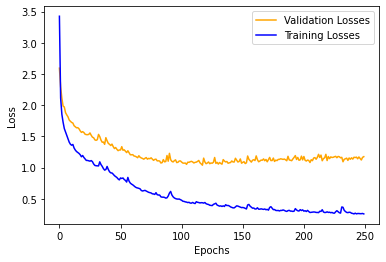

In [92]:
epochs = [u for u in range(NB_EPOCHS)]
plt.plot(epochs, validation_losses, label = 'Validation Losses', color = 'orange')
plt.plot(epochs, training_losses, label = 'Training Losses', color = 'blue')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [163]:
torch.save(obj=detr_fb.state_dict(), f="detr_models/detr_FB_{}epochs_{}batchsize_{}lr.pt".format(NB_EPOCHS, BATCH_SIZE, LEARNING_RATE))

#### **Test :**

In [181]:
instances_val = CocoDetection_diy_bis(root = data_path_val, annFile = labels_path_val, size=(224,224))
instances_val_dataloader = DataLoader(instances_val, batch_size=20, shuffle=False, collate_fn = collate_fn_diy)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [182]:
images,labels = next(iter(instances_val_dataloader))

In [183]:
with torch.no_grad() :
    predictions = detr_fb(images.cuda())

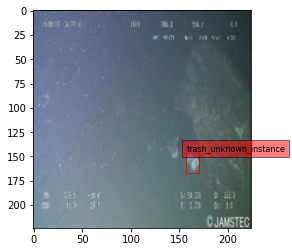

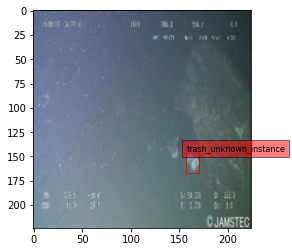

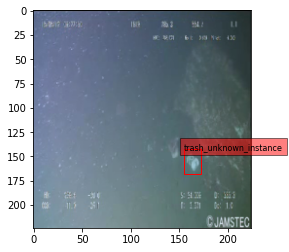

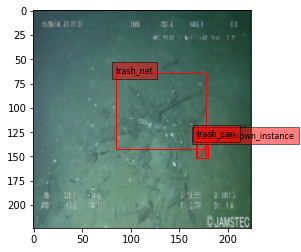

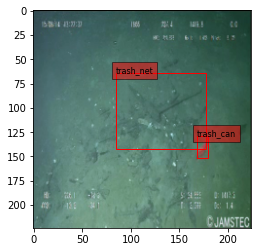

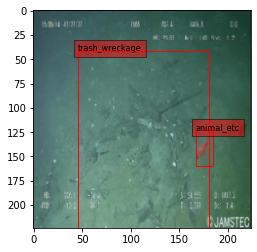

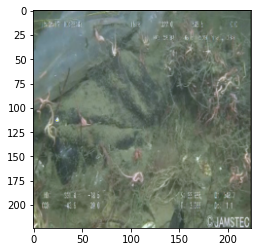

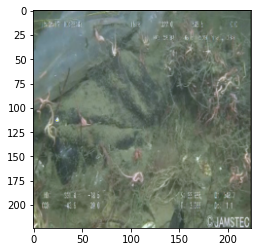

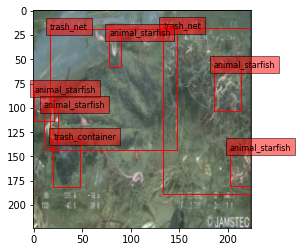

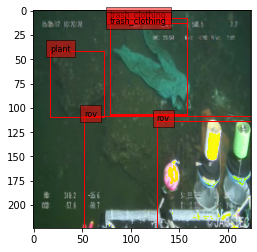

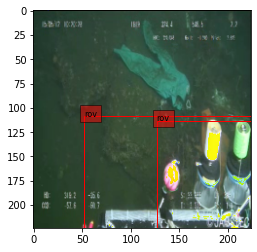

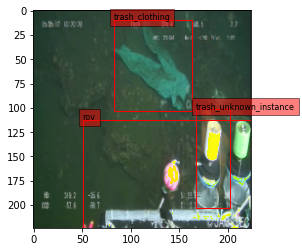

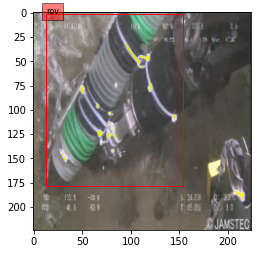

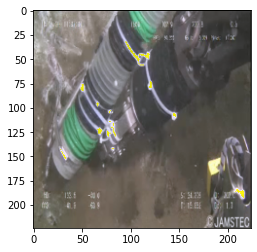

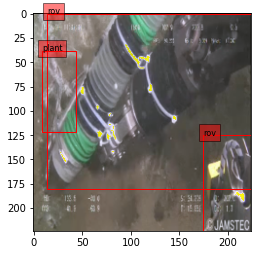

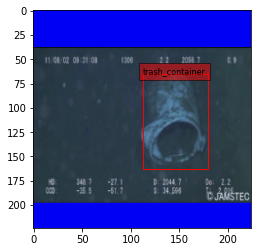

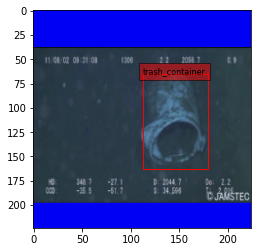

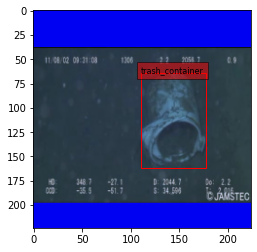

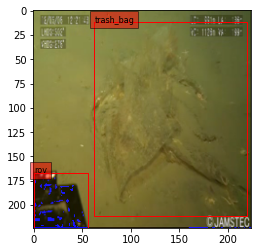

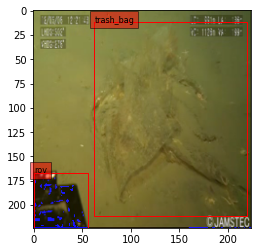

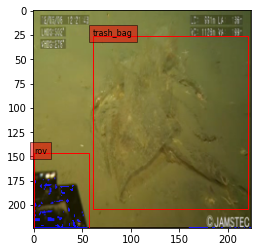

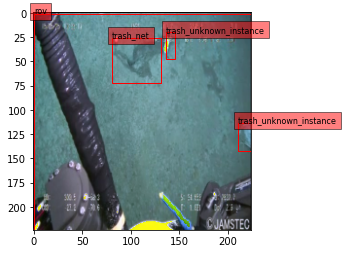

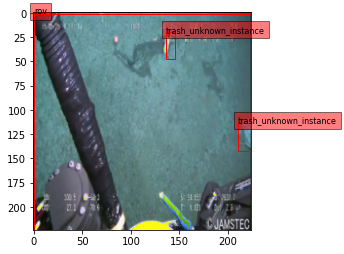

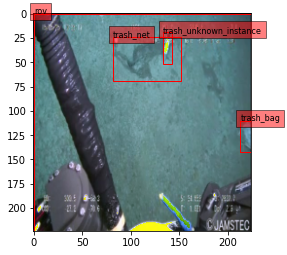

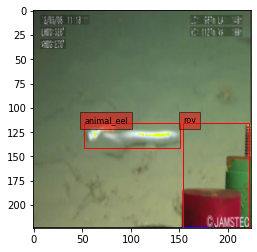

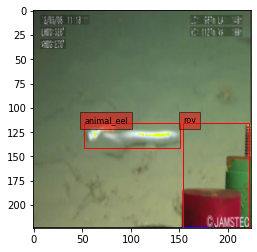

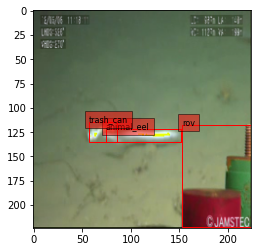

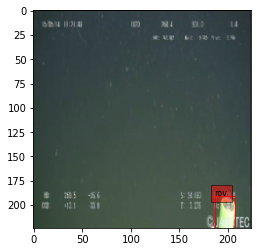

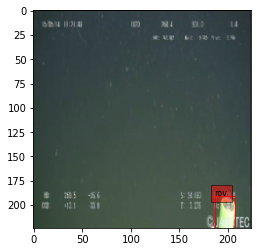

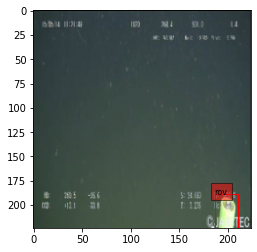

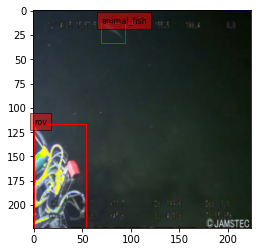

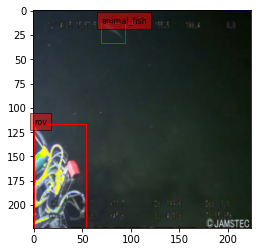

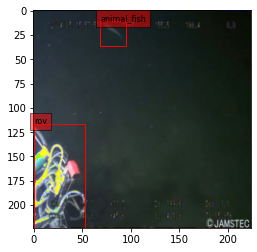

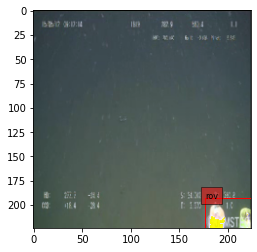

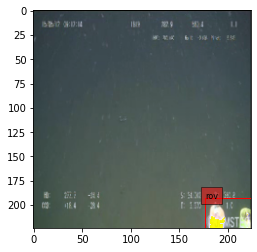

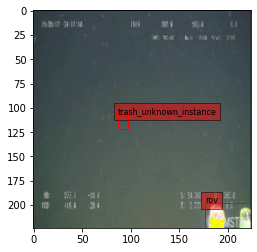

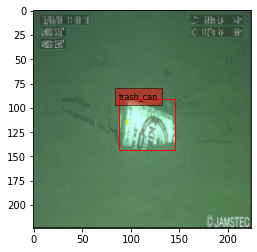

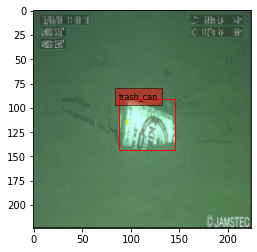

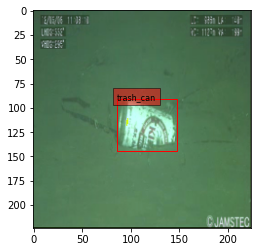

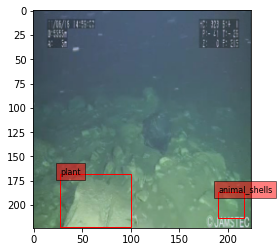

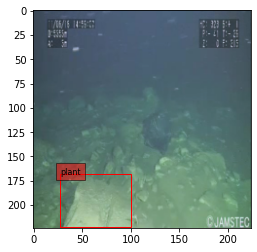

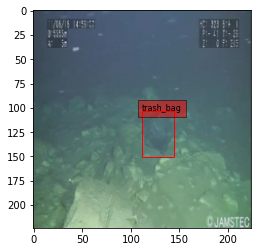

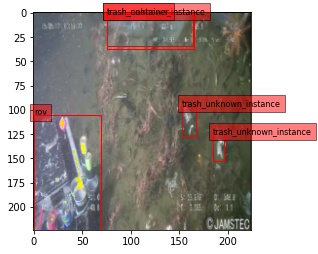

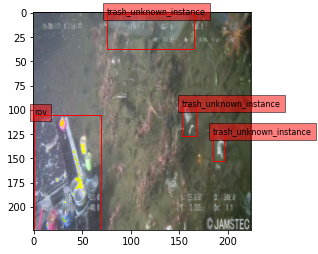

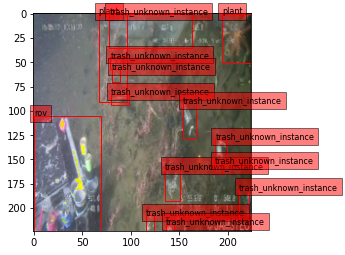

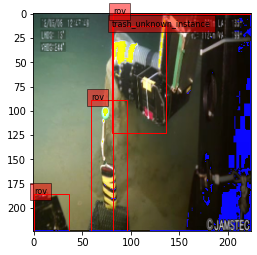

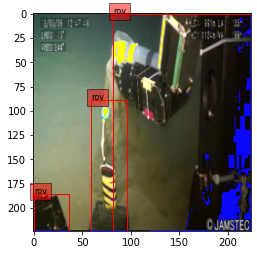

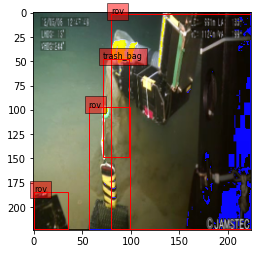

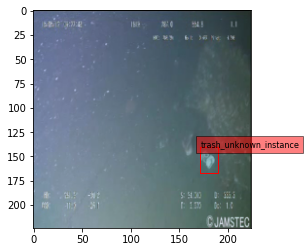

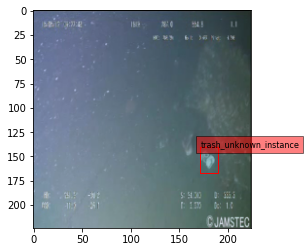

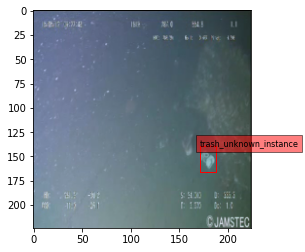

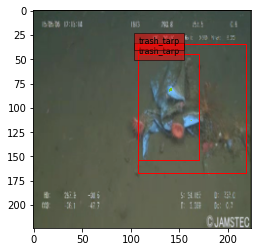

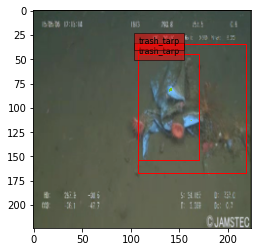

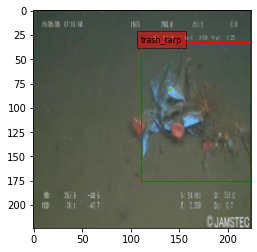

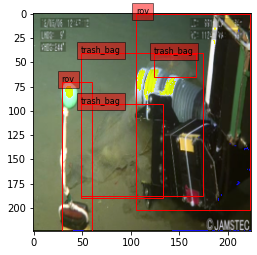

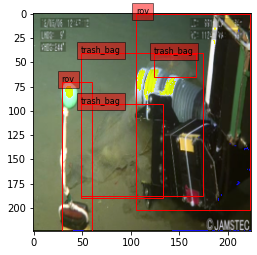

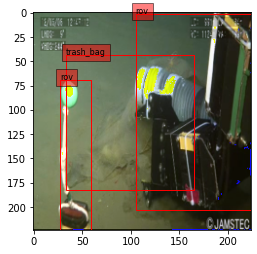

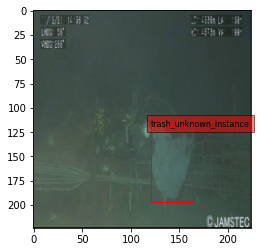

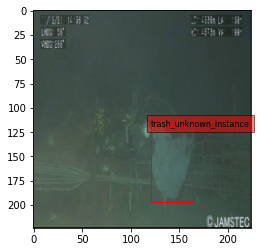

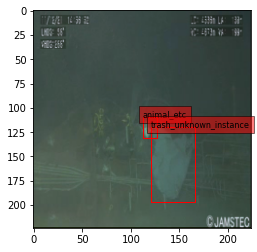

In [184]:
for i in range(20) : 
    plot_bounding_boxes_predictions(images, predictions,i, keep_pred = 0)
    plot_bounding_boxes_predictions(images, predictions,i, keep_pred = 0.6)
    plot_bounding_boxes(images,labels,i)

## Performance metric - mAP

https://blog.paperspace.com/mean-average-precision/

### IoU computation :

In [66]:
def bbox_cxcywh_to_xyxy(x): 
    # Fonction reprise du git FB : renvoie la bbox sous forme de deux points, 
    # qui correspondent au coin inférieur gauche et supérieur droit
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


def IoU (b1, b2) : 
    """
    Parameters : 
    -----------
    b1, b2 : tensor qui contient des bounding boxes au format [c_x, c_y, w, h] (size : batch_size x num_queries (N) x 4)
      b1 correspond aux ground truth et b2 aux prédictions associées

    Output : 
    -------
    Matrice de taille len(b1) x len(b2), qui contient dans la case i,j la loss_iou entre b1_i, b2_j
    """
#     b1,b2 = b1.cuda(), b2.cuda()
    area1, area2 = b1[:,2]*b1[:,3], b2[:,2]*b2[:,3]

    b1_xyxy, b2_xyxy = bbox_cxcywh_to_xyxy(b1), bbox_cxcywh_to_xyxy(b2)
    
    # On garde le plus grand coin inf gauche, et le plus petit coin sur droit :
    max_inf_gauche = torch.max(b1_xyxy[:, :2], b2_xyxy[:, :2])
    min_inf_gauche = torch.min(b1_xyxy[:,:2], b2_xyxy[:, :2])
    max_sup_droit = torch.max(b1_xyxy[:, 2:], b2_xyxy[:, 2:])
    min_sup_droit = torch.min(b1_xyxy[:,  2:], b2_xyxy[:, 2:])

    # intersection area : 
    # correspond à l'aire de la boite [max_inf_gauche,min_sup_droit] = [(0,0) , max(min_sup_droit - max_inf_gauche ; (0,0))]
    inter_sup_droit_normalise = (min_sup_droit - max_inf_gauche).clamp(min=0)  # si b1 et b2 ont une intersection vide, on aura min_sup_droit - max_inf_gauche < 0, et le clamp permet de fixer l'intersection à 0
    inter_area = inter_sup_droit_normalise[:, 0] * inter_sup_droit_normalise[:, 1]

    # union : 
    # on utilise la formule aire_union = aire_1 + aire_2 - aire_inter
    union_area = area1 + area2 - inter_area

    # On a désormais tous les ingrédients pour calculer L_iou : 
    iou = inter_area/union_area
    return iou

### AP computation 

The following function compute the AP with different thresholds, supposing that the given arguments are corresponding to one category (they should contain all the boxes and logit predicted for one category among all the validation set, the "true" labels corresponding to "True" if the ground truth object is correct and "False" otherwise) :

In [67]:
from sklearn.metrics import precision_score,recall_score

def AP(label_true, boxes, pred_boxes) :
    # all arguments are of the same size M, they contain all the predictions for one class among the validation set

    thresholds = np.arange(start=0.2, stop=0.7, step=0.05)

    # Compute IoU between the boxes :
    iou = IoU(boxes, pred_boxes).numpy()

    # Compute precision/Recall curve :
    precisions, recalls = [], []
    for k in thresholds : 
        true_false = ['True' if i >= k else 'False' for i in iou] # Array containing True if IoU >= k else False

        precision = precision_score(y_true=label_true, y_pred=true_false, pos_label='True',zero_division=0)
        recall = recall_score(y_true=label_true, y_pred=true_false, pos_label='True',zero_division=0)

        precisions.append(precision)
        recalls.append(recall)

    precisions.append(1.)
    recalls.append(0.)
    precisions, recalls = np.array(precisions), np.array(recalls)

    return np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])


### mAP Computation :

In [68]:
def mAP (boxes, labels, pred_boxes, pred_labels, nb_classes=23) :
    
    # We first have to select, for each class n, the predictions for which pred_labels == n :
    label_true_n = {i : [] for i in range(nb_classes)}
    boxes_n = {i : [] for i in range(23)}
    pred_boxes_n = {i : [] for i in range(23)}
    for k,n in enumerate(pred_labels) : 
        boxes_n[n].append(boxes[k])
        pred_boxes_n[n].append(pred_boxes[k])
        label_true_n[n].append(str(labels[k]==n))

    # We want to compute the AP score for each class n :
    AP_n = []
    for n in range(nb_classes) :
        lb_true, bx_true, pred_bx = label_true_n[n],boxes_n[n],pred_boxes_n[n]
        if len(bx_true) == 0 :
          AP_n.append(0)
        else : 
          AP_n.append(AP(lb_true, torch.from_numpy(np.array(bx_true)).float(), torch.from_numpy(np.array(pred_bx)).float()))
    AP_n = AP_n[:-1]
    
    return AP_n, np.mean(AP_n)

### mAP on DETR models :

In [ ]:
import pandas as pd

In [69]:
def mAP_detr(detr_model, bipartite_matcher, validation_dataloader) : 

    # We need to store all the labels and boxes of the predicitons and corresponding gt :
    boxes_, labels_, boxes_pred_, labels_pred_ = [], [], [], []

    for batch_id, (images, labels) in enumerate(instances_val_dataloader):

        boxes_gt, labels_gt = labels[0]['boxes'], labels[0]['labels']

        with torch.no_grad() :
            predictions = detr_model(images.cuda())

        pred_labels_probas, pred_boxes = predictions['pred_logits'][0].cpu().softmax(-1).numpy(), predictions['pred_boxes'][0].cpu().numpy()
        pred_labels = pred_labels_probas.argmax(-1)

        # Matching gt / predictions :
        indices_affectations = bipartite_matcher.forward(predictions, labels) # list of len 1, containing tuples (i,j) with i prediction and j ground truth
        i,j = indices_affectations[0]
        i,j = i.numpy(), j.numpy()
        for k in range(len(i)) :
            if len(boxes_) == 0 : 
                boxes_ = np.expand_dims(boxes_gt[i[k]],axis=0)
                boxes_pred_ = np.expand_dims(pred_boxes[j[k]],axis=0)
            else : 
                boxes_ = np.concatenate((boxes_,np.expand_dims(boxes_gt[i[k]],axis=0)))
                boxes_pred_ = np.concatenate((boxes_pred_,np.expand_dims(pred_boxes[j[k]],axis=0)))
            labels_.append(labels_gt[i[k]].item())
            labels_pred_.append(pred_labels[j[k]])

        # For the predictions of non empty objects with no correspondance, we associate label_gt == 22 et boxex_gt = [0,0,0,0]
        for k in range(len(pred_labels)) :
            if (pred_labels[k]!=22) and (k not in j) :
                labels_.append(22)
                labels_pred_.append(pred_labels[k])
                boxes_ = np.concatenate((boxes_,np.expand_dims(np.array([0,0,0,0]),axis=0)))
                boxes_pred_ = np.concatenate((boxes_pred_,np.expand_dims(pred_boxes[k],axis=0)))

    # Computation of mAP :
    return mAP(boxes_, labels_, boxes_pred_, labels_pred_)


In [100]:
instances_val_1 = CocoDetection_diy_bis(root = data_path_val, annFile = labels_path_val, size=(224,224))
instances_val_dataloader_1 = DataLoader(instances_val, batch_size=1, shuffle=True, collate_fn = collate_fn_diy)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


* On FB DETR with only prediction head trained on 50 epochs :

In [ ]:
# On FB detr with prediction head only re trained on 50 epochs :
a,b = mAP_detr(detr_fb, bipartite_matcher, instances_val)
b

0.28592565649630103

* On FB DETR re-trained on 250 epochs :

In [127]:
# On detr trained on 250 epochs with training of the resnet :
a,b = mAP_detr(detr_fb, bipartite_matcher, instances_val)
b

0.76210575991601

In [133]:
df_fb = pd.DataFrame({'classes' : INSTANCES_CLASSES, 'AP' : a})
df_fb['model'] = 'FB'
df_fb

classes        AP model
0                      rov  0.978093    FB
1                    plant  0.891001    FB
2              animal_fish  0.566667    FB
3          animal_starfish  0.705193    FB
4            animal_shells  0.833333    FB
5              animal_crab  0.681313    FB
6               animal_eel  0.962011    FB
7               animal_etc  0.875000    FB
8           trash_clothing  1.000000    FB
9               trash_pipe  1.000000    FB
10            trash_bottle  1.000000    FB
11               trash_bag  0.941864    FB
12     trash_snack_wrapper  0.500000    FB
13               trash_can  0.926814    FB
14               trash_cup  0.000000    FB
15         trash_container  0.928571    FB
16  trash_unknown_instance  0.887519    FB
17            trash_branch  0.900000    FB
18          trash_wreckage  0.800000    FB
19              trash_tarp  0.583333    FB
20              trash_rope  0.000000    FB
21               trash_net  0.805612    FB

<AxesSubplot:ylabel='classes'>

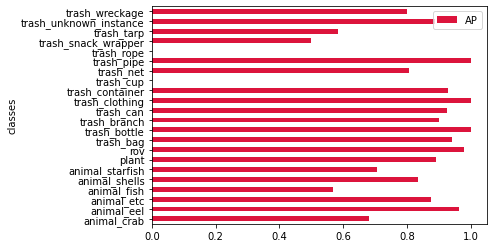

In [151]:
df_fb = df_fb.sort_values('classes')
df_fb.plot(x='classes', y='AP', kind='barh', color='crimson')

* On DETR trained on 250 epochs :

In [131]:
# On detr trained on 250 epochs with training of the resnet :
a_,b_ = mAP_detr(detr, bipartite_matcher, instances_val)
b_

0.6024986659294297

In [135]:
df = pd.DataFrame({'classes' : INSTANCES_CLASSES, 'AP' : a_})
df['model'] = 'DIY'
df

classes        AP model
0                      rov  0.880623   DIY
1                    plant  0.701935   DIY
2              animal_fish  0.212963   DIY
3          animal_starfish  0.000000   DIY
4            animal_shells  0.000000   DIY
5              animal_crab  0.000000   DIY
6               animal_eel  0.534286   DIY
7               animal_etc  0.500000   DIY
8           trash_clothing  0.000000   DIY
9               trash_pipe  1.000000   DIY
10            trash_bottle  0.666667   DIY
11               trash_bag  0.900727   DIY
12     trash_snack_wrapper  1.000000   DIY
13               trash_can  0.833333   DIY
14               trash_cup  0.000000   DIY
15         trash_container  1.000000   DIY
16  trash_unknown_instance  0.524437   DIY
17            trash_branch  1.000000   DIY
18          trash_wreckage  1.000000   DIY
19              trash_tarp  1.000000   DIY
20              trash_rope  1.000000   DIY
21               trash_net  0.500000   DIY

<AxesSubplot:ylabel='classes'>

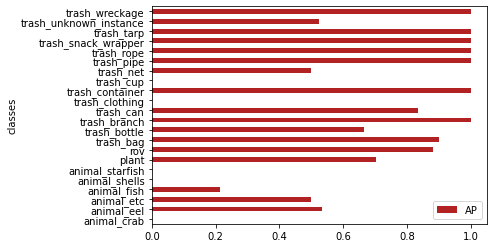

In [146]:
df = df.sort_values('classes')
df.plot(x='classes', y='AP', kind='barh',color='firebrick')

<AxesSubplot:ylabel='classes'>

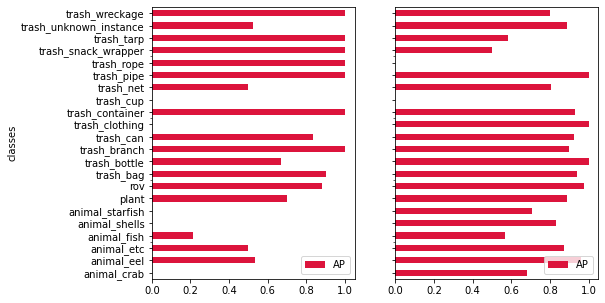

In [156]:
fig,ax = plt.subplots(1,2,figsize=(8,5),sharey=True, sharex=True)

df.plot(x='classes', y='AP', kind='barh',color='crimson',ax=ax[0], legend='False')
df_fb.plot(x='classes', y='AP', kind='barh', color='crimson',ax=ax[1], legend='False')